# Setup

The implementation is given by: https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [1]:
!pip install tensorflow-addons
!pip install tensorflow==2.8.3
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.4/498.4 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
     

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import pickle
import keras_tuner

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [21]:
!nvidia-smi

Mon Feb 13 09:38:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    51W / 400W |   2698MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 13 09:38:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    51W / 400W |   2698MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Prepare the data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
dataset_dir = "gdrive/MyDrive/hyper-kvasir-dataset-final"

In [5]:
def get_dataCategories(dataset_dir):
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])

categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  23


,categorie,numbre of files
0,barretts,41
1,barretts-short-segment,53
2,bbps-0-1,646
3,bbps-2-3,1158
4,cecum,1027
5,dyed-lifted-polyps,1002
6,dyed-resection-margins,989
7,esophagitis-a,413
8,esophagitis-b-d,260
9,hemorrhoids,6


## Obtaining the entire data and labels

In [6]:
def get_x_y(datadir, categories, img_wid, img_high):
    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                print(e)

    y = np.array(y)
    X = np.array(X)

    # reshape X into img_wid x img_high x 3
    X = X.reshape(X.shape[0], img_wid, img_high, 3)

    return X, y


img_wid, img_high = 224, 224
X, y = get_x_y(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (10740, 224, 224, 3)
y: (10740,)


## Visualize the data

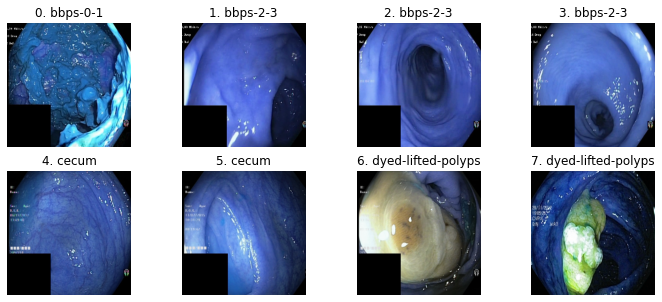

In [ ]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()

## Split the data into train and test

In [8]:
Y = np.reshape(y, (len(y), 1))


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (8592, 224, 224, 3)
y_train: (8592, 1)
X_test: (2148, 224, 224, 3)
y_test: (2148, 1)


# Data augmentation

In [9]:
# Data augmentation

image_size = 224

data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.02),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# Building the ViT model

[Model diagram](https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png)

## Multi-Layer-Perceptron (MLP)

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Patch creation layer

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


## Hyper-parameters

In [12]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 250
image_size = 224  # We'll resize input images to this size
patch_size = 24  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
seed = 1

(-0.5, 223.5, 223.5, -0.5)

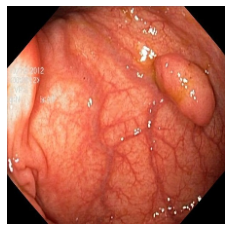

In [32]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

Image size: 224 X 224
Patch size: 24 X 24
Patches per image: 81
Elements per patch: 1728


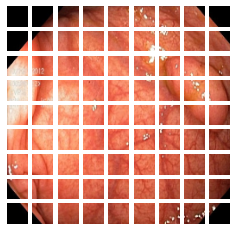

In [33]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch encoding layer

In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


# Final ViT model

In [14]:
num_classes = 23
input_shape = (224, 224, 3)

def optimize_vit_classifier(hp):

    # Five steps approach to select a initial seed
    tf.random.set_seed(hp.Choice('seed', [1, 2]))

    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patch_size = hp.Choice('patch_size', [12, 18, 24])
    num_patches = (image_size // patch_size) ** 2
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    projection_dim = hp.Choice('projection_dim', [16, 32, 64, 128])
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    transformer_units = [
      projection_dim * 2,
      projection_dim,
    ]

    # Create multiple layers of the Transformer block.
    for _ in range(hp.Choice('transformer_layers', [4, 8, 12, 16])):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    # Compiling the final  model 
    optimizer = AdamW(
        learning_rate=hp.Choice('learning_rate', [0.00001, 0.0001, 0.001, 0.01]), weight_decay=hp.Choice('weight_decay', [0.00001, 0.0001, 0.001, 0.01])
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
        ],
    )

    return model


# Pre-tunning

In [38]:
from keras_tuner import RandomSearch

# tuner for function
tuner = RandomSearch(
    optimize_vit_classifier,
    objective='val_accuracy',
    max_trials=10000,
    overwrite=True,
    executions_per_trial=1)

In [ ]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best weight_decay: {best_hps.get('weight_decay')}")
print(f"Best projection_dim: {best_hps.get('projection_dim')}")
print(f"Best transfomers units: [{int(best_hps.get('projection_dim')) * 2}, {best_hps.get('projection_dim')}]")
print(f"transformer_layers: {best_hps.get('transformer_layers')}")
print(f"Best patch_size: {best_hps.get('patch_size')}")
print(f"Best number of patches: {(image_size // int(best_hps.get('patch_size'))) ** 2}")
print(f"Best seed: {best_hps.get('seed')}")

# Using W&D Tunning

In [15]:
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=41424a305b262ad7ad674208509ee32e52da10db71333705f1099ac9e167066a
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [47]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import os

os.environ['WANDB_NOTEBOOK_NAME'] = 'gdrive/MyDrive/Universidad/TFG/notebooks/2.1-rep-first-vit-tf-from-scratch-tunner.ipynb'

wandb.login()

True

In [48]:
num_classes = 23
input_shape = (224, 224, 3)

def get_vit_classifier(seed: int, patch_size: int, projection_dim: int, transformers_layer: int,
                            learning_rate: float, weight_decay: float):

    # Five steps approach to select a initial seed
    tf.random.set_seed(seed)

    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    num_patches = (image_size // patch_size) ** 2
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    transformer_units = [
      projection_dim * 2,
      projection_dim,
    ]

    # Create multiple layers of the Transformer block.
    for _ in range(transformers_layer):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    # Compiling the final  model 
    optimizer = AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
        ],
    )

    return model


In [53]:
sweep_config = {
    'method': 'bayes'
}


metric = {
    'name': 'val_loss',
    'goal': 'minimize'   
}

sweep_config['metric'] = metric

parameters_dict = {
    'seed': {
        'values': [1, 2, 3, 4, 5]
        },
    'patch_size': {
          'values': [12, 16, 20, 24]
        },
    'projection_dim': {
          'values': [16, 32, 64, 128]
        },
    'transfomers_layers': {
          'values': [4, 8, 12, 16]
        },
    'learning_rate': {
        'values': [0.00001, 0.0001, 0.001, 0.01]
    },
    'weight_decay': {
        'values': [0.00001, 0.0001, 0.001, 0.01]
    },
    'batch_size': {
        'values': [32, 64, 128, 256]
    }
}

sweep_config['parameters'] = parameters_dict


parameters_dict.update({
    'epochs': {
        'value': 5
    }
})

In [54]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'batch_size': {'values': [32, 64, 128, 256]},
                'epochs': {'value': 5},
                'learning_rate': {'values': [1e-05, 0.0001, 0.001, 0.01]},
                'patch_size': {'values': [12, 16, 20, 24]},
                'projection_dim': {'values': [16, 32, 64, 128]},
                'seed': {'values': [1, 2, 3, 4, 5]},
                'transfomers_layers': {'values': [4, 8, 12, 16]},
                'weight_decay': {'values': [1e-05, 0.0001, 0.001, 0.01]}}}


In [36]:
def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "vit-scratch"
        wandb.config.dataset_name = "Hyper-Kvasir"

        # initialize model
        model = get_vit_classifier(wandb.config.seed, wandb.config.patch_size, wandb.config.projection_dim,
                                   wandb.config.transfomers_layers, wandb.config.learning_rate, wandb.config.weight_decay)

        # callback setup
        wandb_callbacks = [
            WandbMetricsLogger() # We can add a checkpoint
        ]

        model.fit(X_train, 
                  y_train, 
                  batch_size=wandb.config.batch_size, 
                  epochs=wandb.config.epochs, 
                  validation_split=0.2, 
                  callbacks=wandb_callbacks)

In [59]:
sweep_id = wandb.sweep(sweep_config, project="hyper-kvasir-optimization-models", entity="ava-research-hyper-kvasir")

Create sweep with ID: 1pz01j2p
Sweep URL: https://wandb.ai/ava-research-hyper-kvasir/hyper-kvasir-optimization-models/sweeps/1pz01j2p


In [60]:
wandb.agent(sweep_id, function=sweep_train, count=10000)

wandb: Agent Starting Run: zlfwm9cr with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 26s 135ms/step - loss: 2.8647 - accuracy: 0.2616 - top-5-accuracy: 0.6835 - val_loss: 1.4277 - val_accuracy: 0.5096 - val_top-5-accuracy: 0.9319
Epoch 2/5
54/54 [==============================] - 5s 89ms/step - loss: 1.9013 - accuracy: 0.4131 - top-5-accuracy: 0.8533 - val_loss: 1.2189 - val_accuracy: 0.5829 - val_top-5-accuracy: 0.9442
Epoch 3/5
54/54 [==============================] - 5s 86ms/step - loss: 1.6505 - accuracy: 0.4740 - top-5-accuracy: 0.8987 - val_loss: 1.1396 - val_accuracy: 0.6027 - val_top-5-accuracy: 0.9552
Epoch 4/5
54/54 [==============================] - 5s 87ms/step - loss: 1.4984 - accuracy: 0.5170 - top-5-accuracy: 0.9156 - val_loss: 1.0638 - val_accuracy: 0.6289 - val_top-5-accuracy: 0.9622
Epoch 5/5
54/54 [==============================] - 5s 89ms/step - loss: 1.3707 - accuracy: 0.5423 - top-5-accuracy: 0.9377 - val_loss: 1.0257 - val_accuracy: 0.6323 - val_top-5-accuracy: 0.9668


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▂▁
epoch/top-5-accuracy,▁▆▇▇█
epoch/val_accuracy,▁▅▆██
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▃▆▇█
epoch/accuracy,0.54227
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: dvoum9lq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
215/215 [==============================] - 12s 33ms/step - loss: 2.4599 - accuracy: 0.3617 - top-5-accuracy: 0.7826 - val_loss: 1.2333 - val_accuracy: 0.5759 - val_top-5-accuracy: 0.9453
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 1.6327 - accuracy: 0.4932 - top-5-accuracy: 0.8987 - val_loss: 1.1872 - val_accuracy: 0.5718 - val_top-5-accuracy: 0.9575
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 1.4081 - accuracy: 0.5456 - top-5-accuracy: 0.9275 - val_loss: 0.9801 - val_accuracy: 0.6504 - val_top-5-accuracy: 0.9692
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 1.2673 - accuracy: 0.5814 - top-5-accuracy: 0.9405 - val_loss: 0.9218 - val_accuracy: 0.6713 - val_top-5-accuracy: 0.9750
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 1.1686 - accuracy: 0.6115 - top-5-accuracy: 0.9524 - val_loss: 0.8997 - val_accuracy: 0.6748 - val_top-5-accuracy: 0.9732


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▁▆██
epoch/val_loss,█▇▃▁▁
epoch/val_top-5-accuracy,▁▄▇██
epoch/accuracy,0.61152
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: tgqbclhj with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
108/108 [==============================] - 18s 81ms/step - loss: 7.3035 - accuracy: 0.1548 - top-5-accuracy: 0.5309 - val_loss: 2.7605 - val_accuracy: 0.1728 - val_top-5-accuracy: 0.5870
Epoch 2/5
108/108 [==============================] - 7s 66ms/step - loss: 2.8150 - accuracy: 0.0962 - top-5-accuracy: 0.4793 - val_loss: 2.6994 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4939
Epoch 3/5
108/108 [==============================] - 7s 66ms/step - loss: 2.7412 - accuracy: 0.1158 - top-5-accuracy: 0.4876 - val_loss: 2.6768 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 4/5
108/108 [==============================] - 7s 65ms/step - loss: 2.7134 - accuracy: 0.1110 - top-5-accuracy: 0.4889 - val_loss: 2.6702 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951
Epoch 5/5
108/108 [==============================] - 7s 66ms/step - loss: 2.6950 - accuracy: 0.1097 - top-5-accuracy: 0.4847 - val_loss: 2.6667 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991


epoch/accuracy,█▁▃▃▃
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,█▁▂▂▂
epoch/val_accuracy,█▁▁▁▁
epoch/val_loss,█▃▂▁▁
epoch/val_top-5-accuracy,█▁▁▁▁
epoch/accuracy,0.1097
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: 4ci20t2h with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/5
54/54 [==============================] - 33s 258ms/step - loss: 3.7816 - accuracy: 0.3025 - top-5-accuracy: 0.7308 - val_loss: 1.5131 - val_accuracy: 0.5573 - val_top-5-accuracy: 0.9418
Epoch 2/5
54/54 [==============================] - 11s 210ms/step - loss: 1.7491 - accuracy: 0.4436 - top-5-accuracy: 0.8811 - val_loss: 1.2139 - val_accuracy: 0.5905 - val_top-5-accuracy: 0.9546
Epoch 3/5
54/54 [==============================] - 11s 209ms/step - loss: 1.4240 - accuracy: 0.5420 - top-5-accuracy: 0.9259 - val_loss: 1.0465 - val_accuracy: 0.6300 - val_top-5-accuracy: 0.9738
Epoch 4/5
54/54 [==============================] - 11s 209ms/step - loss: 1.2955 - accuracy: 0.5568 - top-5-accuracy: 0.9433 - val_loss: 0.9086 - val_accuracy: 0.6835 - val_top-5-accuracy: 0.9773
Epoch 5/5
54/54 [==============================] - 11s 209ms/step - loss: 1.1486 - accuracy: 0.5996 - top-5-accuracy: 0.9555 - val_loss: 0.8657 - val_accuracy: 0.6725 - val_top-5-accuracy: 0.9721


epoch/accuracy,▁▄▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▃▅█▇
epoch/val_loss,█▅▃▁▁
epoch/val_top-5-accuracy,▁▄▇█▇
epoch/accuracy,0.59959
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m7dj5517 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Epoch 1/5
215/215 [==============================] - 23s 62ms/step - loss: 6.9020 - accuracy: 0.0998 - top-5-accuracy: 0.4644 - val_loss: 2.7159 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 2/5
215/215 [==============================] - 11s 50ms/step - loss: 2.7157 - accuracy: 0.1049 - top-5-accuracy: 0.4813 - val_loss: 2.6746 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4904
Epoch 3/5
215/215 [==============================] - 11s 49ms/step - loss: 2.7150 - accuracy: 0.1103 - top-5-accuracy: 0.4841 - val_loss: 2.6691 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 4/5
215/215 [==============================] - 11s 50ms/step - loss: 2.7412 - accuracy: 0.1096 - top-5-accuracy: 0.4906 - val_loss: 2.6661 - val_accuracy: 0.1198 - val_top-5-accuracy: 0.4997
Epoch 5/5
215/215 [==============================] - 11s 50ms/step - loss: 2.7281 - accuracy: 0.1097 - top-5-accuracy: 0.4864 - val_loss: 2.6643 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4916


epoch/accuracy,▁▄███
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▆▆█▇
epoch/val_accuracy,▁▁▁█▁
epoch/val_loss,█▂▂▁▁
epoch/val_top-5-accuracy,█▁██▂
epoch/accuracy,0.1097
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: qsu827l1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
215/215 [==============================] - 12s 32ms/step - loss: 3.5574 - accuracy: 0.2177 - top-5-accuracy: 0.5749 - val_loss: 1.5576 - val_accuracy: 0.4951 - val_top-5-accuracy: 0.8947
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 2.4999 - accuracy: 0.3229 - top-5-accuracy: 0.7605 - val_loss: 1.3787 - val_accuracy: 0.5364 - val_top-5-accuracy: 0.9232
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 2.1011 - accuracy: 0.3845 - top-5-accuracy: 0.8206 - val_loss: 1.2981 - val_accuracy: 0.5532 - val_top-5-accuracy: 0.9331
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 1.8762 - accuracy: 0.4230 - top-5-accuracy: 0.8551 - val_loss: 1.2452 - val_accuracy: 0.5742 - val_top-5-accuracy: 0.9424
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 1.7072 - accuracy: 0.4657 - top-5-accuracy: 0.8820 - val_loss: 1.1785 - val_accuracy: 0.5939 - val_top-5-accuracy: 0.9488


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▄▅▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▆▇█
epoch/accuracy,0.46574
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zttv418x with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 13s 34ms/step - loss: 2.7366 - accuracy: 0.3176 - top-5-accuracy: 0.7948 - val_loss: 3.0632 - val_accuracy: 0.2222 - val_top-5-accuracy: 0.7987
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 3.1170 - accuracy: 0.1688 - top-5-accuracy: 0.6627 - val_loss: 3.1285 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4939
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 3.1288 - accuracy: 0.1094 - top-5-accuracy: 0.4832 - val_loss: 3.1288 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 3.1290 - accuracy: 0.1013 - top-5-accuracy: 0.4857 - val_loss: 3.1288 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 3.1290 - accuracy: 0.1072 - top-5-accuracy: 0.4863 - val_loss: 3.1289 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4916


epoch/accuracy,█▃▁▁▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,▁████
epoch/top-5-accuracy,█▅▁▁▁
epoch/val_accuracy,█▁▁▁▁
epoch/val_loss,▁████
epoch/val_top-5-accuracy,█▁▁▁▁
epoch/accuracy,0.10723
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: agbw6m2w with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 25s 177ms/step - loss: 4.2707 - accuracy: 0.1285 - top-5-accuracy: 0.4161 - val_loss: 1.9980 - val_accuracy: 0.3735 - val_top-5-accuracy: 0.8197
Epoch 2/5
54/54 [==============================] - 7s 139ms/step - loss: 3.3090 - accuracy: 0.2127 - top-5-accuracy: 0.6044 - val_loss: 1.7098 - val_accuracy: 0.4596 - val_top-5-accuracy: 0.8709
Epoch 3/5
54/54 [==============================] - 7s 138ms/step - loss: 2.9194 - accuracy: 0.2683 - top-5-accuracy: 0.6831 - val_loss: 1.5848 - val_accuracy: 0.4642 - val_top-5-accuracy: 0.8889
Epoch 4/5
54/54 [==============================] - 8s 140ms/step - loss: 2.7087 - accuracy: 0.2908 - top-5-accuracy: 0.7238 - val_loss: 1.5012 - val_accuracy: 0.5020 - val_top-5-accuracy: 0.9034
Epoch 5/5
54/54 [==============================] - 7s 138ms/step - loss: 2.4811 - accuracy: 0.3195 - top-5-accuracy: 0.7637 - val_loss: 1.4489 - val_accuracy: 0.5212 - val_top-5-accuracy: 0.9092


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/top-5-accuracy,▁▅▆▇█
epoch/val_accuracy,▁▅▅▇█
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▅▆██
epoch/accuracy,0.31951
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: hfkovcli with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/5
108/108 [==============================] - 27s 119ms/step - loss: 9.9120 - accuracy: 0.1803 - top-5-accuracy: 0.5760 - val_loss: 1.9757 - val_accuracy: 0.3822 - val_top-5-accuracy: 0.8272
Epoch 2/5
108/108 [==============================] - 10s 96ms/step - loss: 2.0525 - accuracy: 0.3362 - top-5-accuracy: 0.8202 - val_loss: 1.4874 - val_accuracy: 0.5148 - val_top-5-accuracy: 0.9151
Epoch 3/5
108/108 [==============================] - 10s 96ms/step - loss: 1.6177 - accuracy: 0.4538 - top-5-accuracy: 0.9034 - val_loss: 1.3025 - val_accuracy: 0.5631 - val_top-5-accuracy: 0.9540
Epoch 4/5
108/108 [==============================] - 10s 96ms/step - loss: 1.4946 - accuracy: 0.4929 - top-5-accuracy: 0.9225 - val_loss: 1.2490 - val_accuracy: 0.5852 - val_top-5-accuracy: 0.9447
Epoch 5/5
108/108 [==============================] - 10s 96ms/step - loss: 1.4779 - accuracy: 0.5008 - top-5-accuracy: 0.9192 - val_loss: 1.3830 - val_accuracy: 0.5166 - val_top-5-accuracy: 0.9296


epoch/accuracy,▁▄▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▆███
epoch/val_accuracy,▁▆▇█▆
epoch/val_loss,█▃▂▁▂
epoch/val_top-5-accuracy,▁▆█▇▇
epoch/accuracy,0.5008
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: 7g7k7km3 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 36s 151ms/step - loss: 2.5733 - accuracy: 0.3639 - top-5-accuracy: 0.7877 - val_loss: 1.2274 - val_accuracy: 0.5928 - val_top-5-accuracy: 0.9488
Epoch 2/5
108/108 [==============================] - 14s 127ms/step - loss: 1.6802 - accuracy: 0.5023 - top-5-accuracy: 0.8916 - val_loss: 1.0038 - val_accuracy: 0.6498 - val_top-5-accuracy: 0.9622
Epoch 3/5
108/108 [==============================] - 14s 126ms/step - loss: 1.4585 - accuracy: 0.5437 - top-5-accuracy: 0.9238 - val_loss: 0.9518 - val_accuracy: 0.6603 - val_top-5-accuracy: 0.9767
Epoch 4/5
108/108 [==============================] - 14s 126ms/step - loss: 1.2652 - accuracy: 0.5802 - top-5-accuracy: 0.9457 - val_loss: 0.8740 - val_accuracy: 0.6824 - val_top-5-accuracy: 0.9802
Epoch 5/5
108/108 [==============================] - 14s 126ms/step - loss: 1.1490 - accuracy: 0.6095 - top-5-accuracy: 0.9571 - val_loss: 0.7923 - val_accuracy: 0.7126 - val_top-5-accuracy: 0.9785


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/top-5-accuracy,▁▅▇██
epoch/val_accuracy,▁▄▅▆█
epoch/val_loss,█▄▄▂▁
epoch/val_top-5-accuracy,▁▄▇██
epoch/accuracy,0.60949
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 62lti8rk with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 9s 61ms/step - loss: 2.2460 - accuracy: 0.3984 - top-5-accuracy: 0.8205 - val_loss: 1.2257 - val_accuracy: 0.5974 - val_top-5-accuracy: 0.9523
Epoch 2/5
54/54 [==============================] - 2s 40ms/step - loss: 1.4120 - accuracy: 0.5322 - top-5-accuracy: 0.9275 - val_loss: 1.0221 - val_accuracy: 0.6219 - val_top-5-accuracy: 0.9663
Epoch 3/5
54/54 [==============================] - 2s 40ms/step - loss: 1.2491 - accuracy: 0.5709 - top-5-accuracy: 0.9492 - val_loss: 1.0059 - val_accuracy: 0.6405 - val_top-5-accuracy: 0.9732
Epoch 4/5
54/54 [==============================] - 2s 40ms/step - loss: 1.1204 - accuracy: 0.6061 - top-5-accuracy: 0.9600 - val_loss: 0.9079 - val_accuracy: 0.6777 - val_top-5-accuracy: 0.9738
Epoch 5/5
54/54 [==============================] - 2s 39ms/step - loss: 1.0782 - accuracy: 0.6184 - top-5-accuracy: 0.9601 - val_loss: 0.8195 - val_accuracy: 0.7091 - val_top-5-accuracy: 0.9791


epoch/accuracy,▁▅▆██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▃▄▆█
epoch/val_loss,█▄▄▃▁
epoch/val_top-5-accuracy,▁▅▆▇█
epoch/accuracy,0.61836
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gfkv6xlq with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/5
54/54 [==============================] - 23s 131ms/step - loss: 11.7350 - accuracy: 0.2118 - top-5-accuracy: 0.6099 - val_loss: 2.4090 - val_accuracy: 0.2891 - val_top-5-accuracy: 0.8127
Epoch 2/5
54/54 [==============================] - 5s 94ms/step - loss: 2.5069 - accuracy: 0.2551 - top-5-accuracy: 0.7129 - val_loss: 1.8257 - val_accuracy: 0.3636 - val_top-5-accuracy: 0.8703
Epoch 3/5
54/54 [==============================] - 5s 92ms/step - loss: 2.3048 - accuracy: 0.2840 - top-5-accuracy: 0.7720 - val_loss: 1.8052 - val_accuracy: 0.4578 - val_top-5-accuracy: 0.8831
Epoch 4/5
54/54 [==============================] - 5s 92ms/step - loss: 2.1762 - accuracy: 0.3109 - top-5-accuracy: 0.7959 - val_loss: 1.7231 - val_accuracy: 0.4863 - val_top-5-accuracy: 0.9017
Epoch 5/5
54/54 [==============================] - 5s 93ms/step - loss: 1.9828 - accuracy: 0.3390 - top-5-accuracy: 0.8448 - val_loss: 1.6333 - val_accuracy: 0.3979 - val_top-5-accuracy: 0.9127


epoch/accuracy,▁▃▅▆█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▄▆▇█
epoch/val_accuracy,▁▄▇█▅
epoch/val_loss,█▃▃▂▁
epoch/val_top-5-accuracy,▁▅▆▇█
epoch/accuracy,0.33901
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: ozgqh5s6 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/5
27/27 [==============================] - 20s 184ms/step - loss: 4.5889 - accuracy: 0.0896 - top-5-accuracy: 0.3518 - val_loss: 2.1135 - val_accuracy: 0.3682 - val_top-5-accuracy: 0.7586
Epoch 2/5
27/27 [==============================] - 3s 102ms/step - loss: 3.5221 - accuracy: 0.1830 - top-5-accuracy: 0.5506 - val_loss: 1.8141 - val_accuracy: 0.4299 - val_top-5-accuracy: 0.8406
Epoch 3/5
27/27 [==============================] - 3s 101ms/step - loss: 3.1218 - accuracy: 0.2386 - top-5-accuracy: 0.6427 - val_loss: 1.6571 - val_accuracy: 0.4695 - val_top-5-accuracy: 0.8912
Epoch 4/5
27/27 [==============================] - 3s 101ms/step - loss: 2.7879 - accuracy: 0.2786 - top-5-accuracy: 0.7076 - val_loss: 1.5663 - val_accuracy: 0.4927 - val_top-5-accuracy: 0.9040
Epoch 5/5
27/27 [==============================] - 3s 104ms/step - loss: 2.6531 - accuracy: 0.3002 - top-5-accuracy: 0.7349 - val_loss: 1.5018 - val_accuracy: 0.5026 - val_top-5-accuracy: 0.9127


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▁▁
epoch/top-5-accuracy,▁▅▆██
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.30016
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: ukdyl07t with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/5
108/108 [==============================] - 37s 163ms/step - loss: 3.4062 - accuracy: 0.2230 - top-5-accuracy: 0.5836 - val_loss: 1.5555 - val_accuracy: 0.4718 - val_top-5-accuracy: 0.8988
Epoch 2/5
108/108 [==============================] - 15s 140ms/step - loss: 1.9954 - accuracy: 0.3774 - top-5-accuracy: 0.8167 - val_loss: 1.4345 - val_accuracy: 0.5381 - val_top-5-accuracy: 0.9279
Epoch 3/5
108/108 [==============================] - 15s 140ms/step - loss: 1.7065 - accuracy: 0.4529 - top-5-accuracy: 0.8769 - val_loss: 1.3954 - val_accuracy: 0.5550 - val_top-5-accuracy: 0.9343
Epoch 4/5
108/108 [==============================] - 15s 140ms/step - loss: 1.5873 - accuracy: 0.5043 - top-5-accuracy: 0.9038 - val_loss: 1.3799 - val_accuracy: 0.5684 - val_top-5-accuracy: 0.9314
Epoch 5/5
108/108 [==============================] - 15s 140ms/step - loss: 1.5434 - accuracy: 0.5252 - top-5-accuracy: 0.9176 - val_loss: 1.3930 - val_accuracy: 0.5846 - val_top-5-accuracy: 0.9314


epoch/accuracy,▁▅▆██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▃▂▁▂
epoch/val_top-5-accuracy,▁▇█▇▇
epoch/accuracy,0.52524
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: f6rpn4g2 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 9s 78ms/step - loss: 4.4929 - accuracy: 0.1103 - top-5-accuracy: 0.3716 - val_loss: 2.0258 - val_accuracy: 0.3770 - val_top-5-accuracy: 0.7749
Epoch 2/5
54/54 [==============================] - 3s 58ms/step - loss: 3.2979 - accuracy: 0.2239 - top-5-accuracy: 0.5872 - val_loss: 1.7573 - val_accuracy: 0.4439 - val_top-5-accuracy: 0.8598
Epoch 3/5
54/54 [==============================] - 3s 59ms/step - loss: 2.9408 - accuracy: 0.2616 - top-5-accuracy: 0.6716 - val_loss: 1.6304 - val_accuracy: 0.4660 - val_top-5-accuracy: 0.8871
Epoch 4/5
54/54 [==============================] - 3s 58ms/step - loss: 2.6508 - accuracy: 0.2939 - top-5-accuracy: 0.7188 - val_loss: 1.5443 - val_accuracy: 0.4846 - val_top-5-accuracy: 0.9017
Epoch 5/5
54/54 [==============================] - 3s 58ms/step - loss: 2.4825 - accuracy: 0.3296 - top-5-accuracy: 0.7572 - val_loss: 1.4849 - val_accuracy: 0.5003 - val_top-5-accuracy: 0.9110


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/top-5-accuracy,▁▅▆▇█
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.32955
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: 9ccb76pu with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/5
215/215 [==============================] - 13s 34ms/step - loss: 2.5981 - accuracy: 0.3879 - top-5-accuracy: 0.8159 - val_loss: 1.2255 - val_accuracy: 0.5689 - val_top-5-accuracy: 0.9366
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 1.3467 - accuracy: 0.5415 - top-5-accuracy: 0.9358 - val_loss: 1.0480 - val_accuracy: 0.6161 - val_top-5-accuracy: 0.9634
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 1.1631 - accuracy: 0.5906 - top-5-accuracy: 0.9561 - val_loss: 0.8716 - val_accuracy: 0.6795 - val_top-5-accuracy: 0.9738
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 1.0537 - accuracy: 0.6233 - top-5-accuracy: 0.9652 - val_loss: 0.8805 - val_accuracy: 0.6760 - val_top-5-accuracy: 0.9750
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.9771 - accuracy: 0.6431 - top-5-accuracy: 0.9709 - val_loss: 0.8756 - val_accuracy: 0.6771 - val_top-5-accuracy: 0.9744


epoch/accuracy,▁▅▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄███
epoch/val_loss,█▄▁▁▁
epoch/val_top-5-accuracy,▁▆███
epoch/accuracy,0.6431
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9b2zu38q with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/5
215/215 [==============================] - 40s 97ms/step - loss: 9.2236 - accuracy: 0.0944 - top-5-accuracy: 0.4585 - val_loss: 2.6947 - val_accuracy: 0.0925 - val_top-5-accuracy: 0.4898
Epoch 2/5
215/215 [==============================] - 18s 84ms/step - loss: 2.7058 - accuracy: 0.1016 - top-5-accuracy: 0.4643 - val_loss: 2.6853 - val_accuracy: 0.0937 - val_top-5-accuracy: 0.4916
Epoch 3/5
215/215 [==============================] - 18s 84ms/step - loss: 2.7080 - accuracy: 0.0944 - top-5-accuracy: 0.4787 - val_loss: 2.6853 - val_accuracy: 0.0977 - val_top-5-accuracy: 0.4904
Epoch 4/5
215/215 [==============================] - 18s 84ms/step - loss: 2.7046 - accuracy: 0.0962 - top-5-accuracy: 0.4798 - val_loss: 2.6760 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4945
Epoch 5/5
215/215 [==============================] - 18s 84ms/step - loss: 2.7052 - accuracy: 0.0970 - top-5-accuracy: 0.4823 - val_loss: 2.6787 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4945


epoch/accuracy,▁█▁▃▄
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▃▇▇█
epoch/val_accuracy,▁▁▃██
epoch/val_loss,█▄▄▁▂
epoch/val_top-5-accuracy,▁▄▂██
epoch/accuracy,0.09705
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9xf6frme with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 32s 316ms/step - loss: 2.7179 - accuracy: 0.3742 - top-5-accuracy: 0.7764 - val_loss: 1.2726 - val_accuracy: 0.5823 - val_top-5-accuracy: 0.9430
Epoch 2/5
54/54 [==============================] - 15s 277ms/step - loss: 1.7596 - accuracy: 0.4919 - top-5-accuracy: 0.8771 - val_loss: 1.0143 - val_accuracy: 0.6533 - val_top-5-accuracy: 0.9634
Epoch 3/5
54/54 [==============================] - 15s 277ms/step - loss: 1.4438 - accuracy: 0.5562 - top-5-accuracy: 0.9160 - val_loss: 0.9763 - val_accuracy: 0.6707 - val_top-5-accuracy: 0.9756
Epoch 4/5
54/54 [==============================] - 15s 277ms/step - loss: 1.3090 - accuracy: 0.5880 - top-5-accuracy: 0.9403 - val_loss: 0.9051 - val_accuracy: 0.6795 - val_top-5-accuracy: 0.9791
Epoch 5/5
54/54 [==============================] - 15s 277ms/step - loss: 1.1994 - accuracy: 0.6092 - top-5-accuracy: 0.9504 - val_loss: 0.8257 - val_accuracy: 0.7103 - val_top-5-accuracy: 0.9837


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▅▇██
epoch/val_accuracy,▁▅▆▆█
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▄▇▇█
epoch/accuracy,0.6092
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: ykdomkev with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/5
215/215 [==============================] - 12s 33ms/step - loss: 3.7153 - accuracy: 0.1397 - top-5-accuracy: 0.4406 - val_loss: 1.8560 - val_accuracy: 0.4305 - val_top-5-accuracy: 0.8511
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 2.7322 - accuracy: 0.2647 - top-5-accuracy: 0.6802 - val_loss: 1.6472 - val_accuracy: 0.4479 - val_top-5-accuracy: 0.8773
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 2.4700 - accuracy: 0.3071 - top-5-accuracy: 0.7513 - val_loss: 1.5163 - val_accuracy: 0.4718 - val_top-5-accuracy: 0.9011
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 2.2971 - accuracy: 0.3346 - top-5-accuracy: 0.7900 - val_loss: 1.4496 - val_accuracy: 0.4939 - val_top-5-accuracy: 0.9098
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 2.1564 - accuracy: 0.3560 - top-5-accuracy: 0.8184 - val_loss: 1.4170 - val_accuracy: 0.4951 - val_top-5-accuracy: 0.9186


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▃▅██
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▄▆▇█
epoch/accuracy,0.35603
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: jh106w37 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
54/54 [==============================] - 15s 82ms/step - loss: 4.3644 - accuracy: 0.0896 - top-5-accuracy: 0.3466 - val_loss: 2.3408 - val_accuracy: 0.3374 - val_top-5-accuracy: 0.7243
Epoch 2/5
54/54 [==============================] - 3s 51ms/step - loss: 3.4439 - accuracy: 0.1708 - top-5-accuracy: 0.5389 - val_loss: 1.9392 - val_accuracy: 0.4252 - val_top-5-accuracy: 0.8330
Epoch 3/5
54/54 [==============================] - 3s 51ms/step - loss: 3.0422 - accuracy: 0.2165 - top-5-accuracy: 0.6275 - val_loss: 1.7202 - val_accuracy: 0.4660 - val_top-5-accuracy: 0.8755
Epoch 4/5
54/54 [==============================] - 3s 53ms/step - loss: 2.7984 - accuracy: 0.2597 - top-5-accuracy: 0.6847 - val_loss: 1.5993 - val_accuracy: 0.4724 - val_top-5-accuracy: 0.9005
Epoch 5/5
54/54 [==============================] - 3s 53ms/step - loss: 2.6268 - accuracy: 0.2876 - top-5-accuracy: 0.7284 - val_loss: 1.5154 - val_accuracy: 0.4945 - val_top-5-accuracy: 0.9133


epoch/accuracy,▁▄▅▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/top-5-accuracy,▁▅▆▇█
epoch/val_accuracy,▁▅▇▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.28765
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: mt2n7jhh with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 12s 33ms/step - loss: 8.3821 - accuracy: 0.2671 - top-5-accuracy: 0.6908 - val_loss: 1.6748 - val_accuracy: 0.4020 - val_top-5-accuracy: 0.8755
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 1.8474 - accuracy: 0.3968 - top-5-accuracy: 0.8691 - val_loss: 1.5264 - val_accuracy: 0.4770 - val_top-5-accuracy: 0.8994
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 1.7710 - accuracy: 0.4227 - top-5-accuracy: 0.8820 - val_loss: 1.5517 - val_accuracy: 0.4729 - val_top-5-accuracy: 0.9191
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 1.7699 - accuracy: 0.4304 - top-5-accuracy: 0.8826 - val_loss: 1.6303 - val_accuracy: 0.4363 - val_top-5-accuracy: 0.9034
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 1.8285 - accuracy: 0.4099 - top-5-accuracy: 0.8736 - val_loss: 1.4733 - val_accuracy: 0.5230 - val_top-5-accuracy: 0.9139


epoch/accuracy,▁▇██▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁████
epoch/val_accuracy,▁▅▅▃█
epoch/val_loss,█▃▄▆▁
epoch/val_top-5-accuracy,▁▅█▅▇
epoch/accuracy,0.40986
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dvl2tqlo with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 27s 218ms/step - loss: 2.1559 - accuracy: 0.3985 - top-5-accuracy: 0.8189 - val_loss: 1.3954 - val_accuracy: 0.5614 - val_top-5-accuracy: 0.9343
Epoch 2/5
54/54 [==============================] - 10s 178ms/step - loss: 1.5684 - accuracy: 0.5234 - top-5-accuracy: 0.9194 - val_loss: 1.5577 - val_accuracy: 0.5492 - val_top-5-accuracy: 0.9069
Epoch 3/5
54/54 [==============================] - 10s 178ms/step - loss: 1.6746 - accuracy: 0.5110 - top-5-accuracy: 0.9006 - val_loss: 1.6943 - val_accuracy: 0.5480 - val_top-5-accuracy: 0.8959
Epoch 4/5
54/54 [==============================] - 10s 178ms/step - loss: 1.8077 - accuracy: 0.4742 - top-5-accuracy: 0.8840 - val_loss: 1.8549 - val_accuracy: 0.4945 - val_top-5-accuracy: 0.8790
Epoch 5/5
54/54 [==============================] - 10s 178ms/step - loss: 1.9408 - accuracy: 0.4331 - top-5-accuracy: 0.8749 - val_loss: 1.9646 - val_accuracy: 0.4363 - val_top-5-accuracy: 0.8726


epoch/accuracy,▁█▇▅▃
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▂▄▅
epoch/top-5-accuracy,▁█▇▆▅
epoch/val_accuracy,█▇▇▄▁
epoch/val_loss,▁▃▅▇█
epoch/val_top-5-accuracy,█▅▄▂▁
epoch/accuracy,0.43314
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: ushgch2d with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/5
215/215 [==============================] - 14s 35ms/step - loss: 6.1831 - accuracy: 0.1091 - top-5-accuracy: 0.4743 - val_loss: 2.7123 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4939
Epoch 2/5
215/215 [==============================] - 7s 31ms/step - loss: 2.7073 - accuracy: 0.1074 - top-5-accuracy: 0.4788 - val_loss: 2.6737 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 3/5
215/215 [==============================] - 6s 30ms/step - loss: 2.7000 - accuracy: 0.1103 - top-5-accuracy: 0.4881 - val_loss: 2.6682 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 4/5
215/215 [==============================] - 7s 30ms/step - loss: 2.6864 - accuracy: 0.1096 - top-5-accuracy: 0.4873 - val_loss: 2.6654 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 5/5
215/215 [==============================] - 7s 30ms/step - loss: 2.6845 - accuracy: 0.1078 - top-5-accuracy: 0.4804 - val_loss: 2.6645 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991


epoch/accuracy,▅▁█▆▂
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▃██▄
epoch/val_accuracy,▁▁▁▁▁
epoch/val_loss,█▂▂▁▁
epoch/val_top-5-accuracy,▁████
epoch/accuracy,0.10781
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: yjxnsie5 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 10s 41ms/step - loss: 2.1249 - accuracy: 0.4152 - top-5-accuracy: 0.8385 - val_loss: 1.1183 - val_accuracy: 0.6161 - val_top-5-accuracy: 0.9564
Epoch 2/5
108/108 [==============================] - 3s 32ms/step - loss: 1.3915 - accuracy: 0.5385 - top-5-accuracy: 0.9316 - val_loss: 0.9943 - val_accuracy: 0.6347 - val_top-5-accuracy: 0.9668
Epoch 3/5
108/108 [==============================] - 3s 31ms/step - loss: 1.2498 - accuracy: 0.5800 - top-5-accuracy: 0.9494 - val_loss: 0.9796 - val_accuracy: 0.6149 - val_top-5-accuracy: 0.9692
Epoch 4/5
108/108 [==============================] - 3s 31ms/step - loss: 1.1079 - accuracy: 0.6051 - top-5-accuracy: 0.9613 - val_loss: 0.8576 - val_accuracy: 0.6870 - val_top-5-accuracy: 0.9750
Epoch 5/5
108/108 [==============================] - 3s 31ms/step - loss: 1.0619 - accuracy: 0.6214 - top-5-accuracy: 0.9652 - val_loss: 0.8303 - val_accuracy: 0.6835 - val_top-5-accuracy: 0.9802


epoch/accuracy,▁▅▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▃▁██
epoch/val_loss,█▅▅▂▁
epoch/val_top-5-accuracy,▁▄▅▆█
epoch/accuracy,0.62142
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: js07m22u with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/5
108/108 [==============================] - 11s 54ms/step - loss: 2.4614 - accuracy: 0.3971 - top-5-accuracy: 0.8050 - val_loss: 1.1166 - val_accuracy: 0.6219 - val_top-5-accuracy: 0.9540
Epoch 2/5
108/108 [==============================] - 5s 43ms/step - loss: 1.4731 - accuracy: 0.5375 - top-5-accuracy: 0.9120 - val_loss: 1.0152 - val_accuracy: 0.6521 - val_top-5-accuracy: 0.9604
Epoch 3/5
108/108 [==============================] - 5s 42ms/step - loss: 1.2393 - accuracy: 0.5912 - top-5-accuracy: 0.9463 - val_loss: 0.9167 - val_accuracy: 0.6830 - val_top-5-accuracy: 0.9686
Epoch 4/5
108/108 [==============================] - 5s 43ms/step - loss: 1.1178 - accuracy: 0.6149 - top-5-accuracy: 0.9593 - val_loss: 0.8917 - val_accuracy: 0.6882 - val_top-5-accuracy: 0.9727
Epoch 5/5
108/108 [==============================] - 5s 42ms/step - loss: 1.0295 - accuracy: 0.6480 - top-5-accuracy: 0.9670 - val_loss: 0.8588 - val_accuracy: 0.6981 - val_top-5-accuracy: 0.9738


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▇▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▃▆██
epoch/accuracy,0.64804
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: s7fh9r79 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/5
27/27 [==============================] - 21s 212ms/step - loss: 26.4004 - accuracy: 0.1843 - top-5-accuracy: 0.5610 - val_loss: 2.1199 - val_accuracy: 0.3665 - val_top-5-accuracy: 0.8517
Epoch 2/5
27/27 [==============================] - 3s 129ms/step - loss: 2.3164 - accuracy: 0.2794 - top-5-accuracy: 0.7678 - val_loss: 1.7605 - val_accuracy: 0.4538 - val_top-5-accuracy: 0.9017
Epoch 3/5
27/27 [==============================] - 3s 129ms/step - loss: 2.1307 - accuracy: 0.3240 - top-5-accuracy: 0.8052 - val_loss: 1.6949 - val_accuracy: 0.4328 - val_top-5-accuracy: 0.9092
Epoch 4/5
27/27 [==============================] - 3s 129ms/step - loss: 2.0347 - accuracy: 0.3381 - top-5-accuracy: 0.8273 - val_loss: 1.6697 - val_accuracy: 0.4718 - val_top-5-accuracy: 0.9110
Epoch 5/5
27/27 [==============================] - 3s 129ms/step - loss: 1.9754 - accuracy: 0.3674 - top-5-accuracy: 0.8462 - val_loss: 1.5490 - val_accuracy: 0.4415 - val_top-5-accuracy: 0.9098


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▇▅█▆
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▇███
epoch/accuracy,0.36738
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: rk5xinrx with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 26s 93ms/step - loss: 5.4222 - accuracy: 0.2011 - top-5-accuracy: 0.5999 - val_loss: 2.3090 - val_accuracy: 0.2944 - val_top-5-accuracy: 0.7685
Epoch 2/5
108/108 [==============================] - 8s 72ms/step - loss: 2.7216 - accuracy: 0.1651 - top-5-accuracy: 0.5731 - val_loss: 2.6000 - val_accuracy: 0.1437 - val_top-5-accuracy: 0.5643
Epoch 3/5
108/108 [==============================] - 8s 74ms/step - loss: 2.6634 - accuracy: 0.1535 - top-5-accuracy: 0.5654 - val_loss: 2.4779 - val_accuracy: 0.1611 - val_top-5-accuracy: 0.6143
Epoch 4/5
108/108 [==============================] - 8s 71ms/step - loss: 2.6367 - accuracy: 0.1491 - top-5-accuracy: 0.5637 - val_loss: 2.4686 - val_accuracy: 0.1704 - val_top-5-accuracy: 0.6091
Epoch 5/5
108/108 [==============================] - 8s 73ms/step - loss: 2.5987 - accuracy: 0.1472 - top-5-accuracy: 0.5629 - val_loss: 2.4589 - val_accuracy: 0.1745 - val_top-5-accuracy: 0.6091


epoch/accuracy,█▃▂▁▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,█▃▁▁▁
epoch/val_accuracy,█▁▂▂▂
epoch/val_loss,▁█▅▅▅
epoch/val_top-5-accuracy,█▁▃▃▃
epoch/accuracy,0.14724
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: 10dlkw4i with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/5
215/215 [==============================] - 32s 75ms/step - loss: 3.0502 - accuracy: 0.1619 - top-5-accuracy: 0.4963 - val_loss: 2.3279 - val_accuracy: 0.3741 - val_top-5-accuracy: 0.8377
Epoch 2/5
215/215 [==============================] - 14s 65ms/step - loss: 2.4060 - accuracy: 0.3112 - top-5-accuracy: 0.7700 - val_loss: 2.4068 - val_accuracy: 0.4002 - val_top-5-accuracy: 0.8569
Epoch 3/5
215/215 [==============================] - 14s 65ms/step - loss: 2.4768 - accuracy: 0.3530 - top-5-accuracy: 0.8336 - val_loss: 2.5570 - val_accuracy: 0.3892 - val_top-5-accuracy: 0.8447
Epoch 4/5
215/215 [==============================] - 14s 65ms/step - loss: 2.6205 - accuracy: 0.3332 - top-5-accuracy: 0.8366 - val_loss: 2.6973 - val_accuracy: 0.3665 - val_top-5-accuracy: 0.8296
Epoch 5/5
215/215 [==============================] - 14s 65ms/step - loss: 2.7517 - accuracy: 0.2933 - top-5-accuracy: 0.8266 - val_loss: 2.8110 - val_accuracy: 0.2792 - val_top-5-accuracy: 0.8173


epoch/accuracy,▁▆█▇▆
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▂▃▅
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▆█▇▆▁
epoch/val_loss,▁▂▄▆█
epoch/val_top-5-accuracy,▅█▆▃▁
epoch/accuracy,0.29332
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f2lw52na with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
27/27 [==============================] - 8s 87ms/step - loss: 2.7665 - accuracy: 0.2559 - top-5-accuracy: 0.6681 - val_loss: 1.5466 - val_accuracy: 0.4776 - val_top-5-accuracy: 0.9110
Epoch 2/5
27/27 [==============================] - 1s 45ms/step - loss: 1.9752 - accuracy: 0.3829 - top-5-accuracy: 0.8433 - val_loss: 1.3692 - val_accuracy: 0.5259 - val_top-5-accuracy: 0.9337
Epoch 3/5
27/27 [==============================] - 1s 45ms/step - loss: 1.7165 - accuracy: 0.4500 - top-5-accuracy: 0.8798 - val_loss: 1.2739 - val_accuracy: 0.5526 - val_top-5-accuracy: 0.9447
Epoch 4/5
27/27 [==============================] - 1s 46ms/step - loss: 1.5906 - accuracy: 0.4861 - top-5-accuracy: 0.8958 - val_loss: 1.2046 - val_accuracy: 0.5817 - val_top-5-accuracy: 0.9523
Epoch 5/5
27/27 [==============================] - 1s 45ms/step - loss: 1.5086 - accuracy: 0.5081 - top-5-accuracy: 0.9108 - val_loss: 1.1886 - val_accuracy: 0.5800 - val_top-5-accuracy: 0.9529


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▆██
epoch/val_loss,█▅▃▁▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.50808
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 25glzgi6 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
27/27 [==============================] - 15s 140ms/step - loss: 3.1301 - accuracy: 0.2584 - top-5-accuracy: 0.6686 - val_loss: 1.3924 - val_accuracy: 0.5410 - val_top-5-accuracy: 0.9308
Epoch 2/5
27/27 [==============================] - 2s 77ms/step - loss: 2.0547 - accuracy: 0.4065 - top-5-accuracy: 0.8366 - val_loss: 1.2613 - val_accuracy: 0.5660 - val_top-5-accuracy: 0.9471
Epoch 3/5
27/27 [==============================] - 2s 78ms/step - loss: 1.7202 - accuracy: 0.4793 - top-5-accuracy: 0.8869 - val_loss: 1.1377 - val_accuracy: 0.6143 - val_top-5-accuracy: 0.9552
Epoch 4/5
27/27 [==============================] - 2s 78ms/step - loss: 1.5981 - accuracy: 0.4989 - top-5-accuracy: 0.9015 - val_loss: 1.1043 - val_accuracy: 0.6155 - val_top-5-accuracy: 0.9570
Epoch 5/5
27/27 [==============================] - 2s 78ms/step - loss: 1.4814 - accuracy: 0.5219 - top-5-accuracy: 0.9163 - val_loss: 1.0414 - val_accuracy: 0.6469 - val_top-5-accuracy: 0.9639


epoch/accuracy,▁▅▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▃▆▆█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▄▆▇█
epoch/accuracy,0.5219
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: d73lcsvx with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
27/27 [==============================] - 14s 158ms/step - loss: 2.4223 - accuracy: 0.3806 - top-5-accuracy: 0.7914 - val_loss: 1.2519 - val_accuracy: 0.5817 - val_top-5-accuracy: 0.9412
Epoch 2/5
27/27 [==============================] - 3s 100ms/step - loss: 1.4513 - accuracy: 0.5315 - top-5-accuracy: 0.9249 - val_loss: 1.0403 - val_accuracy: 0.6515 - val_top-5-accuracy: 0.9639
Epoch 3/5
27/27 [==============================] - 3s 98ms/step - loss: 1.2514 - accuracy: 0.5753 - top-5-accuracy: 0.9472 - val_loss: 0.9571 - val_accuracy: 0.6545 - val_top-5-accuracy: 0.9756
Epoch 4/5
27/27 [==============================] - 3s 98ms/step - loss: 1.1492 - accuracy: 0.5952 - top-5-accuracy: 0.9526 - val_loss: 0.8500 - val_accuracy: 0.6760 - val_top-5-accuracy: 0.9802
Epoch 5/5
27/27 [==============================] - 3s 97ms/step - loss: 1.0772 - accuracy: 0.6160 - top-5-accuracy: 0.9638 - val_loss: 0.8236 - val_accuracy: 0.6946 - val_top-5-accuracy: 0.9779


epoch/accuracy,▁▅▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▅▃▁▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.61603
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: c4g6fuku with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 29s 166ms/step - loss: 2.7086 - accuracy: 0.3166 - top-5-accuracy: 0.7480 - val_loss: 1.3366 - val_accuracy: 0.5445 - val_top-5-accuracy: 0.9383
Epoch 2/5
54/54 [==============================] - 6s 116ms/step - loss: 1.7643 - accuracy: 0.4673 - top-5-accuracy: 0.8760 - val_loss: 1.1724 - val_accuracy: 0.6015 - val_top-5-accuracy: 0.9471
Epoch 3/5
54/54 [==============================] - 6s 117ms/step - loss: 1.5411 - accuracy: 0.5187 - top-5-accuracy: 0.9046 - val_loss: 1.0201 - val_accuracy: 0.6521 - val_top-5-accuracy: 0.9616
Epoch 4/5
54/54 [==============================] - 6s 116ms/step - loss: 1.3887 - accuracy: 0.5517 - top-5-accuracy: 0.9325 - val_loss: 0.9935 - val_accuracy: 0.6475 - val_top-5-accuracy: 0.9721
Epoch 5/5
54/54 [==============================] - 6s 117ms/step - loss: 1.2949 - accuracy: 0.5725 - top-5-accuracy: 0.9409 - val_loss: 0.9235 - val_accuracy: 0.6742 - val_top-5-accuracy: 0.9779


epoch/accuracy,▁▅▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▇▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▃▅▇█
epoch/accuracy,0.57253
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: qmz7nxs3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 23s 54ms/step - loss: 3.5166 - accuracy: 0.3073 - top-5-accuracy: 0.7465 - val_loss: 1.4250 - val_accuracy: 0.5474 - val_top-5-accuracy: 0.9139
Epoch 2/5
215/215 [==============================] - 10s 47ms/step - loss: 1.6882 - accuracy: 0.4438 - top-5-accuracy: 0.8961 - val_loss: 1.5482 - val_accuracy: 0.4596 - val_top-5-accuracy: 0.9098
Epoch 3/5
215/215 [==============================] - 10s 45ms/step - loss: 1.6759 - accuracy: 0.4435 - top-5-accuracy: 0.8971 - val_loss: 1.4333 - val_accuracy: 0.5189 - val_top-5-accuracy: 0.9337
Epoch 4/5
215/215 [==============================] - 10s 46ms/step - loss: 1.6970 - accuracy: 0.4407 - top-5-accuracy: 0.8980 - val_loss: 1.4950 - val_accuracy: 0.4764 - val_top-5-accuracy: 0.9151
Epoch 5/5
215/215 [==============================] - 10s 46ms/step - loss: 1.7174 - accuracy: 0.4253 - top-5-accuracy: 0.8920 - val_loss: 1.4594 - val_accuracy: 0.5044 - val_top-5-accuracy: 0.9261


epoch/accuracy,▁███▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁████
epoch/val_accuracy,█▁▆▂▅
epoch/val_loss,▁█▁▅▃
epoch/val_top-5-accuracy,▂▁█▃▆
epoch/accuracy,0.42529
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: 2odje82f with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 33s 120ms/step - loss: 2.5811 - accuracy: 0.3498 - top-5-accuracy: 0.7685 - val_loss: 1.1502 - val_accuracy: 0.6003 - val_top-5-accuracy: 0.9564
Epoch 2/5
108/108 [==============================] - 10s 95ms/step - loss: 1.7116 - accuracy: 0.4861 - top-5-accuracy: 0.8938 - val_loss: 1.0916 - val_accuracy: 0.6126 - val_top-5-accuracy: 0.9599
Epoch 3/5
108/108 [==============================] - 10s 96ms/step - loss: 1.4368 - accuracy: 0.5479 - top-5-accuracy: 0.9195 - val_loss: 0.9698 - val_accuracy: 0.6533 - val_top-5-accuracy: 0.9756
Epoch 4/5
108/108 [==============================] - 10s 97ms/step - loss: 1.3170 - accuracy: 0.5687 - top-5-accuracy: 0.9418 - val_loss: 0.8741 - val_accuracy: 0.6917 - val_top-5-accuracy: 0.9791
Epoch 5/5
108/108 [==============================] - 10s 96ms/step - loss: 1.1833 - accuracy: 0.6015 - top-5-accuracy: 0.9520 - val_loss: 0.8315 - val_accuracy: 0.7010 - val_top-5-accuracy: 0.9808


epoch/accuracy,▁▅▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▂▅▇█
epoch/val_loss,█▇▄▂▁
epoch/val_top-5-accuracy,▁▂▆██
epoch/accuracy,0.60148
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: lz55ch9t with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/5
108/108 [==============================] - 33s 115ms/step - loss: 2.6764 - accuracy: 0.3517 - top-5-accuracy: 0.7860 - val_loss: 1.3384 - val_accuracy: 0.5602 - val_top-5-accuracy: 0.9442
Epoch 2/5
108/108 [==============================] - 10s 89ms/step - loss: 1.6298 - accuracy: 0.4764 - top-5-accuracy: 0.9041 - val_loss: 1.0866 - val_accuracy: 0.6102 - val_top-5-accuracy: 0.9616
Epoch 3/5
108/108 [==============================] - 10s 90ms/step - loss: 1.3862 - accuracy: 0.5337 - top-5-accuracy: 0.9335 - val_loss: 1.0374 - val_accuracy: 0.6137 - val_top-5-accuracy: 0.9727
Epoch 4/5
108/108 [==============================] - 10s 90ms/step - loss: 1.2222 - accuracy: 0.5827 - top-5-accuracy: 0.9491 - val_loss: 0.9261 - val_accuracy: 0.6608 - val_top-5-accuracy: 0.9750
Epoch 5/5
108/108 [==============================] - 10s 90ms/step - loss: 1.1502 - accuracy: 0.5920 - top-5-accuracy: 0.9613 - val_loss: 0.8858 - val_accuracy: 0.6707 - val_top-5-accuracy: 0.9802


epoch/accuracy,▁▅▆██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▄▇█
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▄▇▇█
epoch/accuracy,0.59203
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ssgb7dp8 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 29s 197ms/step - loss: 2.8351 - accuracy: 0.3275 - top-5-accuracy: 0.7749 - val_loss: 1.3529 - val_accuracy: 0.5596 - val_top-5-accuracy: 0.9442
Epoch 2/5
54/54 [==============================] - 6s 117ms/step - loss: 1.5823 - accuracy: 0.4903 - top-5-accuracy: 0.9025 - val_loss: 1.1317 - val_accuracy: 0.5864 - val_top-5-accuracy: 0.9564
Epoch 3/5
54/54 [==============================] - 6s 116ms/step - loss: 1.3777 - accuracy: 0.5382 - top-5-accuracy: 0.9326 - val_loss: 0.9752 - val_accuracy: 0.6608 - val_top-5-accuracy: 0.9715
Epoch 4/5
54/54 [==============================] - 6s 118ms/step - loss: 1.1971 - accuracy: 0.5801 - top-5-accuracy: 0.9498 - val_loss: 0.8997 - val_accuracy: 0.6760 - val_top-5-accuracy: 0.9785
Epoch 5/5
54/54 [==============================] - 6s 116ms/step - loss: 1.1145 - accuracy: 0.6152 - top-5-accuracy: 0.9582 - val_loss: 0.8275 - val_accuracy: 0.6963 - val_top-5-accuracy: 0.9796


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▂▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▃▆██
epoch/accuracy,0.61516
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: o9csrmid with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/5
27/27 [==============================] - 16s 241ms/step - loss: 2.5581 - accuracy: 0.3199 - top-5-accuracy: 0.7400 - val_loss: 1.5303 - val_accuracy: 0.4898 - val_top-5-accuracy: 0.9261
Epoch 2/5
27/27 [==============================] - 5s 183ms/step - loss: 1.6313 - accuracy: 0.4855 - top-5-accuracy: 0.9018 - val_loss: 1.4588 - val_accuracy: 0.5631 - val_top-5-accuracy: 0.9261
Epoch 3/5
27/27 [==============================] - 5s 184ms/step - loss: 1.5495 - accuracy: 0.5235 - top-5-accuracy: 0.9204 - val_loss: 1.4966 - val_accuracy: 0.5713 - val_top-5-accuracy: 0.9284
Epoch 4/5
27/27 [==============================] - 5s 182ms/step - loss: 1.5929 - accuracy: 0.5216 - top-5-accuracy: 0.9185 - val_loss: 1.5479 - val_accuracy: 0.5387 - val_top-5-accuracy: 0.9203
Epoch 5/5
27/27 [==============================] - 5s 182ms/step - loss: 1.6345 - accuracy: 0.5123 - top-5-accuracy: 0.9085 - val_loss: 1.6080 - val_accuracy: 0.5410 - val_top-5-accuracy: 0.8994


epoch/accuracy,▁▇███
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▂
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▁▇█▅▅
epoch/val_loss,▄▁▃▅█
epoch/val_top-5-accuracy,▇▇█▆▁
epoch/accuracy,0.51229
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 5g36fyib with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
215/215 [==============================] - 12s 33ms/step - loss: 3.7372 - accuracy: 0.1726 - top-5-accuracy: 0.5200 - val_loss: 1.6905 - val_accuracy: 0.4508 - val_top-5-accuracy: 0.8819
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 2.6478 - accuracy: 0.3025 - top-5-accuracy: 0.7249 - val_loss: 1.4791 - val_accuracy: 0.5195 - val_top-5-accuracy: 0.9174
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 2.2139 - accuracy: 0.3578 - top-5-accuracy: 0.7975 - val_loss: 1.3783 - val_accuracy: 0.5457 - val_top-5-accuracy: 0.9284
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 1.9906 - accuracy: 0.3924 - top-5-accuracy: 0.8395 - val_loss: 1.3251 - val_accuracy: 0.5602 - val_top-5-accuracy: 0.9348
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 1.8056 - accuracy: 0.4323 - top-5-accuracy: 0.8647 - val_loss: 1.2685 - val_accuracy: 0.5742 - val_top-5-accuracy: 0.9401


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▅▇▇█
epoch/accuracy,0.43227
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: 2fgsbvoe with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/5
108/108 [==============================] - 26s 90ms/step - loss: 2.6606 - accuracy: 0.3610 - top-5-accuracy: 0.7943 - val_loss: 1.2491 - val_accuracy: 0.5876 - val_top-5-accuracy: 0.9471
Epoch 2/5
108/108 [==============================] - 8s 71ms/step - loss: 1.5360 - accuracy: 0.5055 - top-5-accuracy: 0.9152 - val_loss: 1.0496 - val_accuracy: 0.6353 - val_top-5-accuracy: 0.9663
Epoch 3/5
108/108 [==============================] - 8s 70ms/step - loss: 1.3007 - accuracy: 0.5645 - top-5-accuracy: 0.9433 - val_loss: 0.9632 - val_accuracy: 0.6201 - val_top-5-accuracy: 0.9680
Epoch 4/5
108/108 [==============================] - 8s 71ms/step - loss: 1.1405 - accuracy: 0.6034 - top-5-accuracy: 0.9574 - val_loss: 0.9161 - val_accuracy: 0.6545 - val_top-5-accuracy: 0.9744
Epoch 5/5
108/108 [==============================] - 8s 70ms/step - loss: 1.0957 - accuracy: 0.6134 - top-5-accuracy: 0.9625 - val_loss: 0.8738 - val_accuracy: 0.6719 - val_top-5-accuracy: 0.9808


epoch/accuracy,▁▅▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▄▇█
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▅▅▇█
epoch/accuracy,0.61341
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mt7y5ekd with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/5
108/108 [==============================] - 33s 112ms/step - loss: 1.9335 - accuracy: 0.4452 - top-5-accuracy: 0.8622 - val_loss: 1.2325 - val_accuracy: 0.5864 - val_top-5-accuracy: 0.9360
Epoch 2/5
108/108 [==============================] - 9s 87ms/step - loss: 1.3379 - accuracy: 0.5471 - top-5-accuracy: 0.9382 - val_loss: 1.2416 - val_accuracy: 0.6126 - val_top-5-accuracy: 0.9459
Epoch 3/5
108/108 [==============================] - 9s 85ms/step - loss: 1.3428 - accuracy: 0.5375 - top-5-accuracy: 0.9364 - val_loss: 1.2197 - val_accuracy: 0.5823 - val_top-5-accuracy: 0.9459
Epoch 4/5
108/108 [==============================] - 9s 87ms/step - loss: 1.3424 - accuracy: 0.5306 - top-5-accuracy: 0.9398 - val_loss: 1.2228 - val_accuracy: 0.5806 - val_top-5-accuracy: 0.9465
Epoch 5/5
108/108 [==============================] - 9s 85ms/step - loss: 1.3222 - accuracy: 0.5450 - top-5-accuracy: 0.9393 - val_loss: 1.3403 - val_accuracy: 0.5398 - val_top-5-accuracy: 0.9378


epoch/accuracy,▁█▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁████
epoch/val_accuracy,▅█▅▅▁
epoch/val_loss,▂▂▁▁█
epoch/val_top-5-accuracy,▁███▂
epoch/accuracy,0.54503
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: q6rwrvva with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 22s 58ms/step - loss: 8.8060 - accuracy: 0.2689 - top-5-accuracy: 0.7027 - val_loss: 1.7507 - val_accuracy: 0.3962 - val_top-5-accuracy: 0.8866
Epoch 2/5
215/215 [==============================] - 11s 51ms/step - loss: 1.8536 - accuracy: 0.3931 - top-5-accuracy: 0.8603 - val_loss: 1.4832 - val_accuracy: 0.5398 - val_top-5-accuracy: 0.9087
Epoch 3/5
215/215 [==============================] - 11s 51ms/step - loss: 1.7930 - accuracy: 0.4189 - top-5-accuracy: 0.8743 - val_loss: 1.5307 - val_accuracy: 0.4939 - val_top-5-accuracy: 0.9232
Epoch 4/5
215/215 [==============================] - 11s 52ms/step - loss: 1.7899 - accuracy: 0.4123 - top-5-accuracy: 0.8749 - val_loss: 1.4719 - val_accuracy: 0.5276 - val_top-5-accuracy: 0.9180
Epoch 5/5
215/215 [==============================] - 11s 52ms/step - loss: 1.8089 - accuracy: 0.4014 - top-5-accuracy: 0.8715 - val_loss: 1.7684 - val_accuracy: 0.3857 - val_top-5-accuracy: 0.8662


epoch/accuracy,▁▇██▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▁█▆▇▁
epoch/val_loss,█▁▂▁█
epoch/val_top-5-accuracy,▃▆█▇▁
epoch/accuracy,0.40143
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: ggumnpgo with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
27/27 [==============================] - 17s 204ms/step - loss: 3.5079 - accuracy: 0.3090 - top-5-accuracy: 0.7115 - val_loss: 1.5401 - val_accuracy: 0.5265 - val_top-5-accuracy: 0.9296
Epoch 2/5
27/27 [==============================] - 4s 140ms/step - loss: 1.6950 - accuracy: 0.4736 - top-5-accuracy: 0.8944 - val_loss: 1.2004 - val_accuracy: 0.6143 - val_top-5-accuracy: 0.9604
Epoch 3/5
27/27 [==============================] - 4s 140ms/step - loss: 1.4661 - accuracy: 0.5255 - top-5-accuracy: 0.9235 - val_loss: 1.0798 - val_accuracy: 0.6120 - val_top-5-accuracy: 0.9680
Epoch 4/5
27/27 [==============================] - 4s 141ms/step - loss: 1.2643 - accuracy: 0.5733 - top-5-accuracy: 0.9437 - val_loss: 0.9579 - val_accuracy: 0.6620 - val_top-5-accuracy: 0.9761
Epoch 5/5
27/27 [==============================] - 4s 140ms/step - loss: 1.1432 - accuracy: 0.5971 - top-5-accuracy: 0.9594 - val_loss: 0.8690 - val_accuracy: 0.6847 - val_top-5-accuracy: 0.9738


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▅▇█
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▆▇██
epoch/accuracy,0.59712
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: a8s0gm3i with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 30s 75ms/step - loss: 2.8610 - accuracy: 0.2559 - top-5-accuracy: 0.7586 - val_loss: 3.1014 - val_accuracy: 0.2059 - val_top-5-accuracy: 0.7818
Epoch 2/5
215/215 [==============================] - 14s 65ms/step - loss: 3.1246 - accuracy: 0.1580 - top-5-accuracy: 0.6168 - val_loss: 3.1287 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.5620
Epoch 3/5
215/215 [==============================] - 14s 65ms/step - loss: 3.1289 - accuracy: 0.1094 - top-5-accuracy: 0.4865 - val_loss: 3.1288 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4898
Epoch 4/5
215/215 [==============================] - 14s 64ms/step - loss: 3.1290 - accuracy: 0.1094 - top-5-accuracy: 0.4833 - val_loss: 3.1289 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 5/5
215/215 [==============================] - 14s 64ms/step - loss: 3.1290 - accuracy: 0.1068 - top-5-accuracy: 0.4860 - val_loss: 3.1290 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951


epoch/accuracy,█▃▁▁▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,▁████
epoch/top-5-accuracy,█▄▁▁▁
epoch/val_accuracy,█▁▁▁▁
epoch/val_loss,▁████
epoch/val_top-5-accuracy,█▃▁▁▁
epoch/accuracy,0.10679
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hzom7pzi with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
215/215 [==============================] - 14s 33ms/step - loss: 2.1889 - accuracy: 0.3579 - top-5-accuracy: 0.7870 - val_loss: 1.2684 - val_accuracy: 0.5649 - val_top-5-accuracy: 0.9442
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 1.5538 - accuracy: 0.4960 - top-5-accuracy: 0.9102 - val_loss: 1.1495 - val_accuracy: 0.6021 - val_top-5-accuracy: 0.9529
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 1.3476 - accuracy: 0.5552 - top-5-accuracy: 0.9306 - val_loss: 1.1116 - val_accuracy: 0.6114 - val_top-5-accuracy: 0.9581
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 1.2666 - accuracy: 0.5753 - top-5-accuracy: 0.9425 - val_loss: 1.0598 - val_accuracy: 0.6254 - val_top-5-accuracy: 0.9668
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 1.2017 - accuracy: 0.5865 - top-5-accuracy: 0.9483 - val_loss: 1.0054 - val_accuracy: 0.6364 - val_top-5-accuracy: 0.9703


epoch/accuracy,▁▅▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▅▄▂▁
epoch/val_top-5-accuracy,▁▃▅▇█
epoch/accuracy,0.5865
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: l4r3r2rb with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 12s 56ms/step - loss: 17.0009 - accuracy: 0.0997 - top-5-accuracy: 0.4465 - val_loss: 2.6907 - val_accuracy: 0.0925 - val_top-5-accuracy: 0.4898
Epoch 2/5
108/108 [==============================] - 5s 46ms/step - loss: 2.6979 - accuracy: 0.0985 - top-5-accuracy: 0.4798 - val_loss: 2.6750 - val_accuracy: 0.0937 - val_top-5-accuracy: 0.4991
Epoch 3/5
108/108 [==============================] - 5s 45ms/step - loss: 2.7008 - accuracy: 0.0920 - top-5-accuracy: 0.4798 - val_loss: 2.6757 - val_accuracy: 0.1018 - val_top-5-accuracy: 0.4904
Epoch 4/5
108/108 [==============================] - 5s 45ms/step - loss: 2.6956 - accuracy: 0.1013 - top-5-accuracy: 0.4777 - val_loss: 2.6761 - val_accuracy: 0.1099 - val_top-5-accuracy: 0.4904
Epoch 5/5
108/108 [==============================] - 5s 46ms/step - loss: 2.7004 - accuracy: 0.0998 - top-5-accuracy: 0.4817 - val_loss: 2.6733 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991


epoch/accuracy,▇▆▁█▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁██▇█
epoch/val_accuracy,▁▁▅██
epoch/val_loss,█▂▂▂▁
epoch/val_top-5-accuracy,▁█▁▁█
epoch/accuracy,0.09981
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: gyelxxcb with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/5
27/27 [==============================] - 15s 199ms/step - loss: 4.4350 - accuracy: 0.1266 - top-5-accuracy: 0.4278 - val_loss: 1.8530 - val_accuracy: 0.4549 - val_top-5-accuracy: 0.8412
Epoch 2/5
27/27 [==============================] - 4s 140ms/step - loss: 3.0380 - accuracy: 0.2559 - top-5-accuracy: 0.6396 - val_loss: 1.6435 - val_accuracy: 0.4933 - val_top-5-accuracy: 0.8895
Epoch 3/5
27/27 [==============================] - 4s 140ms/step - loss: 2.5294 - accuracy: 0.3003 - top-5-accuracy: 0.7238 - val_loss: 1.5379 - val_accuracy: 0.5177 - val_top-5-accuracy: 0.9104
Epoch 4/5
27/27 [==============================] - 4s 139ms/step - loss: 2.2205 - accuracy: 0.3483 - top-5-accuracy: 0.7723 - val_loss: 1.4861 - val_accuracy: 0.5346 - val_top-5-accuracy: 0.9191
Epoch 5/5
27/27 [==============================] - 4s 139ms/step - loss: 2.0283 - accuracy: 0.3735 - top-5-accuracy: 0.8145 - val_loss: 1.4330 - val_accuracy: 0.5503 - val_top-5-accuracy: 0.9250


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▅▆▇█
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.37349
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: de0uc1rl with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/5
108/108 [==============================] - 13s 51ms/step - loss: 2.0391 - accuracy: 0.4420 - top-5-accuracy: 0.8555 - val_loss: 1.2234 - val_accuracy: 0.5858 - val_top-5-accuracy: 0.9447
Epoch 2/5
108/108 [==============================] - 4s 40ms/step - loss: 1.3369 - accuracy: 0.5426 - top-5-accuracy: 0.9417 - val_loss: 1.2337 - val_accuracy: 0.5782 - val_top-5-accuracy: 0.9436
Epoch 3/5
108/108 [==============================] - 4s 40ms/step - loss: 1.3125 - accuracy: 0.5430 - top-5-accuracy: 0.9440 - val_loss: 1.1794 - val_accuracy: 0.5800 - val_top-5-accuracy: 0.9523
Epoch 4/5
108/108 [==============================] - 4s 41ms/step - loss: 1.3191 - accuracy: 0.5424 - top-5-accuracy: 0.9451 - val_loss: 1.2111 - val_accuracy: 0.5969 - val_top-5-accuracy: 0.9412
Epoch 5/5
108/108 [==============================] - 4s 40ms/step - loss: 1.3361 - accuracy: 0.5385 - top-5-accuracy: 0.9430 - val_loss: 1.2943 - val_accuracy: 0.5433 - val_top-5-accuracy: 0.9354


epoch/accuracy,▁████
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁████
epoch/val_accuracy,▇▆▆█▁
epoch/val_loss,▄▄▁▃█
epoch/val_top-5-accuracy,▅▄█▃▁
epoch/accuracy,0.53848
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: 1oy7jh8q with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 26s 137ms/step - loss: 5.7824 - accuracy: 0.2158 - top-5-accuracy: 0.6076 - val_loss: 1.9199 - val_accuracy: 0.3927 - val_top-5-accuracy: 0.8348
Epoch 2/5
54/54 [==============================] - 5s 89ms/step - loss: 1.9848 - accuracy: 0.3528 - top-5-accuracy: 0.8218 - val_loss: 1.5306 - val_accuracy: 0.4561 - val_top-5-accuracy: 0.9162
Epoch 3/5
54/54 [==============================] - 5s 88ms/step - loss: 1.6998 - accuracy: 0.4356 - top-5-accuracy: 0.8961 - val_loss: 1.3561 - val_accuracy: 0.5195 - val_top-5-accuracy: 0.9331
Epoch 4/5
54/54 [==============================] - 5s 91ms/step - loss: 1.5146 - accuracy: 0.4861 - top-5-accuracy: 0.9104 - val_loss: 1.2930 - val_accuracy: 0.5416 - val_top-5-accuracy: 0.9412
Epoch 5/5
54/54 [==============================] - 5s 89ms/step - loss: 1.4288 - accuracy: 0.5087 - top-5-accuracy: 0.9216 - val_loss: 1.1981 - val_accuracy: 0.6056 - val_top-5-accuracy: 0.9488


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▃▅▆█
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▆▇██
epoch/accuracy,0.50866
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wmuj82wp with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 9s 57ms/step - loss: 7.5715 - accuracy: 0.2728 - top-5-accuracy: 0.6899 - val_loss: 1.6304 - val_accuracy: 0.4002 - val_top-5-accuracy: 0.8970
Epoch 2/5
54/54 [==============================] - 2s 36ms/step - loss: 1.8329 - accuracy: 0.4128 - top-5-accuracy: 0.8587 - val_loss: 1.2583 - val_accuracy: 0.5724 - val_top-5-accuracy: 0.9459
Epoch 3/5
54/54 [==============================] - 2s 36ms/step - loss: 1.5264 - accuracy: 0.4951 - top-5-accuracy: 0.9124 - val_loss: 1.1795 - val_accuracy: 0.5620 - val_top-5-accuracy: 0.9517
Epoch 4/5
54/54 [==============================] - 2s 37ms/step - loss: 1.3764 - accuracy: 0.5337 - top-5-accuracy: 0.9334 - val_loss: 1.0819 - val_accuracy: 0.6283 - val_top-5-accuracy: 0.9628
Epoch 5/5
54/54 [==============================] - 2s 37ms/step - loss: 1.3931 - accuracy: 0.5283 - top-5-accuracy: 0.9264 - val_loss: 1.1019 - val_accuracy: 0.6271 - val_top-5-accuracy: 0.9593


epoch/accuracy,▁▅▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▆▆██
epoch/val_loss,█▃▂▁▁
epoch/val_top-5-accuracy,▁▆▇██
epoch/accuracy,0.5283
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y02b3lu9 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Epoch 1/5
27/27 [==============================] - 14s 157ms/step - loss: 28.2185 - accuracy: 0.1819 - top-5-accuracy: 0.5331 - val_loss: 2.3141 - val_accuracy: 0.3042 - val_top-5-accuracy: 0.6876
Epoch 2/5
27/27 [==============================] - 3s 95ms/step - loss: 2.4460 - accuracy: 0.2770 - top-5-accuracy: 0.7310 - val_loss: 1.9391 - val_accuracy: 0.3519 - val_top-5-accuracy: 0.8441
Epoch 3/5
27/27 [==============================] - 3s 96ms/step - loss: 2.1716 - accuracy: 0.2901 - top-5-accuracy: 0.8098 - val_loss: 1.7941 - val_accuracy: 0.3531 - val_top-5-accuracy: 0.8837
Epoch 4/5
27/27 [==============================] - 3s 94ms/step - loss: 2.0737 - accuracy: 0.2885 - top-5-accuracy: 0.8341 - val_loss: 1.7639 - val_accuracy: 0.3775 - val_top-5-accuracy: 0.8912
Epoch 5/5
27/27 [==============================] - 3s 95ms/step - loss: 2.0273 - accuracy: 0.2975 - top-5-accuracy: 0.8365 - val_loss: 1.7127 - val_accuracy: 0.3764 - val_top-5-accuracy: 0.9104


epoch/accuracy,▁▇█▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▆▆██
epoch/val_loss,█▄▂▂▁
epoch/val_top-5-accuracy,▁▆▇▇█
epoch/accuracy,0.29754
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: oeax44ov with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 12s 42ms/step - loss: 2.4565 - accuracy: 0.3924 - top-5-accuracy: 0.8175 - val_loss: 1.2434 - val_accuracy: 0.5922 - val_top-5-accuracy: 0.9465
Epoch 2/5
108/108 [==============================] - 3s 30ms/step - loss: 1.5053 - accuracy: 0.5129 - top-5-accuracy: 0.9176 - val_loss: 1.0554 - val_accuracy: 0.6411 - val_top-5-accuracy: 0.9622
Epoch 3/5
108/108 [==============================] - 3s 31ms/step - loss: 1.2874 - accuracy: 0.5634 - top-5-accuracy: 0.9393 - val_loss: 0.9760 - val_accuracy: 0.6457 - val_top-5-accuracy: 0.9709
Epoch 4/5
108/108 [==============================] - 3s 32ms/step - loss: 1.1754 - accuracy: 0.5890 - top-5-accuracy: 0.9556 - val_loss: 0.9075 - val_accuracy: 0.6614 - val_top-5-accuracy: 0.9738
Epoch 5/5
108/108 [==============================] - 3s 31ms/step - loss: 1.0609 - accuracy: 0.6275 - top-5-accuracy: 0.9674 - val_loss: 0.8198 - val_accuracy: 0.6975 - val_top-5-accuracy: 0.9831


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▂▁
epoch/top-5-accuracy,▁▆▇▇█
epoch/val_accuracy,▁▄▅▆█
epoch/val_loss,█▅▄▂▁
epoch/val_top-5-accuracy,▁▄▆▆█
epoch/accuracy,0.62753
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: dckrrxl6 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/5
108/108 [==============================] - 10s 40ms/step - loss: 2.2841 - accuracy: 0.4081 - top-5-accuracy: 0.8254 - val_loss: 1.1768 - val_accuracy: 0.5893 - val_top-5-accuracy: 0.9581
Epoch 2/5
108/108 [==============================] - 3s 30ms/step - loss: 1.3478 - accuracy: 0.5439 - top-5-accuracy: 0.9403 - val_loss: 0.9899 - val_accuracy: 0.6545 - val_top-5-accuracy: 0.9668
Epoch 3/5
108/108 [==============================] - 3s 31ms/step - loss: 1.1558 - accuracy: 0.6003 - top-5-accuracy: 0.9572 - val_loss: 0.9034 - val_accuracy: 0.6568 - val_top-5-accuracy: 0.9721
Epoch 4/5
108/108 [==============================] - 3s 30ms/step - loss: 1.0228 - accuracy: 0.6368 - top-5-accuracy: 0.9661 - val_loss: 0.8441 - val_accuracy: 0.7004 - val_top-5-accuracy: 0.9715
Epoch 5/5
108/108 [==============================] - 3s 30ms/step - loss: 0.9633 - accuracy: 0.6515 - top-5-accuracy: 0.9742 - val_loss: 0.7841 - val_accuracy: 0.7039 - val_top-5-accuracy: 0.9761


epoch/accuracy,▁▅▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▅██
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▄▆▆█
epoch/accuracy,0.65153
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: 1iee4oht with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/5
215/215 [==============================] - 41s 96ms/step - loss: 2.3954 - accuracy: 0.3821 - top-5-accuracy: 0.8152 - val_loss: 1.3082 - val_accuracy: 0.5457 - val_top-5-accuracy: 0.9366
Epoch 2/5
215/215 [==============================] - 18s 83ms/step - loss: 1.4717 - accuracy: 0.5116 - top-5-accuracy: 0.9229 - val_loss: 1.0617 - val_accuracy: 0.5922 - val_top-5-accuracy: 0.9651
Epoch 3/5
215/215 [==============================] - 18s 83ms/step - loss: 1.2590 - accuracy: 0.5712 - top-5-accuracy: 0.9460 - val_loss: 0.9750 - val_accuracy: 0.6411 - val_top-5-accuracy: 0.9779
Epoch 4/5
215/215 [==============================] - 18s 83ms/step - loss: 1.1256 - accuracy: 0.6050 - top-5-accuracy: 0.9630 - val_loss: 0.8617 - val_accuracy: 0.6719 - val_top-5-accuracy: 0.9791
Epoch 5/5
215/215 [==============================] - 18s 83ms/step - loss: 1.0487 - accuracy: 0.6323 - top-5-accuracy: 0.9661 - val_loss: 0.8970 - val_accuracy: 0.6614 - val_top-5-accuracy: 0.9785


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▆█▇
epoch/val_loss,█▄▃▁▂
epoch/val_top-5-accuracy,▁▆███
epoch/accuracy,0.63233
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: petienbz with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 42s 110ms/step - loss: 2.2422 - accuracy: 0.4438 - top-5-accuracy: 0.8628 - val_loss: 1.4365 - val_accuracy: 0.4939 - val_top-5-accuracy: 0.9319
Epoch 2/5
215/215 [==============================] - 21s 98ms/step - loss: 1.4816 - accuracy: 0.4967 - top-5-accuracy: 0.9211 - val_loss: 1.3249 - val_accuracy: 0.5567 - val_top-5-accuracy: 0.9314
Epoch 3/5
215/215 [==============================] - 21s 98ms/step - loss: 1.4555 - accuracy: 0.4986 - top-5-accuracy: 0.9249 - val_loss: 1.2768 - val_accuracy: 0.5701 - val_top-5-accuracy: 0.9348
Epoch 4/5
215/215 [==============================] - 21s 98ms/step - loss: 1.4298 - accuracy: 0.5110 - top-5-accuracy: 0.9284 - val_loss: 1.3439 - val_accuracy: 0.5189 - val_top-5-accuracy: 0.9226
Epoch 5/5
215/215 [==============================] - 21s 99ms/step - loss: 1.4392 - accuracy: 0.5050 - top-5-accuracy: 0.9293 - val_loss: 1.3753 - val_accuracy: 0.5148 - val_top-5-accuracy: 0.9186


epoch/accuracy,▁▇▇█▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▁▇█▃▃
epoch/val_loss,█▃▁▄▅
epoch/val_top-5-accuracy,▇▆█▃▁
epoch/accuracy,0.50502
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: ia0coqo4 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/5
27/27 [==============================] - 12s 175ms/step - loss: 3.5336 - accuracy: 0.3370 - top-5-accuracy: 0.7460 - val_loss: 1.3836 - val_accuracy: 0.5247 - val_top-5-accuracy: 0.9348
Epoch 2/5
27/27 [==============================] - 3s 130ms/step - loss: 1.4726 - accuracy: 0.5123 - top-5-accuracy: 0.9171 - val_loss: 1.1109 - val_accuracy: 0.6242 - val_top-5-accuracy: 0.9575
Epoch 3/5
27/27 [==============================] - 4s 131ms/step - loss: 1.2304 - accuracy: 0.5767 - top-5-accuracy: 0.9475 - val_loss: 1.0121 - val_accuracy: 0.6411 - val_top-5-accuracy: 0.9668
Epoch 4/5
27/27 [==============================] - 4s 130ms/step - loss: 1.1253 - accuracy: 0.6111 - top-5-accuracy: 0.9604 - val_loss: 0.9838 - val_accuracy: 0.6556 - val_top-5-accuracy: 0.9674
Epoch 5/5
27/27 [==============================] - 3s 130ms/step - loss: 1.1009 - accuracy: 0.6189 - top-5-accuracy: 0.9635 - val_loss: 1.0554 - val_accuracy: 0.6166 - val_top-5-accuracy: 0.9663


epoch/accuracy,▁▅▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▇▇██
epoch/val_accuracy,▁▆▇█▆
epoch/val_loss,█▃▁▁▂
epoch/val_top-5-accuracy,▁▆███
epoch/accuracy,0.61894
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 737p8dhw with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 36s 152ms/step - loss: 27.1209 - accuracy: 0.1016 - top-5-accuracy: 0.4438 - val_loss: 2.6855 - val_accuracy: 0.0925 - val_top-5-accuracy: 0.4898
Epoch 2/5
108/108 [==============================] - 14s 128ms/step - loss: 2.6986 - accuracy: 0.0981 - top-5-accuracy: 0.4759 - val_loss: 2.6739 - val_accuracy: 0.1018 - val_top-5-accuracy: 0.4951
Epoch 3/5
108/108 [==============================] - 14s 128ms/step - loss: 2.7014 - accuracy: 0.0995 - top-5-accuracy: 0.4777 - val_loss: 2.6701 - val_accuracy: 0.1018 - val_top-5-accuracy: 0.4898
Epoch 4/5
108/108 [==============================] - 14s 128ms/step - loss: 2.6958 - accuracy: 0.0956 - top-5-accuracy: 0.4771 - val_loss: 2.6758 - val_accuracy: 0.1088 - val_top-5-accuracy: 0.4898
Epoch 5/5
108/108 [==============================] - 14s 128ms/step - loss: 2.6995 - accuracy: 0.0984 - top-5-accuracy: 0.4772 - val_loss: 2.6746 - val_accuracy: 0.1088 - val_top-5-accuracy: 0.4985


epoch/accuracy,█▄▆▁▄
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁████
epoch/val_accuracy,▁▅▅██
epoch/val_loss,█▃▁▄▃
epoch/val_top-5-accuracy,▁▅▁▁█
epoch/accuracy,0.09836
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: 9yf3ig8e with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
54/54 [==============================] - 17s 100ms/step - loss: 12.9691 - accuracy: 0.1983 - top-5-accuracy: 0.6136 - val_loss: 2.1564 - val_accuracy: 0.2653 - val_top-5-accuracy: 0.8115
Epoch 2/5
54/54 [==============================] - 4s 69ms/step - loss: 2.5021 - accuracy: 0.2345 - top-5-accuracy: 0.7055 - val_loss: 1.9313 - val_accuracy: 0.3758 - val_top-5-accuracy: 0.8743
Epoch 3/5
54/54 [==============================] - 4s 68ms/step - loss: 2.2875 - accuracy: 0.2693 - top-5-accuracy: 0.7560 - val_loss: 1.7966 - val_accuracy: 0.3915 - val_top-5-accuracy: 0.8668
Epoch 4/5
54/54 [==============================] - 4s 68ms/step - loss: 2.2752 - accuracy: 0.2760 - top-5-accuracy: 0.7729 - val_loss: 1.7433 - val_accuracy: 0.4223 - val_top-5-accuracy: 0.8837
Epoch 5/5
54/54 [==============================] - 4s 68ms/step - loss: 2.2225 - accuracy: 0.2804 - top-5-accuracy: 0.7981 - val_loss: 1.7650 - val_accuracy: 0.4305 - val_top-5-accuracy: 0.8627


epoch/accuracy,▁▄▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▄▆▇█
epoch/val_accuracy,▁▆▆██
epoch/val_loss,█▄▂▁▁
epoch/val_top-5-accuracy,▁▇▆█▆
epoch/accuracy,0.28037
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: knm0hiuy with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/5
215/215 [==============================] - 23s 63ms/step - loss: 11.6920 - accuracy: 0.0991 - top-5-accuracy: 0.4601 - val_loss: 2.6841 - val_accuracy: 0.0937 - val_top-5-accuracy: 0.4904
Epoch 2/5
215/215 [==============================] - 12s 56ms/step - loss: 2.7030 - accuracy: 0.0937 - top-5-accuracy: 0.4640 - val_loss: 2.6791 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 3/5
215/215 [==============================] - 12s 56ms/step - loss: 2.7014 - accuracy: 0.0995 - top-5-accuracy: 0.4793 - val_loss: 2.6809 - val_accuracy: 0.0942 - val_top-5-accuracy: 0.4916
Epoch 4/5
215/215 [==============================] - 12s 56ms/step - loss: 3.0200 - accuracy: 0.0994 - top-5-accuracy: 0.4622 - val_loss: 2.6874 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4980
Epoch 5/5
215/215 [==============================] - 12s 56ms/step - loss: 2.7200 - accuracy: 0.0946 - top-5-accuracy: 0.4689 - val_loss: 2.6785 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4852


epoch/accuracy,▇▁██▂
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▂█▂▄
epoch/val_accuracy,▁█▁██
epoch/val_loss,▅▁▃█▁
epoch/val_top-5-accuracy,▄█▄▇▁
epoch/accuracy,0.09457
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: w5z0ut35 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/5
215/215 [==============================] - 44s 109ms/step - loss: 2.2607 - accuracy: 0.4055 - top-5-accuracy: 0.8290 - val_loss: 1.1162 - val_accuracy: 0.6411 - val_top-5-accuracy: 0.9575
Epoch 2/5
215/215 [==============================] - 21s 97ms/step - loss: 1.3179 - accuracy: 0.5658 - top-5-accuracy: 0.9344 - val_loss: 0.9857 - val_accuracy: 0.6515 - val_top-5-accuracy: 0.9622
Epoch 3/5
215/215 [==============================] - 21s 96ms/step - loss: 1.1347 - accuracy: 0.6124 - top-5-accuracy: 0.9591 - val_loss: 0.9529 - val_accuracy: 0.6672 - val_top-5-accuracy: 0.9697
Epoch 4/5
215/215 [==============================] - 21s 96ms/step - loss: 1.0655 - accuracy: 0.6310 - top-5-accuracy: 0.9646 - val_loss: 0.9349 - val_accuracy: 0.6707 - val_top-5-accuracy: 0.9663
Epoch 5/5
215/215 [==============================] - 21s 97ms/step - loss: 1.0327 - accuracy: 0.6397 - top-5-accuracy: 0.9677 - val_loss: 0.9462 - val_accuracy: 0.6614 - val_top-5-accuracy: 0.9750


epoch/accuracy,▁▆▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆███
epoch/val_accuracy,▁▃▇█▆
epoch/val_loss,█▃▂▁▁
epoch/val_top-5-accuracy,▁▃▆▅█
epoch/accuracy,0.63975
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9ro4w0r7 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
108/108 [==============================] - 17s 67ms/step - loss: 4.1097 - accuracy: 0.1496 - top-5-accuracy: 0.4624 - val_loss: 1.7994 - val_accuracy: 0.4095 - val_top-5-accuracy: 0.8604
Epoch 2/5
108/108 [==============================] - 5s 51ms/step - loss: 3.0471 - accuracy: 0.2542 - top-5-accuracy: 0.6782 - val_loss: 1.5864 - val_accuracy: 0.4706 - val_top-5-accuracy: 0.8970
Epoch 3/5
108/108 [==============================] - 6s 52ms/step - loss: 2.6759 - accuracy: 0.3021 - top-5-accuracy: 0.7492 - val_loss: 1.4636 - val_accuracy: 0.5061 - val_top-5-accuracy: 0.9168
Epoch 4/5
108/108 [==============================] - 6s 52ms/step - loss: 2.4443 - accuracy: 0.3421 - top-5-accuracy: 0.7812 - val_loss: 1.4059 - val_accuracy: 0.5183 - val_top-5-accuracy: 0.9261
Epoch 5/5
108/108 [==============================] - 5s 51ms/step - loss: 2.2553 - accuracy: 0.3669 - top-5-accuracy: 0.8125 - val_loss: 1.3487 - val_accuracy: 0.5428 - val_top-5-accuracy: 0.9308


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.36694
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l8iurxhl with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 23s 113ms/step - loss: 3.2882 - accuracy: 0.0970 - top-5-accuracy: 0.3508 - val_loss: 3.0370 - val_accuracy: 0.3805 - val_top-5-accuracy: 0.7266
Epoch 2/5
54/54 [==============================] - 4s 73ms/step - loss: 3.0843 - accuracy: 0.2233 - top-5-accuracy: 0.5743 - val_loss: 3.1164 - val_accuracy: 0.4136 - val_top-5-accuracy: 0.7964
Epoch 3/5
54/54 [==============================] - 4s 76ms/step - loss: 3.1264 - accuracy: 0.2891 - top-5-accuracy: 0.6726 - val_loss: 3.1321 - val_accuracy: 0.4252 - val_top-5-accuracy: 0.7964
Epoch 4/5
54/54 [==============================] - 4s 73ms/step - loss: 3.1336 - accuracy: 0.3083 - top-5-accuracy: 0.6981 - val_loss: 3.1344 - val_accuracy: 0.4020 - val_top-5-accuracy: 0.6690
Epoch 5/5
54/54 [==============================] - 4s 73ms/step - loss: 3.1346 - accuracy: 0.2933 - top-5-accuracy: 0.6418 - val_loss: 3.1347 - val_accuracy: 0.2420 - val_top-5-accuracy: 0.6492


epoch/accuracy,▁▅▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▂▃▃
epoch/top-5-accuracy,▁▆▇█▇
epoch/val_accuracy,▆██▇▁
epoch/val_loss,▁▇███
epoch/val_top-5-accuracy,▅██▂▁
epoch/accuracy,0.29332
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: tgsa1bi2 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/5
27/27 [==============================] - 31s 358ms/step - loss: 4.6418 - accuracy: 0.1237 - top-5-accuracy: 0.4056 - val_loss: 2.0065 - val_accuracy: 0.3915 - val_top-5-accuracy: 0.8115
Epoch 2/5
27/27 [==============================] - 7s 250ms/step - loss: 3.3772 - accuracy: 0.2335 - top-5-accuracy: 0.6287 - val_loss: 1.6508 - val_accuracy: 0.4718 - val_top-5-accuracy: 0.8784
Epoch 3/5
27/27 [==============================] - 7s 250ms/step - loss: 2.8490 - accuracy: 0.2964 - top-5-accuracy: 0.7007 - val_loss: 1.5167 - val_accuracy: 0.5055 - val_top-5-accuracy: 0.9052
Epoch 4/5
27/27 [==============================] - 7s 250ms/step - loss: 2.6260 - accuracy: 0.3138 - top-5-accuracy: 0.7374 - val_loss: 1.4303 - val_accuracy: 0.5340 - val_top-5-accuracy: 0.9133
Epoch 5/5
27/27 [==============================] - 7s 250ms/step - loss: 2.4008 - accuracy: 0.3469 - top-5-accuracy: 0.7719 - val_loss: 1.3777 - val_accuracy: 0.5503 - val_top-5-accuracy: 0.9226


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▅▇▇█
epoch/accuracy,0.34686
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zldlspyi with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/5
54/54 [==============================] - 20s 114ms/step - loss: 6.0190 - accuracy: 0.2511 - top-5-accuracy: 0.6702 - val_loss: 2.0051 - val_accuracy: 0.3828 - val_top-5-accuracy: 0.8406
Epoch 2/5
54/54 [==============================] - 4s 73ms/step - loss: 2.2830 - accuracy: 0.3035 - top-5-accuracy: 0.7813 - val_loss: 1.7262 - val_accuracy: 0.4142 - val_top-5-accuracy: 0.8941
Epoch 3/5
54/54 [==============================] - 4s 73ms/step - loss: 2.1351 - accuracy: 0.3399 - top-5-accuracy: 0.8033 - val_loss: 1.5176 - val_accuracy: 0.4991 - val_top-5-accuracy: 0.9040
Epoch 4/5
54/54 [==============================] - 4s 75ms/step - loss: 1.9308 - accuracy: 0.3876 - top-5-accuracy: 0.8501 - val_loss: 1.4738 - val_accuracy: 0.5090 - val_top-5-accuracy: 0.9122
Epoch 5/5
54/54 [==============================] - 4s 75ms/step - loss: 1.7551 - accuracy: 0.4285 - top-5-accuracy: 0.8807 - val_loss: 1.3653 - val_accuracy: 0.5311 - val_top-5-accuracy: 0.9244


epoch/accuracy,▁▃▅▆█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▂▁▁
epoch/top-5-accuracy,▁▅▅▇█
epoch/val_accuracy,▁▂▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▆▇█
epoch/accuracy,0.42849
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ywtyr796 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/5
27/27 [==============================] - 10s 161ms/step - loss: 3.9817 - accuracy: 0.3156 - top-5-accuracy: 0.7190 - val_loss: 1.4722 - val_accuracy: 0.5212 - val_top-5-accuracy: 0.9267
Epoch 2/5
27/27 [==============================] - 3s 120ms/step - loss: 1.7646 - accuracy: 0.4521 - top-5-accuracy: 0.8804 - val_loss: 1.2285 - val_accuracy: 0.5876 - val_top-5-accuracy: 0.9540
Epoch 3/5
27/27 [==============================] - 3s 120ms/step - loss: 1.4365 - accuracy: 0.5353 - top-5-accuracy: 0.9236 - val_loss: 1.1175 - val_accuracy: 0.6219 - val_top-5-accuracy: 0.9674
Epoch 4/5
27/27 [==============================] - 3s 120ms/step - loss: 1.2825 - accuracy: 0.5661 - top-5-accuracy: 0.9427 - val_loss: 1.0008 - val_accuracy: 0.6667 - val_top-5-accuracy: 0.9692
Epoch 5/5
27/27 [==============================] - 3s 120ms/step - loss: 1.1467 - accuracy: 0.6032 - top-5-accuracy: 0.9577 - val_loss: 0.8701 - val_accuracy: 0.6876 - val_top-5-accuracy: 0.9785


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▅▇█
epoch/val_loss,█▅▄▃▁
epoch/val_top-5-accuracy,▁▅▇▇█
epoch/accuracy,0.60323
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: uz8071r9 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/5
215/215 [==============================] - 24s 54ms/step - loss: 4.5378 - accuracy: 0.1874 - top-5-accuracy: 0.5884 - val_loss: 2.2214 - val_accuracy: 0.2513 - val_top-5-accuracy: 0.7243
Epoch 2/5
215/215 [==============================] - 10s 46ms/step - loss: 2.5253 - accuracy: 0.2162 - top-5-accuracy: 0.6665 - val_loss: 2.2859 - val_accuracy: 0.2792 - val_top-5-accuracy: 0.7115
Epoch 3/5
215/215 [==============================] - 10s 46ms/step - loss: 2.3612 - accuracy: 0.2326 - top-5-accuracy: 0.7238 - val_loss: 2.2205 - val_accuracy: 0.2304 - val_top-5-accuracy: 0.7504
Epoch 4/5
215/215 [==============================] - 10s 46ms/step - loss: 2.3091 - accuracy: 0.2424 - top-5-accuracy: 0.7384 - val_loss: 2.2439 - val_accuracy: 0.2670 - val_top-5-accuracy: 0.7609
Epoch 5/5
215/215 [==============================] - 10s 46ms/step - loss: 2.1624 - accuracy: 0.2721 - top-5-accuracy: 0.8004 - val_loss: 1.7901 - val_accuracy: 0.3752 - val_top-5-accuracy: 0.8883


epoch/accuracy,▁▃▅▆█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▂▁▁
epoch/top-5-accuracy,▁▄▅▆█
epoch/val_accuracy,▂▃▁▃█
epoch/val_loss,▇█▇▇▁
epoch/val_top-5-accuracy,▂▁▃▃█
epoch/accuracy,0.27208
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: 200ao83y with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 43s 100ms/step - loss: 3.2130 - accuracy: 0.2379 - top-5-accuracy: 0.5961 - val_loss: 3.1344 - val_accuracy: 0.3869 - val_top-5-accuracy: 0.7266
Epoch 2/5
215/215 [==============================] - 19s 87ms/step - loss: 3.1348 - accuracy: 0.1666 - top-5-accuracy: 0.5367 - val_loss: 3.1349 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4898
Epoch 3/5
215/215 [==============================] - 19s 87ms/step - loss: 3.1349 - accuracy: 0.0982 - top-5-accuracy: 0.4817 - val_loss: 3.1348 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4823
Epoch 4/5
215/215 [==============================] - 19s 86ms/step - loss: 3.1349 - accuracy: 0.1016 - top-5-accuracy: 0.4810 - val_loss: 3.1348 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951
Epoch 5/5
215/215 [==============================] - 19s 87ms/step - loss: 3.1349 - accuracy: 0.0984 - top-5-accuracy: 0.4813 - val_loss: 3.1348 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991


epoch/accuracy,█▄▁▁▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,█▄▁▁▁
epoch/val_accuracy,█▁▁▁▁
epoch/val_loss,▁████
epoch/val_top-5-accuracy,█▁▁▁▁
epoch/accuracy,0.09836
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jkvzbhiv with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/5
108/108 [==============================] - 10s 41ms/step - loss: 2.0838 - accuracy: 0.4195 - top-5-accuracy: 0.8366 - val_loss: 1.1307 - val_accuracy: 0.6120 - val_top-5-accuracy: 0.9529
Epoch 2/5
108/108 [==============================] - 3s 31ms/step - loss: 1.3184 - accuracy: 0.5484 - top-5-accuracy: 0.9383 - val_loss: 0.9382 - val_accuracy: 0.6678 - val_top-5-accuracy: 0.9709
Epoch 3/5
108/108 [==============================] - 3s 30ms/step - loss: 1.1307 - accuracy: 0.6010 - top-5-accuracy: 0.9581 - val_loss: 0.8883 - val_accuracy: 0.6731 - val_top-5-accuracy: 0.9791
Epoch 4/5
108/108 [==============================] - 3s 30ms/step - loss: 1.0307 - accuracy: 0.6240 - top-5-accuracy: 0.9673 - val_loss: 0.8010 - val_accuracy: 0.7103 - val_top-5-accuracy: 0.9756
Epoch 5/5
108/108 [==============================] - 3s 30ms/step - loss: 0.9653 - accuracy: 0.6501 - top-5-accuracy: 0.9706 - val_loss: 0.7790 - val_accuracy: 0.7022 - val_top-5-accuracy: 0.9767


epoch/accuracy,▁▅▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▅█▇
epoch/val_loss,█▄▃▁▁
epoch/val_top-5-accuracy,▁▆█▇▇
epoch/accuracy,0.65008
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: tngznj0p with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 23s 86ms/step - loss: 2.1226 - accuracy: 0.4155 - top-5-accuracy: 0.8382 - val_loss: 1.1282 - val_accuracy: 0.6184 - val_top-5-accuracy: 0.9529
Epoch 2/5
108/108 [==============================] - 7s 65ms/step - loss: 1.3995 - accuracy: 0.5444 - top-5-accuracy: 0.9322 - val_loss: 0.9769 - val_accuracy: 0.6457 - val_top-5-accuracy: 0.9692
Epoch 3/5
108/108 [==============================] - 7s 67ms/step - loss: 1.2173 - accuracy: 0.5827 - top-5-accuracy: 0.9532 - val_loss: 0.9383 - val_accuracy: 0.6446 - val_top-5-accuracy: 0.9785
Epoch 4/5
108/108 [==============================] - 7s 65ms/step - loss: 1.1043 - accuracy: 0.6109 - top-5-accuracy: 0.9620 - val_loss: 0.8454 - val_accuracy: 0.6905 - val_top-5-accuracy: 0.9814
Epoch 5/5
108/108 [==============================] - 7s 66ms/step - loss: 1.0219 - accuracy: 0.6371 - top-5-accuracy: 0.9684 - val_loss: 0.8034 - val_accuracy: 0.6928 - val_top-5-accuracy: 0.9825


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▂▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▃██
epoch/val_loss,█▅▄▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.63713
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: kyc3z535 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/5
108/108 [==============================] - 10s 41ms/step - loss: 9.4010 - accuracy: 0.0979 - top-5-accuracy: 0.4542 - val_loss: 2.6832 - val_accuracy: 0.0937 - val_top-5-accuracy: 0.4863
Epoch 2/5
108/108 [==============================] - 3s 31ms/step - loss: 2.7009 - accuracy: 0.0978 - top-5-accuracy: 0.4750 - val_loss: 2.6753 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 3/5
108/108 [==============================] - 3s 31ms/step - loss: 2.6979 - accuracy: 0.1001 - top-5-accuracy: 0.4848 - val_loss: 2.6851 - val_accuracy: 0.0937 - val_top-5-accuracy: 0.4811
Epoch 4/5
108/108 [==============================] - 3s 32ms/step - loss: 2.7004 - accuracy: 0.0994 - top-5-accuracy: 0.4686 - val_loss: 2.6789 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4852
Epoch 5/5
108/108 [==============================] - 3s 31ms/step - loss: 2.6980 - accuracy: 0.0998 - top-5-accuracy: 0.4769 - val_loss: 2.6715 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4916


epoch/accuracy,▁▁█▆▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▆█▄▆
epoch/val_accuracy,▁█▁██
epoch/val_loss,▇▃█▅▁
epoch/val_top-5-accuracy,▃█▁▃▅
epoch/accuracy,0.09981
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: d1sj07f7 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Epoch 1/5
27/27 [==============================] - 17s 245ms/step - loss: 30.1754 - accuracy: 0.1269 - top-5-accuracy: 0.4294 - val_loss: 2.7071 - val_accuracy: 0.1047 - val_top-5-accuracy: 0.4881
Epoch 2/5
27/27 [==============================] - 5s 183ms/step - loss: 2.7152 - accuracy: 0.1002 - top-5-accuracy: 0.4887 - val_loss: 2.6704 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4811
Epoch 3/5
27/27 [==============================] - 5s 183ms/step - loss: 2.6959 - accuracy: 0.1017 - top-5-accuracy: 0.4739 - val_loss: 2.6692 - val_accuracy: 0.1099 - val_top-5-accuracy: 0.4916
Epoch 4/5
27/27 [==============================] - 5s 183ms/step - loss: 2.6908 - accuracy: 0.1026 - top-5-accuracy: 0.4825 - val_loss: 2.6664 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4852
Epoch 5/5
27/27 [==============================] - 5s 182ms/step - loss: 2.6936 - accuracy: 0.0965 - top-5-accuracy: 0.4742 - val_loss: 2.6766 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951


epoch/accuracy,█▂▂▂▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁█▆▇▆
epoch/val_accuracy,▁▇█▇▇
epoch/val_loss,█▂▁▁▃
epoch/val_top-5-accuracy,▅▁▆▃█
epoch/accuracy,0.09646
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: pjqg1b6v with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/5
215/215 [==============================] - 33s 85ms/step - loss: 3.7728 - accuracy: 0.3102 - top-5-accuracy: 0.7384 - val_loss: 1.4810 - val_accuracy: 0.5015 - val_top-5-accuracy: 0.9180
Epoch 2/5
215/215 [==============================] - 16s 75ms/step - loss: 1.6880 - accuracy: 0.4620 - top-5-accuracy: 0.8913 - val_loss: 1.2068 - val_accuracy: 0.5585 - val_top-5-accuracy: 0.9482
Epoch 3/5
215/215 [==============================] - 16s 76ms/step - loss: 1.4998 - accuracy: 0.5040 - top-5-accuracy: 0.9194 - val_loss: 1.1444 - val_accuracy: 0.6003 - val_top-5-accuracy: 0.9645
Epoch 4/5
215/215 [==============================] - 16s 75ms/step - loss: 1.3357 - accuracy: 0.5398 - top-5-accuracy: 0.9449 - val_loss: 0.9566 - val_accuracy: 0.6393 - val_top-5-accuracy: 0.9721
Epoch 5/5
215/215 [==============================] - 16s 76ms/step - loss: 1.2718 - accuracy: 0.5578 - top-5-accuracy: 0.9511 - val_loss: 1.0301 - val_accuracy: 0.6265 - val_top-5-accuracy: 0.9703


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▆█▇
epoch/val_loss,█▄▄▁▂
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.55783
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: 6o71qvhf with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 29s 190ms/step - loss: 23.9931 - accuracy: 0.1525 - top-5-accuracy: 0.5078 - val_loss: 2.7038 - val_accuracy: 0.1728 - val_top-5-accuracy: 0.5951
Epoch 2/5
54/54 [==============================] - 8s 140ms/step - loss: 2.8436 - accuracy: 0.1397 - top-5-accuracy: 0.5236 - val_loss: 2.6750 - val_accuracy: 0.1571 - val_top-5-accuracy: 0.6178
Epoch 3/5
54/54 [==============================] - 8s 140ms/step - loss: 2.6818 - accuracy: 0.1371 - top-5-accuracy: 0.5651 - val_loss: 2.4739 - val_accuracy: 0.1780 - val_top-5-accuracy: 0.6928
Epoch 4/5
54/54 [==============================] - 8s 141ms/step - loss: 2.6461 - accuracy: 0.1417 - top-5-accuracy: 0.5634 - val_loss: 2.4234 - val_accuracy: 0.1862 - val_top-5-accuracy: 0.6899
Epoch 5/5
54/54 [==============================] - 8s 139ms/step - loss: 2.5981 - accuracy: 0.1451 - top-5-accuracy: 0.5798 - val_loss: 2.4313 - val_accuracy: 0.1926 - val_top-5-accuracy: 0.6975


epoch/accuracy,█▂▁▃▅
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▃▇▆█
epoch/val_accuracy,▄▁▅▇█
epoch/val_loss,█▇▂▁▁
epoch/val_top-5-accuracy,▁▃█▇█
epoch/accuracy,0.14506
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: dvtk964i with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
215/215 [==============================] - 43s 100ms/step - loss: 2.4558 - accuracy: 0.3757 - top-5-accuracy: 0.7976 - val_loss: 1.1536 - val_accuracy: 0.5951 - val_top-5-accuracy: 0.9575
Epoch 2/5
215/215 [==============================] - 18s 85ms/step - loss: 1.6343 - accuracy: 0.5021 - top-5-accuracy: 0.9044 - val_loss: 1.0077 - val_accuracy: 0.6358 - val_top-5-accuracy: 0.9680
Epoch 3/5
215/215 [==============================] - 18s 86ms/step - loss: 1.3875 - accuracy: 0.5487 - top-5-accuracy: 0.9319 - val_loss: 0.9328 - val_accuracy: 0.6585 - val_top-5-accuracy: 0.9796
Epoch 4/5
215/215 [==============================] - 18s 85ms/step - loss: 1.2110 - accuracy: 0.5971 - top-5-accuracy: 0.9518 - val_loss: 0.8386 - val_accuracy: 0.6905 - val_top-5-accuracy: 0.9802
Epoch 5/5
215/215 [==============================] - 18s 86ms/step - loss: 1.0846 - accuracy: 0.6285 - top-5-accuracy: 0.9628 - val_loss: 0.8003 - val_accuracy: 0.6859 - val_top-5-accuracy: 0.9808


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▆██
epoch/val_loss,█▅▄▂▁
epoch/val_top-5-accuracy,▁▄███
epoch/accuracy,0.62855
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 6prey0qc with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 33s 176ms/step - loss: 55.0810 - accuracy: 0.1000 - top-5-accuracy: 0.4461 - val_loss: 2.8092 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4904
Epoch 2/5
108/108 [==============================] - 17s 156ms/step - loss: 2.7777 - accuracy: 0.1093 - top-5-accuracy: 0.4761 - val_loss: 2.7058 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4904
Epoch 3/5
108/108 [==============================] - 17s 155ms/step - loss: 2.7160 - accuracy: 0.1099 - top-5-accuracy: 0.4873 - val_loss: 2.6821 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 4/5
108/108 [==============================] - 17s 156ms/step - loss: 2.7256 - accuracy: 0.1096 - top-5-accuracy: 0.4877 - val_loss: 2.6736 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 5/5
108/108 [==============================] - 17s 156ms/step - loss: 2.7013 - accuracy: 0.1093 - top-5-accuracy: 0.4806 - val_loss: 2.6698 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991


epoch/accuracy,▁████
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▆██▇
epoch/val_accuracy,▁▁▁▁▁
epoch/val_loss,█▃▂▁▁
epoch/val_top-5-accuracy,▁▁███
epoch/accuracy,0.10927
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: i91f9vvy with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/5
27/27 [==============================] - 27s 384ms/step - loss: 4.9778 - accuracy: 0.2762 - top-5-accuracy: 0.6683 - val_loss: 1.5707 - val_accuracy: 0.4962 - val_top-5-accuracy: 0.9191
Epoch 2/5
27/27 [==============================] - 8s 300ms/step - loss: 1.8937 - accuracy: 0.4281 - top-5-accuracy: 0.8567 - val_loss: 1.3513 - val_accuracy: 0.5602 - val_top-5-accuracy: 0.9354
Epoch 3/5
27/27 [==============================] - 8s 300ms/step - loss: 1.6164 - accuracy: 0.4921 - top-5-accuracy: 0.9024 - val_loss: 1.2077 - val_accuracy: 0.6056 - val_top-5-accuracy: 0.9622
Epoch 4/5
27/27 [==============================] - 8s 300ms/step - loss: 1.4254 - accuracy: 0.5331 - top-5-accuracy: 0.9281 - val_loss: 1.1215 - val_accuracy: 0.6498 - val_top-5-accuracy: 0.9639
Epoch 5/5
27/27 [==============================] - 8s 300ms/step - loss: 1.2840 - accuracy: 0.5695 - top-5-accuracy: 0.9435 - val_loss: 1.0137 - val_accuracy: 0.6475 - val_top-5-accuracy: 0.9750


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▆██
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▃▆▇█
epoch/accuracy,0.56947
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: ijcs9jvm with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
 6/27 [=====>........................] - ETA: 6s - loss: 5.4087 - accuracy: 0.0716 - top-5-accuracy: 0.3327

27/27 [==============================] - 21s 417ms/step - loss: 4.0745 - accuracy: 0.1893 - top-5-accuracy: 0.5405 - val_loss: 1.6085 - val_accuracy: 0.5044 - val_top-5-accuracy: 0.8761
Epoch 2/5
27/27 [==============================] - 10s 355ms/step - loss: 2.7657 - accuracy: 0.3147 - top-5-accuracy: 0.7423 - val_loss: 1.3999 - val_accuracy: 0.5433 - val_top-5-accuracy: 0.9261
Epoch 3/5
27/27 [==============================] - 10s 356ms/step - loss: 2.4286 - accuracy: 0.3595 - top-5-accuracy: 0.7882 - val_loss: 1.3241 - val_accuracy: 0.5585 - val_top-5-accuracy: 0.9395
Epoch 4/5
27/27 [==============================] - 10s 356ms/step - loss: 2.1831 - accuracy: 0.3937 - top-5-accuracy: 0.8158 - val_loss: 1.2957 - val_accuracy: 0.5724 - val_top-5-accuracy: 0.9436
Epoch 5/5
27/27 [==============================] - 10s 356ms/step - loss: 2.0447 - accuracy: 0.4209 - top-5-accuracy: 0.8379 - val_loss: 1.2634 - val_accuracy: 0.6015 - val_top-5-accuracy: 0.9482


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇▇█
epoch/val_accuracy,▁▄▅▆█
epoch/val_loss,█▄▂▂▁
epoch/val_top-5-accuracy,▁▆▇██
epoch/accuracy,0.42092
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: kc3zy6vi with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 18s 148ms/step - loss: 2.3221 - accuracy: 0.4129 - top-5-accuracy: 0.8158 - val_loss: 1.1758 - val_accuracy: 0.6085 - val_top-5-accuracy: 0.9412
Epoch 2/5
54/54 [==============================] - 4s 79ms/step - loss: 1.2709 - accuracy: 0.5674 - top-5-accuracy: 0.9444 - val_loss: 1.1197 - val_accuracy: 0.5998 - val_top-5-accuracy: 0.9604
Epoch 3/5
54/54 [==============================] - 4s 81ms/step - loss: 1.1837 - accuracy: 0.5916 - top-5-accuracy: 0.9555 - val_loss: 1.0444 - val_accuracy: 0.6457 - val_top-5-accuracy: 0.9581
Epoch 4/5
54/54 [==============================] - 4s 80ms/step - loss: 1.1834 - accuracy: 0.5944 - top-5-accuracy: 0.9559 - val_loss: 1.0784 - val_accuracy: 0.6201 - val_top-5-accuracy: 0.9593
Epoch 5/5
54/54 [==============================] - 4s 80ms/step - loss: 1.1941 - accuracy: 0.5824 - top-5-accuracy: 0.9540 - val_loss: 1.0923 - val_accuracy: 0.6289 - val_top-5-accuracy: 0.9558


epoch/accuracy,▁▇███
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▂▁█▄▅
epoch/val_loss,█▅▁▃▄
epoch/val_top-5-accuracy,▁█▇█▆
epoch/accuracy,0.58242
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: 7w12k8d9 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 26s 194ms/step - loss: 2.7335 - accuracy: 0.3317 - top-5-accuracy: 0.7544 - val_loss: 1.3086 - val_accuracy: 0.5835 - val_top-5-accuracy: 0.9360
Epoch 2/5
54/54 [==============================] - 8s 151ms/step - loss: 1.7775 - accuracy: 0.4729 - top-5-accuracy: 0.8749 - val_loss: 1.1529 - val_accuracy: 0.6225 - val_top-5-accuracy: 0.9482
Epoch 3/5
54/54 [==============================] - 8s 152ms/step - loss: 1.5418 - accuracy: 0.5172 - top-5-accuracy: 0.9073 - val_loss: 1.0621 - val_accuracy: 0.6527 - val_top-5-accuracy: 0.9639
Epoch 4/5
54/54 [==============================] - 8s 151ms/step - loss: 1.4280 - accuracy: 0.5366 - top-5-accuracy: 0.9217 - val_loss: 1.0008 - val_accuracy: 0.6643 - val_top-5-accuracy: 0.9610
Epoch 5/5
54/54 [==============================] - 8s 152ms/step - loss: 1.3181 - accuracy: 0.5677 - top-5-accuracy: 0.9348 - val_loss: 0.9376 - val_accuracy: 0.6719 - val_top-5-accuracy: 0.9715


epoch/accuracy,▁▅▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▂▁
epoch/top-5-accuracy,▁▆▇▇█
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▃▇▆█
epoch/accuracy,0.56773
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: jtdzk24j with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/5
215/215 [==============================] - 44s 103ms/step - loss: 2.4507 - accuracy: 0.3591 - top-5-accuracy: 0.7879 - val_loss: 1.2196 - val_accuracy: 0.5841 - val_top-5-accuracy: 0.9424
Epoch 2/5
215/215 [==============================] - 19s 89ms/step - loss: 1.6547 - accuracy: 0.4919 - top-5-accuracy: 0.8996 - val_loss: 1.0670 - val_accuracy: 0.6376 - val_top-5-accuracy: 0.9575
Epoch 3/5
215/215 [==============================] - 19s 89ms/step - loss: 1.4430 - accuracy: 0.5402 - top-5-accuracy: 0.9217 - val_loss: 0.9715 - val_accuracy: 0.6515 - val_top-5-accuracy: 0.9692
Epoch 4/5
215/215 [==============================] - 19s 89ms/step - loss: 1.3033 - accuracy: 0.5775 - top-5-accuracy: 0.9460 - val_loss: 0.8992 - val_accuracy: 0.6760 - val_top-5-accuracy: 0.9773
Epoch 5/5
215/215 [==============================] - 19s 89ms/step - loss: 1.1930 - accuracy: 0.6054 - top-5-accuracy: 0.9542 - val_loss: 0.9341 - val_accuracy: 0.6597 - val_top-5-accuracy: 0.9767


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▆█▇
epoch/val_loss,█▅▃▁▂
epoch/val_top-5-accuracy,▁▄▆██
epoch/accuracy,0.60541
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: ng2l5odk with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/5
27/27 [==============================] - 15s 169ms/step - loss: 2.5599 - accuracy: 0.3723 - top-5-accuracy: 0.7863 - val_loss: 1.2265 - val_accuracy: 0.5823 - val_top-5-accuracy: 0.9517
Epoch 2/5
27/27 [==============================] - 3s 107ms/step - loss: 1.4748 - accuracy: 0.5247 - top-5-accuracy: 0.9155 - val_loss: 1.1044 - val_accuracy: 0.6137 - val_top-5-accuracy: 0.9540
Epoch 3/5
27/27 [==============================] - 3s 107ms/step - loss: 1.2317 - accuracy: 0.5740 - top-5-accuracy: 0.9459 - val_loss: 0.9267 - val_accuracy: 0.6562 - val_top-5-accuracy: 0.9721
Epoch 4/5
27/27 [==============================] - 3s 107ms/step - loss: 1.1193 - accuracy: 0.6133 - top-5-accuracy: 0.9617 - val_loss: 0.8765 - val_accuracy: 0.6917 - val_top-5-accuracy: 0.9796
Epoch 5/5
27/27 [==============================] - 3s 107ms/step - loss: 1.0175 - accuracy: 0.6432 - top-5-accuracy: 0.9689 - val_loss: 0.8005 - val_accuracy: 0.6998 - val_top-5-accuracy: 0.9820


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▃▅██
epoch/val_loss,█▆▃▂▁
epoch/val_top-5-accuracy,▁▂▆▇█
epoch/accuracy,0.64324
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: j7g4w336 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/5
215/215 [==============================] - 13s 33ms/step - loss: 2.1044 - accuracy: 0.4020 - top-5-accuracy: 0.8212 - val_loss: 1.1893 - val_accuracy: 0.5963 - val_top-5-accuracy: 0.9459
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 1.3296 - accuracy: 0.5527 - top-5-accuracy: 0.9328 - val_loss: 1.0999 - val_accuracy: 0.6265 - val_top-5-accuracy: 0.9465
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 1.2025 - accuracy: 0.5893 - top-5-accuracy: 0.9497 - val_loss: 1.0512 - val_accuracy: 0.6405 - val_top-5-accuracy: 0.9540
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 1.1809 - accuracy: 0.5983 - top-5-accuracy: 0.9552 - val_loss: 1.0562 - val_accuracy: 0.6434 - val_top-5-accuracy: 0.9540
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 1.1717 - accuracy: 0.6032 - top-5-accuracy: 0.9550 - val_loss: 1.0708 - val_accuracy: 0.6213 - val_top-5-accuracy: 0.9599


epoch/accuracy,▁▆███
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▁▅██▅
epoch/val_loss,█▃▁▁▂
epoch/val_top-5-accuracy,▁▁▅▅█
epoch/accuracy,0.60323
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 71ilphj2 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/5
27/27 [==============================] - 23s 197ms/step - loss: 2.9961 - accuracy: 0.2591 - top-5-accuracy: 0.6611 - val_loss: 1.4534 - val_accuracy: 0.5189 - val_top-5-accuracy: 0.9186
Epoch 2/5
27/27 [==============================] - 3s 109ms/step - loss: 1.9822 - accuracy: 0.3907 - top-5-accuracy: 0.8389 - val_loss: 1.3008 - val_accuracy: 0.5695 - val_top-5-accuracy: 0.9337
Epoch 3/5
27/27 [==============================] - 3s 109ms/step - loss: 1.6802 - accuracy: 0.4717 - top-5-accuracy: 0.8830 - val_loss: 1.1818 - val_accuracy: 0.6027 - val_top-5-accuracy: 0.9401
Epoch 4/5
27/27 [==============================] - 3s 111ms/step - loss: 1.5035 - accuracy: 0.5137 - top-5-accuracy: 0.9108 - val_loss: 1.1089 - val_accuracy: 0.6056 - val_top-5-accuracy: 0.9500
Epoch 5/5
27/27 [==============================] - 3s 110ms/step - loss: 1.3766 - accuracy: 0.5450 - top-5-accuracy: 0.9291 - val_loss: 1.0676 - val_accuracy: 0.6242 - val_top-5-accuracy: 0.9564


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▇▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▄▅▇█
epoch/accuracy,0.54503
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 6y97tqkh with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/5
27/27 [==============================] - 15s 149ms/step - loss: 2.2611 - accuracy: 0.3968 - top-5-accuracy: 0.8023 - val_loss: 1.1734 - val_accuracy: 0.6143 - val_top-5-accuracy: 0.9476
Epoch 2/5
27/27 [==============================] - 2s 86ms/step - loss: 1.2642 - accuracy: 0.5695 - top-5-accuracy: 0.9427 - val_loss: 1.0059 - val_accuracy: 0.6608 - val_top-5-accuracy: 0.9558
Epoch 3/5
27/27 [==============================] - 2s 84ms/step - loss: 1.1375 - accuracy: 0.6092 - top-5-accuracy: 0.9587 - val_loss: 1.0224 - val_accuracy: 0.6428 - val_top-5-accuracy: 0.9634
Epoch 4/5
27/27 [==============================] - 2s 83ms/step - loss: 1.1090 - accuracy: 0.6107 - top-5-accuracy: 0.9606 - val_loss: 0.9834 - val_accuracy: 0.6515 - val_top-5-accuracy: 0.9628
Epoch 5/5
27/27 [==============================] - 2s 83ms/step - loss: 1.1056 - accuracy: 0.6146 - top-5-accuracy: 0.9610 - val_loss: 1.0110 - val_accuracy: 0.6539 - val_top-5-accuracy: 0.9634


epoch/accuracy,▁▇███
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▁█▅▇▇
epoch/val_loss,█▂▂▁▂
epoch/val_top-5-accuracy,▁▅███
epoch/accuracy,0.61458
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: q9189jl2 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
27/27 [==============================] - 27s 310ms/step - loss: 2.2230 - accuracy: 0.3829 - top-5-accuracy: 0.8154 - val_loss: 1.1749 - val_accuracy: 0.5980 - val_top-5-accuracy: 0.9575
Epoch 2/5
27/27 [==============================] - 3s 115ms/step - loss: 1.4176 - accuracy: 0.5414 - top-5-accuracy: 0.9274 - val_loss: 1.0043 - val_accuracy: 0.6376 - val_top-5-accuracy: 0.9692
Epoch 3/5
27/27 [==============================] - 3s 117ms/step - loss: 1.2391 - accuracy: 0.5810 - top-5-accuracy: 0.9441 - val_loss: 0.9602 - val_accuracy: 0.6283 - val_top-5-accuracy: 0.9738
Epoch 4/5
27/27 [==============================] - 3s 117ms/step - loss: 1.1409 - accuracy: 0.6089 - top-5-accuracy: 0.9594 - val_loss: 0.8432 - val_accuracy: 0.6899 - val_top-5-accuracy: 0.9814
Epoch 5/5
27/27 [==============================] - 3s 119ms/step - loss: 1.0473 - accuracy: 0.6277 - top-5-accuracy: 0.9658 - val_loss: 0.8184 - val_accuracy: 0.6899 - val_top-5-accuracy: 0.9814


epoch/accuracy,▁▆▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▂▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▃██
epoch/val_loss,█▅▄▁▁
epoch/val_top-5-accuracy,▁▄▆██
epoch/accuracy,0.62767
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: 9x2bty7q with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 14s 35ms/step - loss: 2.6955 - accuracy: 0.2849 - top-5-accuracy: 0.7800 - val_loss: 3.0213 - val_accuracy: 0.2013 - val_top-5-accuracy: 0.7568
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 3.1082 - accuracy: 0.1755 - top-5-accuracy: 0.6769 - val_loss: 3.1283 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.5404
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 3.1287 - accuracy: 0.1094 - top-5-accuracy: 0.4865 - val_loss: 3.1287 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4898
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 3.1289 - accuracy: 0.1094 - top-5-accuracy: 0.4835 - val_loss: 3.1288 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 5/5
215/215 [==============================] - 6s 30ms/step - loss: 3.1289 - accuracy: 0.1069 - top-5-accuracy: 0.4849 - val_loss: 3.1289 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951


epoch/accuracy,█▄▁▁▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,▁████
epoch/top-5-accuracy,█▆▁▁▁
epoch/val_accuracy,█▁▁▁▁
epoch/val_loss,▁████
epoch/val_top-5-accuracy,█▂▁▁▁
epoch/accuracy,0.10694
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: q2poyxmr with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/5
108/108 [==============================] - 28s 130ms/step - loss: 3.4071 - accuracy: 0.3368 - top-5-accuracy: 0.7564 - val_loss: 1.5129 - val_accuracy: 0.4811 - val_top-5-accuracy: 0.9284
Epoch 2/5
108/108 [==============================] - 12s 110ms/step - loss: 1.6618 - accuracy: 0.4823 - top-5-accuracy: 0.8995 - val_loss: 1.1390 - val_accuracy: 0.6190 - val_top-5-accuracy: 0.9581
Epoch 3/5
108/108 [==============================] - 12s 110ms/step - loss: 1.4163 - accuracy: 0.5296 - top-5-accuracy: 0.9267 - val_loss: 0.9654 - val_accuracy: 0.6742 - val_top-5-accuracy: 0.9773
Epoch 4/5
108/108 [==============================] - 12s 110ms/step - loss: 1.2264 - accuracy: 0.5767 - top-5-accuracy: 0.9515 - val_loss: 0.9265 - val_accuracy: 0.6638 - val_top-5-accuracy: 0.9738
Epoch 5/5
108/108 [==============================] - 12s 110ms/step - loss: 1.1172 - accuracy: 0.6056 - top-5-accuracy: 0.9587 - val_loss: 0.8602 - val_accuracy: 0.6795 - val_top-5-accuracy: 0.9814


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▆█▇█
epoch/val_loss,█▄▂▂▁
epoch/val_top-5-accuracy,▁▅▇▇█
epoch/accuracy,0.60556
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ih3g0ez0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/5
54/54 [==============================] - 25s 140ms/step - loss: 4.3602 - accuracy: 0.1163 - top-5-accuracy: 0.4062 - val_loss: 1.9730 - val_accuracy: 0.3851 - val_top-5-accuracy: 0.8144
Epoch 2/5
54/54 [==============================] - 5s 94ms/step - loss: 3.2942 - accuracy: 0.2175 - top-5-accuracy: 0.6152 - val_loss: 1.6866 - val_accuracy: 0.4392 - val_top-5-accuracy: 0.8837
Epoch 3/5
54/54 [==============================] - 5s 95ms/step - loss: 2.8839 - accuracy: 0.2703 - top-5-accuracy: 0.7019 - val_loss: 1.5548 - val_accuracy: 0.4898 - val_top-5-accuracy: 0.9098
Epoch 4/5
54/54 [==============================] - 5s 95ms/step - loss: 2.6638 - accuracy: 0.3021 - top-5-accuracy: 0.7415 - val_loss: 1.4748 - val_accuracy: 0.5189 - val_top-5-accuracy: 0.9174
Epoch 5/5
54/54 [==============================] - 5s 94ms/step - loss: 2.5082 - accuracy: 0.3157 - top-5-accuracy: 0.7639 - val_loss: 1.4171 - val_accuracy: 0.5364 - val_top-5-accuracy: 0.9244


epoch/accuracy,▁▅▆██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▅▇██
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.31573
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3js2jc7s with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/5
54/54 [==============================] - 27s 221ms/step - loss: 34.1727 - accuracy: 0.1056 - top-5-accuracy: 0.4244 - val_loss: 2.6673 - val_accuracy: 0.0948 - val_top-5-accuracy: 0.4910
Epoch 2/5
54/54 [==============================] - 10s 180ms/step - loss: 2.7001 - accuracy: 0.0984 - top-5-accuracy: 0.4758 - val_loss: 2.6690 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4892
Epoch 3/5
54/54 [==============================] - 10s 180ms/step - loss: 2.6899 - accuracy: 0.1013 - top-5-accuracy: 0.4825 - val_loss: 2.6729 - val_accuracy: 0.0977 - val_top-5-accuracy: 0.4898
Epoch 4/5
54/54 [==============================] - 10s 179ms/step - loss: 2.6896 - accuracy: 0.1001 - top-5-accuracy: 0.4771 - val_loss: 2.6692 - val_accuracy: 0.1181 - val_top-5-accuracy: 0.4857
Epoch 5/5
54/54 [==============================] - 10s 180ms/step - loss: 2.6921 - accuracy: 0.1058 - top-5-accuracy: 0.4816 - val_loss: 2.6669 - val_accuracy: 0.0937 - val_top-5-accuracy: 0.4997


epoch/accuracy,█▁▄▃█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▇█▇█
epoch/val_accuracy,▁▆▂█▁
epoch/val_loss,▁▃█▄▁
epoch/val_top-5-accuracy,▄▃▃▁█
epoch/accuracy,0.10578
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ey9swa8h with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/5


Run ey9swa8h errored: ResourceExhaustedError()
wandb: ERROR Run ey9swa8h errored: ResourceExhaustedError()
wandb: Agent Starting Run: yfbynshv with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/5
108/108 [==============================] - 32s 121ms/step - loss: 2.1871 - accuracy: 0.4320 - top-5-accuracy: 0.8471 - val_loss: 1.2301 - val_accuracy: 0.6120 - val_top-5-accuracy: 0.9442
Epoch 2/5
108/108 [==============================] - 10s 96ms/step - loss: 1.3568 - accuracy: 0.5364 - top-5-accuracy: 0.9385 - val_loss: 1.2563 - val_accuracy: 0.5963 - val_top-5-accuracy: 0.9412
Epoch 3/5
108/108 [==============================] - 10s 97ms/step - loss: 1.3353 - accuracy: 0.5412 - top-5-accuracy: 0.9387 - val_loss: 1.1923 - val_accuracy: 0.5870 - val_top-5-accuracy: 0.9488
Epoch 4/5
108/108 [==============================] - 11s 98ms/step - loss: 1.3273 - accuracy: 0.5428 - top-5-accuracy: 0.9403 - val_loss: 1.2037 - val_accuracy: 0.5835 - val_top-5-accuracy: 0.9436
Epoch 5/5
108/108 [==============================] - 10s 97ms/step - loss: 1.3016 - accuracy: 0.5520 - top-5-accuracy: 0.9418 - val_loss: 1.2684 - val_accuracy: 0.5660 - val_top-5-accuracy: 0.9348


epoch/accuracy,▁▇▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁████
epoch/val_accuracy,█▆▄▄▁
epoch/val_loss,▄▇▁▂█
epoch/val_top-5-accuracy,▆▄█▅▁
epoch/accuracy,0.55202
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: xujmysah with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/5
108/108 [==============================] - 26s 112ms/step - loss: 2.6925 - accuracy: 0.3093 - top-5-accuracy: 0.7401 - val_loss: 1.2611 - val_accuracy: 0.5829 - val_top-5-accuracy: 0.9319
Epoch 2/5
108/108 [==============================] - 10s 93ms/step - loss: 1.7645 - accuracy: 0.4636 - top-5-accuracy: 0.8819 - val_loss: 1.1358 - val_accuracy: 0.6184 - val_top-5-accuracy: 0.9564
Epoch 3/5
108/108 [==============================] - 10s 93ms/step - loss: 1.5293 - accuracy: 0.5167 - top-5-accuracy: 0.9121 - val_loss: 1.0960 - val_accuracy: 0.6259 - val_top-5-accuracy: 0.9593
Epoch 4/5
108/108 [==============================] - 10s 93ms/step - loss: 1.4075 - accuracy: 0.5421 - top-5-accuracy: 0.9273 - val_loss: 1.0283 - val_accuracy: 0.6358 - val_top-5-accuracy: 0.9668
Epoch 5/5
108/108 [==============================] - 10s 93ms/step - loss: 1.3066 - accuracy: 0.5657 - top-5-accuracy: 0.9399 - val_loss: 0.9771 - val_accuracy: 0.6550 - val_top-5-accuracy: 0.9697


epoch/accuracy,▁▅▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▂▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▅▆█
epoch/val_loss,█▅▄▂▁
epoch/val_top-5-accuracy,▁▆▆▇█
epoch/accuracy,0.56569
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8tbug3do with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/5
108/108 [==============================] - 10s 42ms/step - loss: 1.7407 - accuracy: 0.4713 - top-5-accuracy: 0.8757 - val_loss: 1.4068 - val_accuracy: 0.5230 - val_top-5-accuracy: 0.9319
Epoch 2/5
108/108 [==============================] - 3s 31ms/step - loss: 1.3603 - accuracy: 0.5431 - top-5-accuracy: 0.9366 - val_loss: 1.2646 - val_accuracy: 0.5788 - val_top-5-accuracy: 0.9412
Epoch 3/5
108/108 [==============================] - 3s 31ms/step - loss: 1.3725 - accuracy: 0.5228 - top-5-accuracy: 0.9383 - val_loss: 1.2862 - val_accuracy: 0.5468 - val_top-5-accuracy: 0.9465
Epoch 4/5
108/108 [==============================] - 3s 32ms/step - loss: 1.3846 - accuracy: 0.5238 - top-5-accuracy: 0.9339 - val_loss: 1.2330 - val_accuracy: 0.5701 - val_top-5-accuracy: 0.9453
Epoch 5/5
108/108 [==============================] - 3s 31ms/step - loss: 1.3728 - accuracy: 0.5258 - top-5-accuracy: 0.9377 - val_loss: 1.2552 - val_accuracy: 0.5579 - val_top-5-accuracy: 0.9476


epoch/accuracy,▁█▆▆▆
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁████
epoch/val_accuracy,▁█▄▇▅
epoch/val_loss,█▂▃▁▂
epoch/val_top-5-accuracy,▁▅▇▇█
epoch/accuracy,0.52583
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: 2rg0b53i with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/5
54/54 [==============================] - 27s 155ms/step - loss: 2.6471 - accuracy: 0.3534 - top-5-accuracy: 0.7783 - val_loss: 1.4018 - val_accuracy: 0.5556 - val_top-5-accuracy: 0.9319
Epoch 2/5
54/54 [==============================] - 6s 108ms/step - loss: 1.5414 - accuracy: 0.5092 - top-5-accuracy: 0.9121 - val_loss: 1.0852 - val_accuracy: 0.6166 - val_top-5-accuracy: 0.9494
Epoch 3/5
54/54 [==============================] - 6s 106ms/step - loss: 1.2983 - accuracy: 0.5631 - top-5-accuracy: 0.9415 - val_loss: 0.9257 - val_accuracy: 0.6661 - val_top-5-accuracy: 0.9767
Epoch 4/5
54/54 [==============================] - 6s 108ms/step - loss: 1.1680 - accuracy: 0.6022 - top-5-accuracy: 0.9575 - val_loss: 0.8698 - val_accuracy: 0.6719 - val_top-5-accuracy: 0.9756
Epoch 5/5
54/54 [==============================] - 6s 106ms/step - loss: 1.0594 - accuracy: 0.6233 - top-5-accuracy: 0.9632 - val_loss: 0.7976 - val_accuracy: 0.7091 - val_top-5-accuracy: 0.9820


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▆▆█
epoch/val_loss,█▄▂▂▁
epoch/val_top-5-accuracy,▁▃▇▇█
epoch/accuracy,0.62331
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tct393kz with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/5
215/215 [==============================] - 34s 80ms/step - loss: 2.6975 - accuracy: 0.3928 - top-5-accuracy: 0.8167 - val_loss: 1.3135 - val_accuracy: 0.5590 - val_top-5-accuracy: 0.9383
Epoch 2/5
215/215 [==============================] - 15s 68ms/step - loss: 1.3244 - accuracy: 0.5517 - top-5-accuracy: 0.9409 - val_loss: 0.9895 - val_accuracy: 0.6556 - val_top-5-accuracy: 0.9727
Epoch 3/5
215/215 [==============================] - 15s 69ms/step - loss: 1.1485 - accuracy: 0.5930 - top-5-accuracy: 0.9612 - val_loss: 0.9013 - val_accuracy: 0.6667 - val_top-5-accuracy: 0.9785
Epoch 4/5
215/215 [==============================] - 15s 69ms/step - loss: 1.0097 - accuracy: 0.6357 - top-5-accuracy: 0.9674 - val_loss: 0.8916 - val_accuracy: 0.6783 - val_top-5-accuracy: 0.9808
Epoch 5/5
215/215 [==============================] - 15s 69ms/step - loss: 0.9308 - accuracy: 0.6670 - top-5-accuracy: 0.9745 - val_loss: 0.8154 - val_accuracy: 0.6923 - val_top-5-accuracy: 0.9837


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▇▇██
epoch/val_accuracy,▁▆▇▇█
epoch/val_loss,█▃▂▂▁
epoch/val_top-5-accuracy,▁▆▇██
epoch/accuracy,0.66696
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: gauyq7ye with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Epoch 1/5
215/215 [==============================] - 22s 55ms/step - loss: 2.7243 - accuracy: 0.3640 - top-5-accuracy: 0.7892 - val_loss: 1.2443 - val_accuracy: 0.5823 - val_top-5-accuracy: 0.9372
Epoch 2/5
215/215 [==============================] - 10s 47ms/step - loss: 1.5799 - accuracy: 0.4983 - top-5-accuracy: 0.9098 - val_loss: 1.1238 - val_accuracy: 0.6300 - val_top-5-accuracy: 0.9599
Epoch 3/5
215/215 [==============================] - 10s 46ms/step - loss: 1.2951 - accuracy: 0.5539 - top-5-accuracy: 0.9462 - val_loss: 1.0195 - val_accuracy: 0.6306 - val_top-5-accuracy: 0.9791
Epoch 4/5
215/215 [==============================] - 10s 47ms/step - loss: 1.1714 - accuracy: 0.5984 - top-5-accuracy: 0.9591 - val_loss: 0.9098 - val_accuracy: 0.6649 - val_top-5-accuracy: 0.9791
Epoch 5/5
215/215 [==============================] - 10s 47ms/step - loss: 1.0984 - accuracy: 0.6127 - top-5-accuracy: 0.9629 - val_loss: 0.8042 - val_accuracy: 0.6870 - val_top-5-accuracy: 0.9802


epoch/accuracy,▁▅▆██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▄▇█
epoch/val_loss,█▆▄▃▁
epoch/val_top-5-accuracy,▁▅███
epoch/accuracy,0.61269
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: 0fwf4jkv with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/5
215/215 [==============================] - 39s 94ms/step - loss: 2.1433 - accuracy: 0.3815 - top-5-accuracy: 0.8050 - val_loss: 1.2326 - val_accuracy: 0.5835 - val_top-5-accuracy: 0.9453
Epoch 2/5
215/215 [==============================] - 18s 82ms/step - loss: 1.3492 - accuracy: 0.5527 - top-5-accuracy: 0.9329 - val_loss: 1.0935 - val_accuracy: 0.6341 - val_top-5-accuracy: 0.9575
Epoch 3/5
215/215 [==============================] - 18s 83ms/step - loss: 1.2406 - accuracy: 0.5746 - top-5-accuracy: 0.9494 - val_loss: 1.1036 - val_accuracy: 0.6085 - val_top-5-accuracy: 0.9564
Epoch 4/5
215/215 [==============================] - 18s 82ms/step - loss: 1.2249 - accuracy: 0.5871 - top-5-accuracy: 0.9517 - val_loss: 1.0921 - val_accuracy: 0.6335 - val_top-5-accuracy: 0.9535
Epoch 5/5
215/215 [==============================] - 18s 82ms/step - loss: 1.2060 - accuracy: 0.5869 - top-5-accuracy: 0.9550 - val_loss: 1.1016 - val_accuracy: 0.6300 - val_top-5-accuracy: 0.9581


epoch/accuracy,▁▇███
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▁█▄█▇
epoch/val_loss,█▁▂▁▁
epoch/val_top-5-accuracy,▁█▇▅█
epoch/accuracy,0.58693
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: pua8jw4c with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
27/27 [==============================] - 28s 231ms/step - loss: 2.6234 - accuracy: 0.3514 - top-5-accuracy: 0.7732 - val_loss: 1.2821 - val_accuracy: 0.5585 - val_top-5-accuracy: 0.9412
Epoch 2/5
27/27 [==============================] - 3s 129ms/step - loss: 1.4995 - accuracy: 0.5225 - top-5-accuracy: 0.9140 - val_loss: 1.0867 - val_accuracy: 0.6323 - val_top-5-accuracy: 0.9593
Epoch 3/5
27/27 [==============================] - 3s 128ms/step - loss: 1.3091 - accuracy: 0.5589 - top-5-accuracy: 0.9443 - val_loss: 0.9765 - val_accuracy: 0.6475 - val_top-5-accuracy: 0.9732
Epoch 4/5
27/27 [==============================] - 3s 128ms/step - loss: 1.1866 - accuracy: 0.5933 - top-5-accuracy: 0.9561 - val_loss: 0.8797 - val_accuracy: 0.6789 - val_top-5-accuracy: 0.9773
Epoch 5/5
27/27 [==============================] - 3s 127ms/step - loss: 1.1042 - accuracy: 0.6115 - top-5-accuracy: 0.9617 - val_loss: 0.8247 - val_accuracy: 0.6894 - val_top-5-accuracy: 0.9820


epoch/accuracy,▁▆▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▄▇▇█
epoch/accuracy,0.61152
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: ggbq4d30 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/5
108/108 [==============================] - 10s 44ms/step - loss: 11.2484 - accuracy: 0.0978 - top-5-accuracy: 0.4554 - val_loss: 2.6784 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4939
Epoch 2/5
108/108 [==============================] - 4s 33ms/step - loss: 2.7085 - accuracy: 0.0986 - top-5-accuracy: 0.4863 - val_loss: 2.6778 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951
Epoch 3/5
108/108 [==============================] - 4s 33ms/step - loss: 2.6990 - accuracy: 0.1030 - top-5-accuracy: 0.4841 - val_loss: 2.6672 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951
Epoch 4/5
108/108 [==============================] - 4s 34ms/step - loss: 2.6978 - accuracy: 0.1043 - top-5-accuracy: 0.4780 - val_loss: 3.1146 - val_accuracy: 0.1309 - val_top-5-accuracy: 0.4538
Epoch 5/5
108/108 [==============================] - 4s 33ms/step - loss: 2.7060 - accuracy: 0.0959 - top-5-accuracy: 0.4826 - val_loss: 2.6683 - val_accuracy: 0.0937 - val_top-5-accuracy: 0.4951


epoch/accuracy,▃▃▇█▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁██▆▇
epoch/val_accuracy,▄▄▄█▁
epoch/val_loss,▁▁▁█▁
epoch/val_top-5-accuracy,███▁█
epoch/accuracy,0.09588
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: uhywcjqk with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 16s 63ms/step - loss: 7.3102 - accuracy: 0.1555 - top-5-accuracy: 0.5364 - val_loss: 2.3715 - val_accuracy: 0.1966 - val_top-5-accuracy: 0.6742
Epoch 2/5
108/108 [==============================] - 5s 47ms/step - loss: 2.7343 - accuracy: 0.1497 - top-5-accuracy: 0.5573 - val_loss: 2.5783 - val_accuracy: 0.1443 - val_top-5-accuracy: 0.5777
Epoch 3/5
108/108 [==============================] - 5s 48ms/step - loss: 2.6572 - accuracy: 0.1512 - top-5-accuracy: 0.5682 - val_loss: 2.6612 - val_accuracy: 0.1303 - val_top-5-accuracy: 0.5218
Epoch 4/5
108/108 [==============================] - 5s 48ms/step - loss: 2.7109 - accuracy: 0.1122 - top-5-accuracy: 0.4893 - val_loss: 2.6731 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 5/5
108/108 [==============================] - 5s 47ms/step - loss: 2.6893 - accuracy: 0.1094 - top-5-accuracy: 0.4865 - val_loss: 2.6691 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991


epoch/accuracy,█▇▇▁▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▅▇█▁▁
epoch/val_accuracy,█▄▃▁▁
epoch/val_loss,▁▆███
epoch/val_top-5-accuracy,█▄▂▁▁
epoch/accuracy,0.10941
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: it4yik7b with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/5
27/27 [==============================] - 22s 177ms/step - loss: 4.7977 - accuracy: 0.0565 - top-5-accuracy: 0.2647 - val_loss: 2.4222 - val_accuracy: 0.3048 - val_top-5-accuracy: 0.7295
Epoch 2/5
27/27 [==============================] - 2s 91ms/step - loss: 3.7453 - accuracy: 0.1320 - top-5-accuracy: 0.4406 - val_loss: 2.0427 - val_accuracy: 0.3851 - val_top-5-accuracy: 0.8127
Epoch 3/5
27/27 [==============================] - 3s 93ms/step - loss: 3.2881 - accuracy: 0.1929 - top-5-accuracy: 0.5644 - val_loss: 1.8685 - val_accuracy: 0.4043 - val_top-5-accuracy: 0.8546
Epoch 4/5
27/27 [==============================] - 2s 90ms/step - loss: 3.0221 - accuracy: 0.2338 - top-5-accuracy: 0.6443 - val_loss: 1.7451 - val_accuracy: 0.4380 - val_top-5-accuracy: 0.8767
Epoch 5/5
27/27 [==============================] - 2s 89ms/step - loss: 2.8553 - accuracy: 0.2564 - top-5-accuracy: 0.6739 - val_loss: 1.6595 - val_accuracy: 0.4485 - val_top-5-accuracy: 0.8895


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/top-5-accuracy,▁▄▆▇█
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▆▇█
epoch/accuracy,0.25637
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: 8l24kzvs with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/5
54/54 [==============================] - 9s 70ms/step - loss: 2.8342 - accuracy: 0.3389 - top-5-accuracy: 0.7579 - val_loss: 1.2919 - val_accuracy: 0.5538 - val_top-5-accuracy: 0.9407
Epoch 2/5
54/54 [==============================] - 3s 49ms/step - loss: 1.8481 - accuracy: 0.4617 - top-5-accuracy: 0.8680 - val_loss: 1.1313 - val_accuracy: 0.6259 - val_top-5-accuracy: 0.9494
Epoch 3/5
54/54 [==============================] - 3s 48ms/step - loss: 1.5801 - accuracy: 0.5140 - top-5-accuracy: 0.9083 - val_loss: 1.0399 - val_accuracy: 0.6451 - val_top-5-accuracy: 0.9628
Epoch 4/5
54/54 [==============================] - 3s 48ms/step - loss: 1.4382 - accuracy: 0.5546 - top-5-accuracy: 0.9204 - val_loss: 0.9980 - val_accuracy: 0.6399 - val_top-5-accuracy: 0.9715
Epoch 5/5
54/54 [==============================] - 3s 48ms/step - loss: 1.3285 - accuracy: 0.5686 - top-5-accuracy: 0.9344 - val_loss: 0.9421 - val_accuracy: 0.6696 - val_top-5-accuracy: 0.9715


epoch/accuracy,▁▅▆██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▂▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▅▇▆█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▃▆██
epoch/accuracy,0.5686
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 2bx25nk1 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/5
54/54 [==============================] - 15s 92ms/step - loss: 2.6262 - accuracy: 0.3263 - top-5-accuracy: 0.7476 - val_loss: 1.3235 - val_accuracy: 0.5643 - val_top-5-accuracy: 0.9395
Epoch 2/5
54/54 [==============================] - 3s 62ms/step - loss: 1.6604 - accuracy: 0.4918 - top-5-accuracy: 0.8906 - val_loss: 1.1276 - val_accuracy: 0.6178 - val_top-5-accuracy: 0.9535
Epoch 3/5
54/54 [==============================] - 3s 63ms/step - loss: 1.4183 - accuracy: 0.5338 - top-5-accuracy: 0.9213 - val_loss: 1.0228 - val_accuracy: 0.6492 - val_top-5-accuracy: 0.9599
Epoch 4/5
54/54 [==============================] - 3s 63ms/step - loss: 1.2486 - accuracy: 0.5910 - top-5-accuracy: 0.9421 - val_loss: 0.9991 - val_accuracy: 0.6585 - val_top-5-accuracy: 0.9570
Epoch 5/5
54/54 [==============================] - 3s 62ms/step - loss: 1.1796 - accuracy: 0.5923 - top-5-accuracy: 0.9552 - val_loss: 0.9269 - val_accuracy: 0.6731 - val_top-5-accuracy: 0.9697


epoch/accuracy,▁▅▆██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▄▆▅█
epoch/accuracy,0.59232
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: hjd5gt45 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/5
27/27 [==============================] - 8s 109ms/step - loss: 19.6162 - accuracy: 0.1929 - top-5-accuracy: 0.5379 - val_loss: 2.2033 - val_accuracy: 0.3136 - val_top-5-accuracy: 0.7260
Epoch 2/5
27/27 [==============================] - 2s 68ms/step - loss: 2.5509 - accuracy: 0.2388 - top-5-accuracy: 0.6937 - val_loss: 1.9348 - val_accuracy: 0.3124 - val_top-5-accuracy: 0.8185
Epoch 3/5
27/27 [==============================] - 2s 69ms/step - loss: 2.3952 - accuracy: 0.2571 - top-5-accuracy: 0.7476 - val_loss: 1.8839 - val_accuracy: 0.3997 - val_top-5-accuracy: 0.8133
Epoch 4/5
27/27 [==============================] - 2s 69ms/step - loss: 2.2711 - accuracy: 0.2984 - top-5-accuracy: 0.7762 - val_loss: 1.7126 - val_accuracy: 0.4247 - val_top-5-accuracy: 0.8749
Epoch 5/5
27/27 [==============================] - 2s 67ms/step - loss: 2.1512 - accuracy: 0.3137 - top-5-accuracy: 0.8091 - val_loss: 1.7808 - val_accuracy: 0.3758 - val_top-5-accuracy: 0.8947


epoch/accuracy,▁▄▅▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇█
epoch/val_accuracy,▁▁▆█▅
epoch/val_loss,█▄▃▁▂
epoch/val_top-5-accuracy,▁▅▅▇█
epoch/accuracy,0.31369
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: ftmgim5o with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/5
215/215 [==============================] - 30s 94ms/step - loss: 4.1405 - accuracy: 0.3410 - top-5-accuracy: 0.7592 - val_loss: 1.3999 - val_accuracy: 0.5422 - val_top-5-accuracy: 0.9430
Epoch 2/5
215/215 [==============================] - 16s 74ms/step - loss: 1.5115 - accuracy: 0.5005 - top-5-accuracy: 0.9137 - val_loss: 1.0524 - val_accuracy: 0.6353 - val_top-5-accuracy: 0.9558
Epoch 3/5
215/215 [==============================] - 16s 74ms/step - loss: 1.2571 - accuracy: 0.5689 - top-5-accuracy: 0.9473 - val_loss: 1.1126 - val_accuracy: 0.6067 - val_top-5-accuracy: 0.9692
Epoch 4/5
215/215 [==============================] - 16s 74ms/step - loss: 1.0955 - accuracy: 0.6134 - top-5-accuracy: 0.9636 - val_loss: 0.8779 - val_accuracy: 0.6876 - val_top-5-accuracy: 0.9796
Epoch 5/5
215/215 [==============================] - 16s 73ms/step - loss: 1.0160 - accuracy: 0.6396 - top-5-accuracy: 0.9662 - val_loss: 0.8871 - val_accuracy: 0.6795 - val_top-5-accuracy: 0.9808


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▄██
epoch/val_loss,█▃▄▁▁
epoch/val_top-5-accuracy,▁▃▆██
epoch/accuracy,0.6396
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2jjq8iga with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/5
215/215 [==============================] - 40s 97ms/step - loss: 3.8962 - accuracy: 0.1958 - top-5-accuracy: 0.6073 - val_loss: 2.0724 - val_accuracy: 0.3450 - val_top-5-accuracy: 0.7824
Epoch 2/5
215/215 [==============================] - 18s 83ms/step - loss: 2.2896 - accuracy: 0.2794 - top-5-accuracy: 0.7604 - val_loss: 1.6692 - val_accuracy: 0.4031 - val_top-5-accuracy: 0.8755
Epoch 3/5
215/215 [==============================] - 18s 83ms/step - loss: 2.0583 - accuracy: 0.3346 - top-5-accuracy: 0.8154 - val_loss: 1.5029 - val_accuracy: 0.4444 - val_top-5-accuracy: 0.9174
Epoch 4/5
215/215 [==============================] - 18s 83ms/step - loss: 1.9184 - accuracy: 0.3619 - top-5-accuracy: 0.8436 - val_loss: 1.4709 - val_accuracy: 0.5055 - val_top-5-accuracy: 0.9145
Epoch 5/5
215/215 [==============================] - 18s 84ms/step - loss: 1.8419 - accuracy: 0.3800 - top-5-accuracy: 0.8663 - val_loss: 1.3938 - val_accuracy: 0.5428 - val_top-5-accuracy: 0.9343


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▃▅▇█
epoch/val_loss,█▄▂▂▁
epoch/val_top-5-accuracy,▁▅▇▇█
epoch/accuracy,0.38004
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7il1fu8b with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 42s 110ms/step - loss: 2.2284 - accuracy: 0.3754 - top-5-accuracy: 0.8416 - val_loss: 2.4364 - val_accuracy: 0.2856 - val_top-5-accuracy: 0.8301
Epoch 2/5
215/215 [==============================] - 21s 98ms/step - loss: 2.6852 - accuracy: 0.2316 - top-5-accuracy: 0.7937 - val_loss: 2.8881 - val_accuracy: 0.2240 - val_top-5-accuracy: 0.7551
Epoch 3/5
215/215 [==============================] - 21s 99ms/step - loss: 2.8682 - accuracy: 0.1091 - top-5-accuracy: 0.5059 - val_loss: 2.7562 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4898
Epoch 4/5
215/215 [==============================] - 21s 99ms/step - loss: 2.7735 - accuracy: 0.1084 - top-5-accuracy: 0.4830 - val_loss: 2.7629 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4898
Epoch 5/5
215/215 [==============================] - 21s 98ms/step - loss: 2.7633 - accuracy: 0.1069 - top-5-accuracy: 0.4870 - val_loss: 2.7228 - val_accuracy: 0.0937 - val_top-5-accuracy: 0.4991


epoch/accuracy,█▄▁▁▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,▁▆█▇▇
epoch/top-5-accuracy,█▇▁▁▁
epoch/val_accuracy,█▆▂▂▁
epoch/val_loss,▁█▆▆▅
epoch/val_top-5-accuracy,█▆▁▁▁
epoch/accuracy,0.10694
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: j374wjns with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/5
27/27 [==============================] - 20s 247ms/step - loss: 2.5814 - accuracy: 0.3181 - top-5-accuracy: 0.7388 - val_loss: 1.5440 - val_accuracy: 0.4904 - val_top-5-accuracy: 0.9238
Epoch 2/5
27/27 [==============================] - 5s 185ms/step - loss: 1.6357 - accuracy: 0.4830 - top-5-accuracy: 0.9027 - val_loss: 1.4678 - val_accuracy: 0.5596 - val_top-5-accuracy: 0.9215
Epoch 3/5
27/27 [==============================] - 5s 184ms/step - loss: 1.5569 - accuracy: 0.5251 - top-5-accuracy: 0.9204 - val_loss: 1.5041 - val_accuracy: 0.5689 - val_top-5-accuracy: 0.9244
Epoch 4/5
27/27 [==============================] - 5s 183ms/step - loss: 1.6039 - accuracy: 0.5180 - top-5-accuracy: 0.9176 - val_loss: 1.5596 - val_accuracy: 0.5340 - val_top-5-accuracy: 0.9174
Epoch 5/5
27/27 [==============================] - 5s 185ms/step - loss: 1.6435 - accuracy: 0.5079 - top-5-accuracy: 0.9060 - val_loss: 1.6215 - val_accuracy: 0.5340 - val_top-5-accuracy: 0.9005


epoch/accuracy,▁▇██▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▂
epoch/top-5-accuracy,▁▇██▇
epoch/val_accuracy,▁▇█▅▅
epoch/val_loss,▄▁▃▅█
epoch/val_top-5-accuracy,█▇█▆▁
epoch/accuracy,0.50793
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: glmmxu1w with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5


Run glmmxu1w errored: ResourceExhaustedError()
wandb: ERROR Run glmmxu1w errored: ResourceExhaustedError()
wandb: Agent Starting Run: m59alzsu with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 15s 97ms/step - loss: 3.2938 - accuracy: 0.1785 - top-5-accuracy: 0.5034 - val_loss: 2.7083 - val_accuracy: 0.3967 - val_top-5-accuracy: 0.8581
Epoch 2/5
54/54 [==============================] - 4s 68ms/step - loss: 2.9122 - accuracy: 0.3432 - top-5-accuracy: 0.7807 - val_loss: 3.0465 - val_accuracy: 0.4113 - val_top-5-accuracy: 0.8650
Epoch 3/5
54/54 [==============================] - 4s 69ms/step - loss: 3.0951 - accuracy: 0.3643 - top-5-accuracy: 0.8165 - val_loss: 3.1221 - val_accuracy: 0.4090 - val_top-5-accuracy: 0.8575
Epoch 4/5
54/54 [==============================] - 4s 67ms/step - loss: 3.1293 - accuracy: 0.3643 - top-5-accuracy: 0.8191 - val_loss: 3.1331 - val_accuracy: 0.4142 - val_top-5-accuracy: 0.8098
Epoch 5/5
54/54 [==============================] - 4s 67ms/step - loss: 3.1341 - accuracy: 0.3512 - top-5-accuracy: 0.7384 - val_loss: 3.1345 - val_accuracy: 0.3252 - val_top-5-accuracy: 0.6655


epoch/accuracy,▁▇███
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▄▅▅
epoch/top-5-accuracy,▁▇██▆
epoch/val_accuracy,▇███▁
epoch/val_loss,▁▇███
epoch/val_top-5-accuracy,███▆▁
epoch/accuracy,0.35123
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: u1mykga8 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 15s 35ms/step - loss: 2.4822 - accuracy: 0.3319 - top-5-accuracy: 0.8117 - val_loss: 2.8407 - val_accuracy: 0.2577 - val_top-5-accuracy: 0.8040
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 3.0377 - accuracy: 0.1996 - top-5-accuracy: 0.7447 - val_loss: 3.1249 - val_accuracy: 0.1984 - val_top-5-accuracy: 0.6742
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 3.1279 - accuracy: 0.1384 - top-5-accuracy: 0.5065 - val_loss: 3.1285 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 3.1287 - accuracy: 0.1062 - top-5-accuracy: 0.4870 - val_loss: 3.1287 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 3.1289 - accuracy: 0.1049 - top-5-accuracy: 0.4849 - val_loss: 3.1288 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4916


epoch/accuracy,█▄▂▁▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,▁▇███
epoch/top-5-accuracy,█▇▁▁▁
epoch/val_accuracy,█▅▁▁▁
epoch/val_loss,▁████
epoch/val_top-5-accuracy,█▅▁▁▁
epoch/accuracy,0.1049
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: zoz62oli with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 23s 59ms/step - loss: 8.0548 - accuracy: 0.2635 - top-5-accuracy: 0.6918 - val_loss: 1.7247 - val_accuracy: 0.4456 - val_top-5-accuracy: 0.8755
Epoch 2/5
215/215 [==============================] - 11s 51ms/step - loss: 1.8901 - accuracy: 0.3805 - top-5-accuracy: 0.8581 - val_loss: 1.4301 - val_accuracy: 0.5585 - val_top-5-accuracy: 0.9261
Epoch 3/5
215/215 [==============================] - 11s 51ms/step - loss: 1.7966 - accuracy: 0.4186 - top-5-accuracy: 0.8746 - val_loss: 1.4782 - val_accuracy: 0.5195 - val_top-5-accuracy: 0.9127
Epoch 4/5
215/215 [==============================] - 11s 52ms/step - loss: 1.7785 - accuracy: 0.4212 - top-5-accuracy: 0.8791 - val_loss: 1.3380 - val_accuracy: 0.5346 - val_top-5-accuracy: 0.9319
Epoch 5/5
215/215 [==============================] - 11s 52ms/step - loss: 1.7633 - accuracy: 0.4253 - top-5-accuracy: 0.8798 - val_loss: 1.6849 - val_accuracy: 0.3944 - val_top-5-accuracy: 0.8935


epoch/accuracy,▁▆███
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▃█▆▇▁
epoch/val_loss,█▃▄▁▇
epoch/val_top-5-accuracy,▁▇▆█▃
epoch/accuracy,0.42529
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3yoiylnu with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 27s 160ms/step - loss: 2.8695 - accuracy: 0.2674 - top-5-accuracy: 0.7017 - val_loss: 1.3846 - val_accuracy: 0.5207 - val_top-5-accuracy: 0.9308
Epoch 2/5
54/54 [==============================] - 6s 111ms/step - loss: 1.9422 - accuracy: 0.4219 - top-5-accuracy: 0.8477 - val_loss: 1.2383 - val_accuracy: 0.5788 - val_top-5-accuracy: 0.9471
Epoch 3/5
54/54 [==============================] - 6s 113ms/step - loss: 1.6689 - accuracy: 0.4814 - top-5-accuracy: 0.8918 - val_loss: 1.1136 - val_accuracy: 0.6009 - val_top-5-accuracy: 0.9593
Epoch 4/5
54/54 [==============================] - 6s 111ms/step - loss: 1.5038 - accuracy: 0.5247 - top-5-accuracy: 0.9127 - val_loss: 1.0745 - val_accuracy: 0.6207 - val_top-5-accuracy: 0.9552
Epoch 5/5
54/54 [==============================] - 6s 112ms/step - loss: 1.4204 - accuracy: 0.5362 - top-5-accuracy: 0.9249 - val_loss: 1.0596 - val_accuracy: 0.6213 - val_top-5-accuracy: 0.9604


epoch/accuracy,▁▅▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▇██
epoch/val_loss,█▅▂▁▁
epoch/val_top-5-accuracy,▁▅█▇█
epoch/accuracy,0.53616
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 30er3obb with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/5
54/54 [==============================] - 33s 200ms/step - loss: 30.4118 - accuracy: 0.0934 - top-5-accuracy: 0.4259 - val_loss: 2.6713 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4916
Epoch 2/5
54/54 [==============================] - 8s 147ms/step - loss: 2.6939 - accuracy: 0.0968 - top-5-accuracy: 0.4816 - val_loss: 2.6725 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4904
Epoch 3/5
54/54 [==============================] - 8s 147ms/step - loss: 2.6971 - accuracy: 0.1005 - top-5-accuracy: 0.4801 - val_loss: 2.6743 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4985
Epoch 4/5
54/54 [==============================] - 8s 146ms/step - loss: 2.6938 - accuracy: 0.1034 - top-5-accuracy: 0.4764 - val_loss: 2.6720 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4939
Epoch 5/5
54/54 [==============================] - 8s 147ms/step - loss: 2.6928 - accuracy: 0.0976 - top-5-accuracy: 0.4761 - val_loss: 2.6730 - val_accuracy: 0.0890 - val_top-5-accuracy: 0.4904


epoch/accuracy,▁▃▆█▄
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁██▇▇
epoch/val_accuracy,████▁
epoch/val_loss,▁▄█▃▅
epoch/val_top-5-accuracy,▂▁█▄▁
epoch/accuracy,0.09763
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: wijc7keh with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 25s 205ms/step - loss: 44.1931 - accuracy: 0.1483 - top-5-accuracy: 0.4961 - val_loss: 2.6226 - val_accuracy: 0.2123 - val_top-5-accuracy: 0.6102
Epoch 2/5
54/54 [==============================] - 9s 165ms/step - loss: 2.4335 - accuracy: 0.2309 - top-5-accuracy: 0.7000 - val_loss: 1.9710 - val_accuracy: 0.3479 - val_top-5-accuracy: 0.8435
Epoch 3/5
54/54 [==============================] - 9s 164ms/step - loss: 2.0541 - accuracy: 0.3262 - top-5-accuracy: 0.8263 - val_loss: 1.7430 - val_accuracy: 0.4299 - val_top-5-accuracy: 0.8976
Epoch 4/5
54/54 [==============================] - 9s 165ms/step - loss: 1.8677 - accuracy: 0.3845 - top-5-accuracy: 0.8727 - val_loss: 1.4355 - val_accuracy: 0.5160 - val_top-5-accuracy: 0.9255
Epoch 5/5
54/54 [==============================] - 9s 164ms/step - loss: 1.5224 - accuracy: 0.4793 - top-5-accuracy: 0.9197 - val_loss: 1.1282 - val_accuracy: 0.6102 - val_top-5-accuracy: 0.9546


epoch/accuracy,▁▃▅▆█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▄▆▇█
epoch/val_accuracy,▁▃▅▆█
epoch/val_loss,█▅▄▂▁
epoch/val_top-5-accuracy,▁▆▇▇█
epoch/accuracy,0.47927
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: wb3vd64v with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/5
215/215 [==============================] - 49s 144ms/step - loss: 4.9244 - accuracy: 0.2900 - top-5-accuracy: 0.7038 - val_loss: 1.5745 - val_accuracy: 0.4991 - val_top-5-accuracy: 0.8999
Epoch 2/5
215/215 [==============================] - 28s 132ms/step - loss: 1.9703 - accuracy: 0.3917 - top-5-accuracy: 0.8410 - val_loss: 1.3473 - val_accuracy: 0.5492 - val_top-5-accuracy: 0.9395
Epoch 3/5
215/215 [==============================] - 28s 132ms/step - loss: 1.6696 - accuracy: 0.4573 - top-5-accuracy: 0.8915 - val_loss: 1.3453 - val_accuracy: 0.5457 - val_top-5-accuracy: 0.9360
Epoch 4/5
215/215 [==============================] - 28s 131ms/step - loss: 1.5303 - accuracy: 0.4989 - top-5-accuracy: 0.9120 - val_loss: 1.0300 - val_accuracy: 0.6457 - val_top-5-accuracy: 0.9628
Epoch 5/5
215/215 [==============================] - 28s 131ms/step - loss: 1.3853 - accuracy: 0.5284 - top-5-accuracy: 0.9328 - val_loss: 1.0014 - val_accuracy: 0.6131 - val_top-5-accuracy: 0.9709


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▂▁▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▃▃█▆
epoch/val_loss,█▅▅▁▁
epoch/val_top-5-accuracy,▁▅▅▇█
epoch/accuracy,0.52844
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: q9jrskhv with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/5
27/27 [==============================] - 25s 281ms/step - loss: 4.3986 - accuracy: 0.1327 - top-5-accuracy: 0.4343 - val_loss: 1.9037 - val_accuracy: 0.3746 - val_top-5-accuracy: 0.8522
Epoch 2/5
27/27 [==============================] - 5s 196ms/step - loss: 2.9771 - accuracy: 0.2581 - top-5-accuracy: 0.6643 - val_loss: 1.6093 - val_accuracy: 0.4700 - val_top-5-accuracy: 0.8895
Epoch 3/5
27/27 [==============================] - 5s 196ms/step - loss: 2.4567 - accuracy: 0.3079 - top-5-accuracy: 0.7448 - val_loss: 1.5066 - val_accuracy: 0.4985 - val_top-5-accuracy: 0.9104
Epoch 4/5
27/27 [==============================] - 5s 196ms/step - loss: 2.2310 - accuracy: 0.3360 - top-5-accuracy: 0.7790 - val_loss: 1.4555 - val_accuracy: 0.5259 - val_top-5-accuracy: 0.9174
Epoch 5/5
27/27 [==============================] - 5s 195ms/step - loss: 1.9997 - accuracy: 0.3729 - top-5-accuracy: 0.8277 - val_loss: 1.4165 - val_accuracy: 0.5410 - val_top-5-accuracy: 0.9261


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▄▂▂▁
epoch/val_top-5-accuracy,▁▅▇▇█
epoch/accuracy,0.37291
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: f317pocz with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 9s 62ms/step - loss: 2.6899 - accuracy: 0.2991 - top-5-accuracy: 0.7356 - val_loss: 1.3541 - val_accuracy: 0.5311 - val_top-5-accuracy: 0.9383
Epoch 2/5
54/54 [==============================] - 2s 41ms/step - loss: 1.8987 - accuracy: 0.4157 - top-5-accuracy: 0.8616 - val_loss: 1.2603 - val_accuracy: 0.5596 - val_top-5-accuracy: 0.9447
Epoch 3/5
54/54 [==============================] - 2s 41ms/step - loss: 1.6374 - accuracy: 0.4772 - top-5-accuracy: 0.8954 - val_loss: 1.1594 - val_accuracy: 0.6044 - val_top-5-accuracy: 0.9570
Epoch 4/5
54/54 [==============================] - 2s 40ms/step - loss: 1.4916 - accuracy: 0.5183 - top-5-accuracy: 0.9168 - val_loss: 1.1033 - val_accuracy: 0.6126 - val_top-5-accuracy: 0.9604
Epoch 5/5
54/54 [==============================] - 2s 40ms/step - loss: 1.3878 - accuracy: 0.5431 - top-5-accuracy: 0.9259 - val_loss: 1.0528 - val_accuracy: 0.6242 - val_top-5-accuracy: 0.9639


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▃▇▇█
epoch/val_loss,█▆▃▂▁
epoch/val_top-5-accuracy,▁▃▆▇█
epoch/accuracy,0.54314
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 4n5lakgg with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
108/108 [==============================] - 17s 63ms/step - loss: 2.5923 - accuracy: 0.3396 - top-5-accuracy: 0.7678 - val_loss: 1.2185 - val_accuracy: 0.5887 - val_top-5-accuracy: 0.9500
Epoch 2/5
108/108 [==============================] - 5s 48ms/step - loss: 1.7461 - accuracy: 0.4713 - top-5-accuracy: 0.8823 - val_loss: 1.0887 - val_accuracy: 0.6195 - val_top-5-accuracy: 0.9587
Epoch 3/5
108/108 [==============================] - 5s 50ms/step - loss: 1.5328 - accuracy: 0.5238 - top-5-accuracy: 0.9086 - val_loss: 1.0083 - val_accuracy: 0.6521 - val_top-5-accuracy: 0.9680
Epoch 4/5
108/108 [==============================] - 5s 48ms/step - loss: 1.3551 - accuracy: 0.5686 - top-5-accuracy: 0.9342 - val_loss: 0.9441 - val_accuracy: 0.6638 - val_top-5-accuracy: 0.9721
Epoch 5/5
108/108 [==============================] - 5s 49ms/step - loss: 1.3003 - accuracy: 0.5744 - top-5-accuracy: 0.9418 - val_loss: 0.8971 - val_accuracy: 0.6789 - val_top-5-accuracy: 0.9761


epoch/accuracy,▁▅▆██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▃▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▃▆▇█
epoch/accuracy,0.57442
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xo8x46ee with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 9s 60ms/step - loss: 8.6917 - accuracy: 0.2399 - top-5-accuracy: 0.6530 - val_loss: 1.9484 - val_accuracy: 0.3805 - val_top-5-accuracy: 0.8586
Epoch 2/5
54/54 [==============================] - 2s 41ms/step - loss: 2.3793 - accuracy: 0.2971 - top-5-accuracy: 0.7567 - val_loss: 1.8593 - val_accuracy: 0.4031 - val_top-5-accuracy: 0.8604
Epoch 3/5
54/54 [==============================] - 2s 41ms/step - loss: 2.2362 - accuracy: 0.3085 - top-5-accuracy: 0.7871 - val_loss: 1.7456 - val_accuracy: 0.4439 - val_top-5-accuracy: 0.8703
Epoch 4/5
54/54 [==============================] - 2s 40ms/step - loss: 2.1191 - accuracy: 0.3405 - top-5-accuracy: 0.7972 - val_loss: 1.5876 - val_accuracy: 0.4834 - val_top-5-accuracy: 0.8906
Epoch 5/5
54/54 [==============================] - 2s 40ms/step - loss: 2.0717 - accuracy: 0.3437 - top-5-accuracy: 0.8168 - val_loss: 1.6141 - val_accuracy: 0.4572 - val_top-5-accuracy: 0.8860


epoch/accuracy,▁▅▆██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▃▅█▆
epoch/val_loss,█▆▄▁▂
epoch/val_top-5-accuracy,▁▁▄█▇
epoch/accuracy,0.34366
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: 14ru0cyi with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/5
54/54 [==============================] - 9s 62ms/step - loss: 4.2875 - accuracy: 0.1238 - top-5-accuracy: 0.4176 - val_loss: 1.8796 - val_accuracy: 0.4439 - val_top-5-accuracy: 0.8226
Epoch 2/5
54/54 [==============================] - 2s 42ms/step - loss: 3.2819 - accuracy: 0.2347 - top-5-accuracy: 0.6269 - val_loss: 1.6280 - val_accuracy: 0.4846 - val_top-5-accuracy: 0.8842
Epoch 3/5
54/54 [==============================] - 2s 43ms/step - loss: 2.8622 - accuracy: 0.2875 - top-5-accuracy: 0.7064 - val_loss: 1.5148 - val_accuracy: 0.4980 - val_top-5-accuracy: 0.9040
Epoch 4/5
54/54 [==============================] - 2s 42ms/step - loss: 2.5887 - accuracy: 0.3149 - top-5-accuracy: 0.7561 - val_loss: 1.4385 - val_accuracy: 0.5096 - val_top-5-accuracy: 0.9156
Epoch 5/5
54/54 [==============================] - 2s 41ms/step - loss: 2.4644 - accuracy: 0.3463 - top-5-accuracy: 0.7791 - val_loss: 1.3868 - val_accuracy: 0.5189 - val_top-5-accuracy: 0.9226


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▁▁
epoch/top-5-accuracy,▁▅▇██
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.34628
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: er3m73tt with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/5
54/54 [==============================] - 10s 94ms/step - loss: 23.0993 - accuracy: 0.1190 - top-5-accuracy: 0.4554 - val_loss: 2.6527 - val_accuracy: 0.1059 - val_top-5-accuracy: 0.5096
Epoch 2/5
54/54 [==============================] - 4s 74ms/step - loss: 2.6984 - accuracy: 0.1037 - top-5-accuracy: 0.4877 - val_loss: 2.6703 - val_accuracy: 0.1018 - val_top-5-accuracy: 0.4863
Epoch 3/5
54/54 [==============================] - 4s 73ms/step - loss: 2.6954 - accuracy: 0.1011 - top-5-accuracy: 0.4736 - val_loss: 2.6741 - val_accuracy: 0.0937 - val_top-5-accuracy: 0.4695
Epoch 4/5
54/54 [==============================] - 4s 73ms/step - loss: 2.6944 - accuracy: 0.0956 - top-5-accuracy: 0.4739 - val_loss: 2.6670 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 5/5
54/54 [==============================] - 4s 74ms/step - loss: 2.6936 - accuracy: 0.1039 - top-5-accuracy: 0.4775 - val_loss: 2.6676 - val_accuracy: 0.1018 - val_top-5-accuracy: 0.4916


epoch/accuracy,█▃▃▁▃
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁█▅▅▆
epoch/val_accuracy,▆▅▁█▅
epoch/val_loss,▁▇█▆▆
epoch/val_top-5-accuracy,█▄▁▆▅
epoch/accuracy,0.10388
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wyhsm0wg with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 17s 35ms/step - loss: 3.2146 - accuracy: 0.1729 - top-5-accuracy: 0.4998 - val_loss: 3.1346 - val_accuracy: 0.3566 - val_top-5-accuracy: 0.6684
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 3.1348 - accuracy: 0.1357 - top-5-accuracy: 0.5226 - val_loss: 3.1349 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4916
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 3.1349 - accuracy: 0.1094 - top-5-accuracy: 0.4777 - val_loss: 3.1349 - val_accuracy: 0.0937 - val_top-5-accuracy: 0.4991
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 3.1349 - accuracy: 0.0936 - top-5-accuracy: 0.4867 - val_loss: 3.1348 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951
Epoch 5/5
215/215 [==============================] - 6s 30ms/step - loss: 3.1349 - accuracy: 0.1039 - top-5-accuracy: 0.4847 - val_loss: 3.1348 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4916


epoch/accuracy,█▅▂▁▂
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▄█▁▂▂
epoch/val_accuracy,█▁▁▁▁
epoch/val_loss,▁████
epoch/val_top-5-accuracy,█▁▁▁▁
epoch/accuracy,0.10388
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: hcyma5tw with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 11s 42ms/step - loss: 2.1665 - accuracy: 0.4125 - top-5-accuracy: 0.8270 - val_loss: 1.1529 - val_accuracy: 0.6097 - val_top-5-accuracy: 0.9488
Epoch 2/5
108/108 [==============================] - 3s 31ms/step - loss: 1.4278 - accuracy: 0.5260 - top-5-accuracy: 0.9312 - val_loss: 0.9904 - val_accuracy: 0.6358 - val_top-5-accuracy: 0.9674
Epoch 3/5
108/108 [==============================] - 3s 32ms/step - loss: 1.2152 - accuracy: 0.5801 - top-5-accuracy: 0.9494 - val_loss: 0.9170 - val_accuracy: 0.6696 - val_top-5-accuracy: 0.9750
Epoch 4/5
108/108 [==============================] - 3s 32ms/step - loss: 1.1227 - accuracy: 0.6025 - top-5-accuracy: 0.9598 - val_loss: 0.8528 - val_accuracy: 0.6777 - val_top-5-accuracy: 0.9756
Epoch 5/5
108/108 [==============================] - 3s 31ms/step - loss: 1.0577 - accuracy: 0.6281 - top-5-accuracy: 0.9661 - val_loss: 0.7896 - val_accuracy: 0.7027 - val_top-5-accuracy: 0.9785


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▃▆▆█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▇▇█
epoch/accuracy,0.62811
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: xdica20q with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/5
108/108 [==============================] - 10s 41ms/step - loss: 3.8611 - accuracy: 0.1072 - top-5-accuracy: 0.3554 - val_loss: 2.1640 - val_accuracy: 0.3805 - val_top-5-accuracy: 0.8232
Epoch 2/5
108/108 [==============================] - 3s 32ms/step - loss: 2.5259 - accuracy: 0.2549 - top-5-accuracy: 0.6451 - val_loss: 2.0265 - val_accuracy: 0.4508 - val_top-5-accuracy: 0.8697
Epoch 3/5
108/108 [==============================] - 3s 31ms/step - loss: 2.1938 - accuracy: 0.3435 - top-5-accuracy: 0.7788 - val_loss: 2.0376 - val_accuracy: 0.4671 - val_top-5-accuracy: 0.8796
Epoch 4/5
108/108 [==============================] - 3s 31ms/step - loss: 2.1345 - accuracy: 0.3819 - top-5-accuracy: 0.8290 - val_loss: 2.0797 - val_accuracy: 0.4578 - val_top-5-accuracy: 0.8807
Epoch 5/5
108/108 [==============================] - 3s 31ms/step - loss: 2.1400 - accuracy: 0.4000 - top-5-accuracy: 0.8570 - val_loss: 2.1316 - val_accuracy: 0.4468 - val_top-5-accuracy: 0.8749


epoch/accuracy,▁▅▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▁▁▁
epoch/top-5-accuracy,▁▅▇██
epoch/val_accuracy,▁▇█▇▆
epoch/val_loss,█▁▂▄▆
epoch/val_top-5-accuracy,▁▇██▇
epoch/accuracy,0.39997
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: l8h5arty with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
27/27 [==============================] - 24s 202ms/step - loss: 2.9111 - accuracy: 0.2321 - top-5-accuracy: 0.6261 - val_loss: 1.5687 - val_accuracy: 0.4613 - val_top-5-accuracy: 0.8970
Epoch 2/5
27/27 [==============================] - 3s 102ms/step - loss: 2.0969 - accuracy: 0.3658 - top-5-accuracy: 0.8207 - val_loss: 1.4045 - val_accuracy: 0.5119 - val_top-5-accuracy: 0.9348
Epoch 3/5
27/27 [==============================] - 3s 101ms/step - loss: 1.8366 - accuracy: 0.4257 - top-5-accuracy: 0.8568 - val_loss: 1.3039 - val_accuracy: 0.5439 - val_top-5-accuracy: 0.9389
Epoch 4/5
27/27 [==============================] - 3s 102ms/step - loss: 1.6595 - accuracy: 0.4707 - top-5-accuracy: 0.8829 - val_loss: 1.2267 - val_accuracy: 0.5649 - val_top-5-accuracy: 0.9453
Epoch 5/5
27/27 [==============================] - 3s 105ms/step - loss: 1.5321 - accuracy: 0.5037 - top-5-accuracy: 0.9110 - val_loss: 1.1710 - val_accuracy: 0.5899 - val_top-5-accuracy: 0.9476


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/top-5-accuracy,▁▆▇▇█
epoch/val_accuracy,▁▄▅▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▆▇██
epoch/accuracy,0.50371
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: t2vjn227 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 10s 44ms/step - loss: 14.0023 - accuracy: 0.1100 - top-5-accuracy: 0.4641 - val_loss: 2.6747 - val_accuracy: 0.0977 - val_top-5-accuracy: 0.4916
Epoch 2/5
108/108 [==============================] - 4s 34ms/step - loss: 2.6978 - accuracy: 0.0985 - top-5-accuracy: 0.4697 - val_loss: 2.6813 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4904
Epoch 3/5
108/108 [==============================] - 4s 34ms/step - loss: 2.6997 - accuracy: 0.1040 - top-5-accuracy: 0.4777 - val_loss: 2.6719 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4898
Epoch 4/5
108/108 [==============================] - 4s 34ms/step - loss: 2.6960 - accuracy: 0.0998 - top-5-accuracy: 0.4759 - val_loss: 2.6736 - val_accuracy: 0.1018 - val_top-5-accuracy: 0.4939
Epoch 5/5
108/108 [==============================] - 4s 33ms/step - loss: 2.6994 - accuracy: 0.0931 - top-5-accuracy: 0.4784 - val_loss: 2.6708 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4852


epoch/accuracy,█▃▆▄▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▄█▇█
epoch/val_accuracy,▁██▃█
epoch/val_loss,▄█▂▃▁
epoch/val_top-5-accuracy,▆▅▅█▁
epoch/accuracy,0.09312
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: we97h2dw with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 33s 192ms/step - loss: 3.2730 - accuracy: 0.1913 - top-5-accuracy: 0.5110 - val_loss: 2.7043 - val_accuracy: 0.4008 - val_top-5-accuracy: 0.8517
Epoch 2/5
54/54 [==============================] - 8s 141ms/step - loss: 2.9110 - accuracy: 0.3511 - top-5-accuracy: 0.7713 - val_loss: 3.0447 - val_accuracy: 0.3892 - val_top-5-accuracy: 0.8598
Epoch 3/5
54/54 [==============================] - 8s 141ms/step - loss: 3.0937 - accuracy: 0.3719 - top-5-accuracy: 0.8141 - val_loss: 3.1217 - val_accuracy: 0.3973 - val_top-5-accuracy: 0.8522
Epoch 4/5
54/54 [==============================] - 8s 141ms/step - loss: 3.1292 - accuracy: 0.3760 - top-5-accuracy: 0.8033 - val_loss: 3.1331 - val_accuracy: 0.3921 - val_top-5-accuracy: 0.8086
Epoch 5/5
54/54 [==============================] - 8s 142ms/step - loss: 3.1340 - accuracy: 0.3671 - top-5-accuracy: 0.7166 - val_loss: 3.1345 - val_accuracy: 0.3950 - val_top-5-accuracy: 0.6678


epoch/accuracy,▁▇███
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▅▅▅
epoch/top-5-accuracy,▁▇██▆
epoch/val_accuracy,█▁▆▃▅
epoch/val_loss,▁▇███
epoch/val_top-5-accuracy,███▆▁
epoch/accuracy,0.36709
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: ade8sule with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
54/54 [==============================] - 26s 139ms/step - loss: 4.4743 - accuracy: 0.1059 - top-5-accuracy: 0.3701 - val_loss: 1.9262 - val_accuracy: 0.4305 - val_top-5-accuracy: 0.8173
Epoch 2/5
54/54 [==============================] - 5s 90ms/step - loss: 3.3388 - accuracy: 0.2187 - top-5-accuracy: 0.5958 - val_loss: 1.6716 - val_accuracy: 0.4881 - val_top-5-accuracy: 0.8709
Epoch 3/5
54/54 [==============================] - 5s 90ms/step - loss: 2.8679 - accuracy: 0.2769 - top-5-accuracy: 0.6908 - val_loss: 1.5387 - val_accuracy: 0.5026 - val_top-5-accuracy: 0.9005
Epoch 4/5
54/54 [==============================] - 5s 93ms/step - loss: 2.6314 - accuracy: 0.3025 - top-5-accuracy: 0.7262 - val_loss: 1.4550 - val_accuracy: 0.5189 - val_top-5-accuracy: 0.9145
Epoch 5/5
54/54 [==============================] - 5s 90ms/step - loss: 2.3977 - accuracy: 0.3362 - top-5-accuracy: 0.7704 - val_loss: 1.3879 - val_accuracy: 0.5346 - val_top-5-accuracy: 0.9255


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▄▆▇█
epoch/accuracy,0.33624
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: ax07tgam with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/5
27/27 [==============================] - 28s 349ms/step - loss: 2.4774 - accuracy: 0.3632 - top-5-accuracy: 0.7809 - val_loss: 1.2098 - val_accuracy: 0.5910 - val_top-5-accuracy: 0.9494
Epoch 2/5
27/27 [==============================] - 4s 138ms/step - loss: 1.4661 - accuracy: 0.5276 - top-5-accuracy: 0.9226 - val_loss: 1.0686 - val_accuracy: 0.6364 - val_top-5-accuracy: 0.9616
Epoch 3/5
27/27 [==============================] - 4s 134ms/step - loss: 1.2580 - accuracy: 0.5690 - top-5-accuracy: 0.9441 - val_loss: 0.9546 - val_accuracy: 0.6475 - val_top-5-accuracy: 0.9727
Epoch 4/5
27/27 [==============================] - 4s 136ms/step - loss: 1.1218 - accuracy: 0.6021 - top-5-accuracy: 0.9590 - val_loss: 0.8858 - val_accuracy: 0.6731 - val_top-5-accuracy: 0.9756
Epoch 5/5
27/27 [==============================] - 4s 137ms/step - loss: 1.0340 - accuracy: 0.6335 - top-5-accuracy: 0.9661 - val_loss: 0.7924 - val_accuracy: 0.7027 - val_top-5-accuracy: 0.9791


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▅▆█
epoch/val_loss,█▆▄▃▁
epoch/val_top-5-accuracy,▁▄▆▇█
epoch/accuracy,0.63349
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: g4yw47su with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5
215/215 [==============================] - 39s 97ms/step - loss: 3.6960 - accuracy: 0.1566 - top-5-accuracy: 0.4940 - val_loss: 1.7711 - val_accuracy: 0.4444 - val_top-5-accuracy: 0.8604
Epoch 2/5
215/215 [==============================] - 18s 85ms/step - loss: 2.6491 - accuracy: 0.2775 - top-5-accuracy: 0.7158 - val_loss: 1.5692 - val_accuracy: 0.4834 - val_top-5-accuracy: 0.9058
Epoch 3/5
215/215 [==============================] - 19s 86ms/step - loss: 2.2713 - accuracy: 0.3329 - top-5-accuracy: 0.7861 - val_loss: 1.4843 - val_accuracy: 0.5044 - val_top-5-accuracy: 0.9168
Epoch 4/5
215/215 [==============================] - 18s 86ms/step - loss: 2.0509 - accuracy: 0.3662 - top-5-accuracy: 0.8245 - val_loss: 1.4152 - val_accuracy: 0.5195 - val_top-5-accuracy: 0.9296
Epoch 5/5
215/215 [==============================] - 18s 85ms/step - loss: 1.9071 - accuracy: 0.4004 - top-5-accuracy: 0.8498 - val_loss: 1.3624 - val_accuracy: 0.5381 - val_top-5-accuracy: 0.9319


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▅▇██
epoch/val_accuracy,▁▄▅▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.40041
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zxz5ss5r with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/5
54/54 [==============================] - 9s 60ms/step - loss: 7.0568 - accuracy: 0.2436 - top-5-accuracy: 0.6601 - val_loss: 1.9642 - val_accuracy: 0.3694 - val_top-5-accuracy: 0.8447
Epoch 2/5
54/54 [==============================] - 2s 40ms/step - loss: 2.4225 - accuracy: 0.2913 - top-5-accuracy: 0.7497 - val_loss: 1.7636 - val_accuracy: 0.3915 - val_top-5-accuracy: 0.8691
Epoch 3/5
54/54 [==============================] - 2s 40ms/step - loss: 2.2120 - accuracy: 0.3224 - top-5-accuracy: 0.7886 - val_loss: 1.7025 - val_accuracy: 0.4113 - val_top-5-accuracy: 0.8813
Epoch 4/5
54/54 [==============================] - 2s 40ms/step - loss: 2.1524 - accuracy: 0.3297 - top-5-accuracy: 0.7876 - val_loss: 1.6632 - val_accuracy: 0.4625 - val_top-5-accuracy: 0.8738
Epoch 5/5
54/54 [==============================] - 2s 41ms/step - loss: 2.0609 - accuracy: 0.3456 - top-5-accuracy: 0.8187 - val_loss: 1.5348 - val_accuracy: 0.5003 - val_top-5-accuracy: 0.9087


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▂▃▆█
epoch/val_loss,█▅▄▃▁
epoch/val_top-5-accuracy,▁▄▅▄█
epoch/accuracy,0.34556
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: bkyby53w with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/5


Run bkyby53w errored: ResourceExhaustedError()
wandb: ERROR Run bkyby53w errored: ResourceExhaustedError()
wandb: Agent Starting Run: kedr01a3 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/5
108/108 [==============================] - 33s 112ms/step - loss: 2.4158 - accuracy: 0.3345 - top-5-accuracy: 0.7823 - val_loss: 2.4496 - val_accuracy: 0.3159 - val_top-5-accuracy: 0.8371
Epoch 2/5
108/108 [==============================] - 9s 87ms/step - loss: 2.6551 - accuracy: 0.2361 - top-5-accuracy: 0.8116 - val_loss: 2.8499 - val_accuracy: 0.1984 - val_top-5-accuracy: 0.7702
Epoch 3/5
108/108 [==============================] - 9s 86ms/step - loss: 2.9792 - accuracy: 0.1969 - top-5-accuracy: 0.7756 - val_loss: 3.0790 - val_accuracy: 0.1990 - val_top-5-accuracy: 0.8069
Epoch 4/5
108/108 [==============================] - 9s 87ms/step - loss: 3.1122 - accuracy: 0.1990 - top-5-accuracy: 0.7716 - val_loss: 3.1253 - val_accuracy: 0.2088 - val_top-5-accuracy: 0.7086
Epoch 5/5
108/108 [==============================] - 9s 87ms/step - loss: 3.1270 - accuracy: 0.1753 - top-5-accuracy: 0.5881 - val_loss: 3.1275 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4916


epoch/accuracy,█▄▂▂▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,▁▃▇██
epoch/top-5-accuracy,▇█▇▇▁
epoch/val_accuracy,█▄▄▄▁
epoch/val_loss,▁▅▇██
epoch/val_top-5-accuracy,█▇▇▅▁
epoch/accuracy,0.17532
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 7qehz5ub with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/5


Run 7qehz5ub errored: ResourceExhaustedError()
wandb: ERROR Run 7qehz5ub errored: ResourceExhaustedError()
wandb: Agent Starting Run: o9zm2ama with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/5
54/54 [==============================] - 15s 111ms/step - loss: 4.0060 - accuracy: 0.1656 - top-5-accuracy: 0.4852 - val_loss: 1.6868 - val_accuracy: 0.4759 - val_top-5-accuracy: 0.8773
Epoch 2/5
54/54 [==============================] - 4s 82ms/step - loss: 2.5242 - accuracy: 0.3042 - top-5-accuracy: 0.7273 - val_loss: 1.4938 - val_accuracy: 0.5084 - val_top-5-accuracy: 0.9145
Epoch 3/5
54/54 [==============================] - 4s 82ms/step - loss: 2.0626 - accuracy: 0.3680 - top-5-accuracy: 0.8030 - val_loss: 1.4179 - val_accuracy: 0.5474 - val_top-5-accuracy: 0.9267
Epoch 4/5
54/54 [==============================] - 4s 81ms/step - loss: 1.8271 - accuracy: 0.4190 - top-5-accuracy: 0.8485 - val_loss: 1.3830 - val_accuracy: 0.5596 - val_top-5-accuracy: 0.9319
Epoch 5/5
54/54 [==============================] - 4s 81ms/step - loss: 1.7010 - accuracy: 0.4573 - top-5-accuracy: 0.8760 - val_loss: 1.3677 - val_accuracy: 0.5678 - val_top-5-accuracy: 0.9360


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▁▁
epoch/top-5-accuracy,▁▅▇██
epoch/val_accuracy,▁▃▆▇█
epoch/val_loss,█▄▂▁▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.4573
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: 7sjijzya with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Epoch 1/5
215/215 [==============================] - 22s 57ms/step - loss: 2.5000 - accuracy: 0.3450 - top-5-accuracy: 0.7756 - val_loss: 1.2079 - val_accuracy: 0.6027 - val_top-5-accuracy: 0.9471
Epoch 2/5
215/215 [==============================] - 11s 50ms/step - loss: 1.6242 - accuracy: 0.4929 - top-5-accuracy: 0.8992 - val_loss: 1.1804 - val_accuracy: 0.5905 - val_top-5-accuracy: 0.9546
Epoch 3/5
215/215 [==============================] - 11s 50ms/step - loss: 1.3881 - accuracy: 0.5402 - top-5-accuracy: 0.9255 - val_loss: 1.0324 - val_accuracy: 0.6259 - val_top-5-accuracy: 0.9622
Epoch 4/5
215/215 [==============================] - 11s 51ms/step - loss: 1.2831 - accuracy: 0.5701 - top-5-accuracy: 0.9422 - val_loss: 0.9960 - val_accuracy: 0.6364 - val_top-5-accuracy: 0.9703
Epoch 5/5
215/215 [==============================] - 11s 50ms/step - loss: 1.1733 - accuracy: 0.5957 - top-5-accuracy: 0.9553 - val_loss: 0.9172 - val_accuracy: 0.6614 - val_top-5-accuracy: 0.9785


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▂▁
epoch/top-5-accuracy,▁▆▇▇█
epoch/val_accuracy,▂▁▅▆█
epoch/val_loss,█▇▄▃▁
epoch/val_top-5-accuracy,▁▃▄▆█
epoch/accuracy,0.59566
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: c7m9wdyw with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/5
108/108 [==============================] - 34s 114ms/step - loss: 4.0159 - accuracy: 0.1745 - top-5-accuracy: 0.5136 - val_loss: 1.7242 - val_accuracy: 0.4735 - val_top-5-accuracy: 0.8726
Epoch 2/5
108/108 [==============================] - 10s 90ms/step - loss: 2.9153 - accuracy: 0.2695 - top-5-accuracy: 0.7029 - val_loss: 1.5238 - val_accuracy: 0.5236 - val_top-5-accuracy: 0.9029
Epoch 3/5
108/108 [==============================] - 10s 92ms/step - loss: 2.4547 - accuracy: 0.3240 - top-5-accuracy: 0.7727 - val_loss: 1.4149 - val_accuracy: 0.5497 - val_top-5-accuracy: 0.9255
Epoch 4/5
108/108 [==============================] - 10s 90ms/step - loss: 2.2223 - accuracy: 0.3579 - top-5-accuracy: 0.8053 - val_loss: 1.3569 - val_accuracy: 0.5625 - val_top-5-accuracy: 0.9319
Epoch 5/5
108/108 [==============================] - 10s 89ms/step - loss: 2.0411 - accuracy: 0.4008 - top-5-accuracy: 0.8315 - val_loss: 1.3127 - val_accuracy: 0.5846 - val_top-5-accuracy: 0.9378


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/top-5-accuracy,▁▅▇▇█
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▄▇▇█
epoch/accuracy,0.40084
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: cet8o7iq with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 20s 111ms/step - loss: 4.3612 - accuracy: 0.2874 - top-5-accuracy: 0.7336 - val_loss: 1.5587 - val_accuracy: 0.4462 - val_top-5-accuracy: 0.9087
Epoch 2/5
54/54 [==============================] - 4s 74ms/step - loss: 1.8217 - accuracy: 0.3965 - top-5-accuracy: 0.8666 - val_loss: 1.3728 - val_accuracy: 0.5323 - val_top-5-accuracy: 0.9238
Epoch 3/5
54/54 [==============================] - 4s 72ms/step - loss: 1.5541 - accuracy: 0.4820 - top-5-accuracy: 0.9118 - val_loss: 1.2489 - val_accuracy: 0.5614 - val_top-5-accuracy: 0.9389
Epoch 4/5
54/54 [==============================] - 4s 72ms/step - loss: 1.4620 - accuracy: 0.5052 - top-5-accuracy: 0.9238 - val_loss: 1.1374 - val_accuracy: 0.6067 - val_top-5-accuracy: 0.9418
Epoch 5/5
54/54 [==============================] - 4s 74ms/step - loss: 1.3613 - accuracy: 0.5338 - top-5-accuracy: 0.9377 - val_loss: 1.0437 - val_accuracy: 0.6259 - val_top-5-accuracy: 0.9628


epoch/accuracy,▁▄▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▅▇█
epoch/val_loss,█▅▄▂▁
epoch/val_top-5-accuracy,▁▃▅▅█
epoch/accuracy,0.53383
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: vchzo4t5 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/5
27/27 [==============================] - 19s 180ms/step - loss: 4.5887 - accuracy: 0.0899 - top-5-accuracy: 0.3496 - val_loss: 2.1200 - val_accuracy: 0.3647 - val_top-5-accuracy: 0.7696
Epoch 2/5
27/27 [==============================] - 3s 103ms/step - loss: 3.5238 - accuracy: 0.1871 - top-5-accuracy: 0.5477 - val_loss: 1.8118 - val_accuracy: 0.4351 - val_top-5-accuracy: 0.8511
Epoch 3/5
27/27 [==============================] - 3s 101ms/step - loss: 3.1089 - accuracy: 0.2395 - top-5-accuracy: 0.6419 - val_loss: 1.6483 - val_accuracy: 0.4683 - val_top-5-accuracy: 0.8871
Epoch 4/5
27/27 [==============================] - 3s 102ms/step - loss: 2.7942 - accuracy: 0.2799 - top-5-accuracy: 0.7029 - val_loss: 1.5542 - val_accuracy: 0.4945 - val_top-5-accuracy: 0.9075
Epoch 5/5
27/27 [==============================] - 3s 100ms/step - loss: 2.6509 - accuracy: 0.3047 - top-5-accuracy: 0.7259 - val_loss: 1.4963 - val_accuracy: 0.5049 - val_top-5-accuracy: 0.9145


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/top-5-accuracy,▁▅▆██
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.30467
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: ozopudnf with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/5


Run ozopudnf errored: ResourceExhaustedError()
wandb: ERROR Run ozopudnf errored: ResourceExhaustedError()
wandb: Agent Starting Run: nj3xdqgn with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/5
108/108 [==============================] - 11s 46ms/step - loss: 2.2067 - accuracy: 0.4345 - top-5-accuracy: 0.8469 - val_loss: 1.2313 - val_accuracy: 0.5846 - val_top-5-accuracy: 0.9442
Epoch 2/5
108/108 [==============================] - 4s 36ms/step - loss: 1.3446 - accuracy: 0.5418 - top-5-accuracy: 0.9398 - val_loss: 1.2172 - val_accuracy: 0.6044 - val_top-5-accuracy: 0.9424
Epoch 3/5
108/108 [==============================] - 4s 36ms/step - loss: 1.3126 - accuracy: 0.5529 - top-5-accuracy: 0.9412 - val_loss: 1.2165 - val_accuracy: 0.5660 - val_top-5-accuracy: 0.9395
Epoch 4/5
108/108 [==============================] - 4s 35ms/step - loss: 1.3188 - accuracy: 0.5497 - top-5-accuracy: 0.9425 - val_loss: 1.2510 - val_accuracy: 0.5806 - val_top-5-accuracy: 0.9506
Epoch 5/5
108/108 [==============================] - 4s 35ms/step - loss: 1.3211 - accuracy: 0.5370 - top-5-accuracy: 0.9433 - val_loss: 1.2586 - val_accuracy: 0.5398 - val_top-5-accuracy: 0.9488


epoch/accuracy,▁▇██▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁████
epoch/val_accuracy,▆█▄▅▁
epoch/val_loss,▃▁▁▇█
epoch/val_top-5-accuracy,▄▃▁█▇
epoch/accuracy,0.53703
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: g4ufcg5x with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/5
27/27 [==============================] - 20s 226ms/step - loss: 2.3196 - accuracy: 0.3928 - top-5-accuracy: 0.8135 - val_loss: 1.2408 - val_accuracy: 0.5835 - val_top-5-accuracy: 0.9517
Epoch 2/5
27/27 [==============================] - 4s 146ms/step - loss: 1.3096 - accuracy: 0.5607 - top-5-accuracy: 0.9393 - val_loss: 1.0268 - val_accuracy: 0.6364 - val_top-5-accuracy: 0.9645
Epoch 3/5
27/27 [==============================] - 4s 145ms/step - loss: 1.1312 - accuracy: 0.6056 - top-5-accuracy: 0.9587 - val_loss: 0.9501 - val_accuracy: 0.6696 - val_top-5-accuracy: 0.9692
Epoch 4/5
27/27 [==============================] - 4s 145ms/step - loss: 1.0772 - accuracy: 0.6300 - top-5-accuracy: 0.9639 - val_loss: 0.9624 - val_accuracy: 0.6539 - val_top-5-accuracy: 0.9628
Epoch 5/5
27/27 [==============================] - 4s 147ms/step - loss: 1.0654 - accuracy: 0.6320 - top-5-accuracy: 0.9642 - val_loss: 0.9621 - val_accuracy: 0.6568 - val_top-5-accuracy: 0.9674


epoch/accuracy,▁▆▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▁▅█▇▇
epoch/val_loss,█▃▁▁▁
epoch/val_top-5-accuracy,▁▆█▅▇
epoch/accuracy,0.63204
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n89es40d with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 20s 111ms/step - loss: 1.9149 - accuracy: 0.4243 - top-5-accuracy: 0.8487 - val_loss: 1.1264 - val_accuracy: 0.6114 - val_top-5-accuracy: 0.9488
Epoch 2/5
54/54 [==============================] - 4s 72ms/step - loss: 1.2597 - accuracy: 0.5714 - top-5-accuracy: 0.9435 - val_loss: 1.1246 - val_accuracy: 0.6265 - val_top-5-accuracy: 0.9500
Epoch 3/5
54/54 [==============================] - 4s 71ms/step - loss: 1.2275 - accuracy: 0.5776 - top-5-accuracy: 0.9515 - val_loss: 1.1361 - val_accuracy: 0.6073 - val_top-5-accuracy: 0.9570
Epoch 4/5
54/54 [==============================] - 4s 71ms/step - loss: 1.2394 - accuracy: 0.5741 - top-5-accuracy: 0.9518 - val_loss: 1.1497 - val_accuracy: 0.6079 - val_top-5-accuracy: 0.9529
Epoch 5/5
54/54 [==============================] - 4s 74ms/step - loss: 1.2438 - accuracy: 0.5657 - top-5-accuracy: 0.9492 - val_loss: 1.1568 - val_accuracy: 0.6073 - val_top-5-accuracy: 0.9517


epoch/accuracy,▁███▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▂█▁▁▁
epoch/val_loss,▁▁▃▆█
epoch/val_top-5-accuracy,▁▂█▅▄
epoch/accuracy,0.56569
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: wepnna3m with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
27/27 [==============================] - 13s 137ms/step - loss: 16.2489 - accuracy: 0.1369 - top-5-accuracy: 0.4457 - val_loss: 2.5230 - val_accuracy: 0.1640 - val_top-5-accuracy: 0.5241
Epoch 2/5
27/27 [==============================] - 2s 78ms/step - loss: 2.6852 - accuracy: 0.1163 - top-5-accuracy: 0.4975 - val_loss: 2.6763 - val_accuracy: 0.1088 - val_top-5-accuracy: 0.4793
Epoch 3/5
27/27 [==============================] - 2s 79ms/step - loss: 2.6929 - accuracy: 0.0976 - top-5-accuracy: 0.4758 - val_loss: 2.6252 - val_accuracy: 0.1163 - val_top-5-accuracy: 0.5358
Epoch 4/5
27/27 [==============================] - 2s 79ms/step - loss: 2.6903 - accuracy: 0.1000 - top-5-accuracy: 0.4828 - val_loss: 2.6686 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 5/5
27/27 [==============================] - 2s 78ms/step - loss: 2.6892 - accuracy: 0.1026 - top-5-accuracy: 0.4798 - val_loss: 2.6659 - val_accuracy: 0.1018 - val_top-5-accuracy: 0.4916


epoch/accuracy,█▄▁▁▂
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁█▅▆▆
epoch/val_accuracy,█▂▃▂▁
epoch/val_loss,▁█▆██
epoch/val_top-5-accuracy,▇▁█▃▃
epoch/accuracy,0.10258
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: s4weuaw1 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 32s 170ms/step - loss: 3.4311 - accuracy: 0.1491 - top-5-accuracy: 0.4404 - val_loss: 2.8304 - val_accuracy: 0.3752 - val_top-5-accuracy: 0.8424
Epoch 2/5
54/54 [==============================] - 6s 118ms/step - loss: 2.9802 - accuracy: 0.3063 - top-5-accuracy: 0.7238 - val_loss: 3.0763 - val_accuracy: 0.3851 - val_top-5-accuracy: 0.8610
Epoch 3/5
54/54 [==============================] - 6s 119ms/step - loss: 3.1088 - accuracy: 0.3354 - top-5-accuracy: 0.7877 - val_loss: 3.1266 - val_accuracy: 0.3863 - val_top-5-accuracy: 0.8534
Epoch 4/5
54/54 [==============================] - 6s 119ms/step - loss: 3.1312 - accuracy: 0.3496 - top-5-accuracy: 0.7928 - val_loss: 3.1337 - val_accuracy: 0.3892 - val_top-5-accuracy: 0.7650
Epoch 5/5
54/54 [==============================] - 6s 119ms/step - loss: 3.1343 - accuracy: 0.3245 - top-5-accuracy: 0.6897 - val_loss: 3.1346 - val_accuracy: 0.3042 - val_top-5-accuracy: 0.6510


epoch/accuracy,▁▆██▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▃▃▃
epoch/top-5-accuracy,▁▇██▆
epoch/val_accuracy,▇███▁
epoch/val_loss,▁▇███
epoch/val_top-5-accuracy,▇██▅▁
epoch/accuracy,0.32446
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: 7i0fpq26 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/5
108/108 [==============================] - 28s 130ms/step - loss: 2.3687 - accuracy: 0.3975 - top-5-accuracy: 0.8053 - val_loss: 1.1659 - val_accuracy: 0.6044 - val_top-5-accuracy: 0.9482
Epoch 2/5
108/108 [==============================] - 12s 110ms/step - loss: 1.4654 - accuracy: 0.5314 - top-5-accuracy: 0.9195 - val_loss: 1.0217 - val_accuracy: 0.6428 - val_top-5-accuracy: 0.9639
Epoch 3/5
108/108 [==============================] - 12s 110ms/step - loss: 1.2132 - accuracy: 0.5900 - top-5-accuracy: 0.9481 - val_loss: 0.9335 - val_accuracy: 0.6690 - val_top-5-accuracy: 0.9721
Epoch 4/5
108/108 [==============================] - 12s 110ms/step - loss: 1.0689 - accuracy: 0.6185 - top-5-accuracy: 0.9654 - val_loss: 0.8624 - val_accuracy: 0.6847 - val_top-5-accuracy: 0.9773
Epoch 5/5
108/108 [==============================] - 12s 110ms/step - loss: 1.0105 - accuracy: 0.6460 - top-5-accuracy: 0.9709 - val_loss: 0.8196 - val_accuracy: 0.7039 - val_top-5-accuracy: 0.9785


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.64601
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: fyfr81mg with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/5
27/27 [==============================] - 20s 224ms/step - loss: 2.9044 - accuracy: 0.2924 - top-5-accuracy: 0.7179 - val_loss: 1.3980 - val_accuracy: 0.5393 - val_top-5-accuracy: 0.9412
Epoch 2/5
27/27 [==============================] - 4s 144ms/step - loss: 1.8489 - accuracy: 0.4445 - top-5-accuracy: 0.8621 - val_loss: 1.2121 - val_accuracy: 0.5986 - val_top-5-accuracy: 0.9459
Epoch 3/5
27/27 [==============================] - 4s 144ms/step - loss: 1.5299 - accuracy: 0.5140 - top-5-accuracy: 0.9072 - val_loss: 1.0596 - val_accuracy: 0.6550 - val_top-5-accuracy: 0.9604
Epoch 4/5
27/27 [==============================] - 4s 142ms/step - loss: 1.3701 - accuracy: 0.5526 - top-5-accuracy: 0.9297 - val_loss: 1.0157 - val_accuracy: 0.6510 - val_top-5-accuracy: 0.9703
Epoch 5/5
27/27 [==============================] - 4s 143ms/step - loss: 1.2635 - accuracy: 0.5797 - top-5-accuracy: 0.9409 - val_loss: 0.9632 - val_accuracy: 0.6481 - val_top-5-accuracy: 0.9738


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅███
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▂▅▇█
epoch/accuracy,0.57966
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: arfr85kd with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/5
54/54 [==============================] - 27s 149ms/step - loss: 2.0210 - accuracy: 0.4200 - top-5-accuracy: 0.8433 - val_loss: 1.1620 - val_accuracy: 0.6161 - val_top-5-accuracy: 0.9529
Epoch 2/5
54/54 [==============================] - 5s 96ms/step - loss: 1.2629 - accuracy: 0.5686 - top-5-accuracy: 0.9469 - val_loss: 1.1119 - val_accuracy: 0.6149 - val_top-5-accuracy: 0.9465
Epoch 3/5
54/54 [==============================] - 5s 97ms/step - loss: 1.2261 - accuracy: 0.5725 - top-5-accuracy: 0.9540 - val_loss: 1.0931 - val_accuracy: 0.6172 - val_top-5-accuracy: 0.9546
Epoch 4/5
54/54 [==============================] - 5s 96ms/step - loss: 1.2257 - accuracy: 0.5743 - top-5-accuracy: 0.9511 - val_loss: 1.1308 - val_accuracy: 0.5974 - val_top-5-accuracy: 0.9488
Epoch 5/5
54/54 [==============================] - 5s 96ms/step - loss: 1.2412 - accuracy: 0.5717 - top-5-accuracy: 0.9523 - val_loss: 1.1193 - val_accuracy: 0.6067 - val_top-5-accuracy: 0.9546


epoch/accuracy,▁████
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁████
epoch/val_accuracy,█▇█▁▄
epoch/val_loss,█▃▁▅▄
epoch/val_top-5-accuracy,▇▁█▃█
epoch/accuracy,0.57166
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: 5hncjh8h with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 47s 110ms/step - loss: 2.1648 - accuracy: 0.3800 - top-5-accuracy: 0.8341 - val_loss: 2.2885 - val_accuracy: 0.2909 - val_top-5-accuracy: 0.8487
Epoch 2/5
215/215 [==============================] - 21s 98ms/step - loss: 2.4478 - accuracy: 0.2567 - top-5-accuracy: 0.8029 - val_loss: 2.5216 - val_accuracy: 0.1943 - val_top-5-accuracy: 0.8074
Epoch 3/5
215/215 [==============================] - 21s 97ms/step - loss: 2.6759 - accuracy: 0.1491 - top-5-accuracy: 0.6205 - val_loss: 2.7465 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 4/5
215/215 [==============================] - 21s 97ms/step - loss: 2.7549 - accuracy: 0.1029 - top-5-accuracy: 0.4855 - val_loss: 2.7335 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951
Epoch 5/5
215/215 [==============================] - 21s 98ms/step - loss: 2.7484 - accuracy: 0.1071 - top-5-accuracy: 0.4800 - val_loss: 2.7199 - val_accuracy: 0.1018 - val_top-5-accuracy: 0.4916


epoch/accuracy,█▅▂▁▁
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,▁▄▇██
epoch/top-5-accuracy,█▇▄▁▁
epoch/val_accuracy,█▄▁▁▁
epoch/val_loss,▁▅███
epoch/val_top-5-accuracy,█▇▁▁▁
epoch/accuracy,0.10709
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 84vk9qa0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/5


Run 84vk9qa0 errored: ResourceExhaustedError()
wandb: ERROR Run 84vk9qa0 errored: ResourceExhaustedError()
wandb: Agent Starting Run: 2a3d0g9i with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/5


Run 2a3d0g9i errored: ResourceExhaustedError()
wandb: ERROR Run 2a3d0g9i errored: ResourceExhaustedError()
wandb: Agent Starting Run: 23k8uu8d with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/5
27/27 [==============================] - 10s 162ms/step - loss: 63.0861 - accuracy: 0.0856 - top-5-accuracy: 0.3518 - val_loss: 2.7390 - val_accuracy: 0.0925 - val_top-5-accuracy: 0.4555
Epoch 2/5
27/27 [==============================] - 3s 121ms/step - loss: 2.7125 - accuracy: 0.0962 - top-5-accuracy: 0.4774 - val_loss: 2.6702 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951
Epoch 3/5
27/27 [==============================] - 3s 122ms/step - loss: 2.6954 - accuracy: 0.0969 - top-5-accuracy: 0.4733 - val_loss: 2.6694 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4991
Epoch 4/5
27/27 [==============================] - 3s 122ms/step - loss: 2.6886 - accuracy: 0.0985 - top-5-accuracy: 0.4833 - val_loss: 2.6640 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4951
Epoch 5/5
27/27 [==============================] - 3s 122ms/step - loss: 2.6928 - accuracy: 0.0966 - top-5-accuracy: 0.4766 - val_loss: 2.6672 - val_accuracy: 0.1094 - val_top-5-accuracy: 0.4916


epoch/accuracy,▁▇▇█▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁█▇██
epoch/val_accuracy,▁████
epoch/val_loss,█▂▂▁▁
epoch/val_top-5-accuracy,▁▇█▇▇
epoch/accuracy,0.09661
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: xqeqwyc0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/5
215/215 [==============================] - 13s 34ms/step - loss: 2.1334 - accuracy: 0.3943 - top-5-accuracy: 0.8189 - val_loss: 1.1748 - val_accuracy: 0.6073 - val_top-5-accuracy: 0.9517
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 1.3478 - accuracy: 0.5469 - top-5-accuracy: 0.9316 - val_loss: 1.0828 - val_accuracy: 0.6393 - val_top-5-accuracy: 0.9494
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 1.2180 - accuracy: 0.5887 - top-5-accuracy: 0.9470 - val_loss: 1.0699 - val_accuracy: 0.6393 - val_top-5-accuracy: 0.9581
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 1.1844 - accuracy: 0.6016 - top-5-accuracy: 0.9515 - val_loss: 1.0698 - val_accuracy: 0.6335 - val_top-5-accuracy: 0.9581
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 1.1771 - accuracy: 0.5986 - top-5-accuracy: 0.9549 - val_loss: 1.0918 - val_accuracy: 0.6376 - val_top-5-accuracy: 0.9587


epoch/accuracy,▁▆███
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▁██▇█
epoch/val_loss,█▂▁▁▂
epoch/val_top-5-accuracy,▃▁███
epoch/accuracy,0.59857
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Agent Starting Run: 0tb5th9q with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5
108/108 [==============================] - 10s 42ms/step - loss: 2.7215 - accuracy: 0.3617 - top-5-accuracy: 0.7943 - val_loss: 1.2614 - val_accuracy: 0.5602 - val_top-5-accuracy: 0.9407
Epoch 2/5
108/108 [==============================] - 3s 32ms/step - loss: 1.5552 - accuracy: 0.4959 - top-5-accuracy: 0.9086 - val_loss: 1.0567 - val_accuracy: 0.6370 - val_top-5-accuracy: 0.9622
Epoch 3/5
108/108 [==============================] - 3s 32ms/step - loss: 1.3221 - accuracy: 0.5660 - top-5-accuracy: 0.9380 - val_loss: 0.9203 - val_accuracy: 0.6481 - val_top-5-accuracy: 0.9814
Epoch 4/5
108/108 [==============================] - 4s 33ms/step - loss: 1.1702 - accuracy: 0.5955 - top-5-accuracy: 0.9555 - val_loss: 0.9608 - val_accuracy: 0.6486 - val_top-5-accuracy: 0.9767
Epoch 5/5
108/108 [==============================] - 3s 32ms/step - loss: 1.0696 - accuracy: 0.6191 - top-5-accuracy: 0.9651 - val_loss: 0.8088 - val_accuracy: 0.6981 - val_top-5-accuracy: 0.9814


epoch/accuracy,▁▅▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▁▅▅▅█
epoch/val_loss,█▅▃▃▁
epoch/val_top-5-accuracy,▁▅█▇█
epoch/accuracy,0.61909
epoch/epoch,4
epoch/learning_rate,0.001


wandb: Agent Starting Run: fj7vbm88 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/5
215/215 [==============================] - 21s 54ms/step - loss: 5.2833 - accuracy: 0.2648 - top-5-accuracy: 0.7135 - val_loss: 1.6718 - val_accuracy: 0.4782 - val_top-5-accuracy: 0.9127
Epoch 2/5
215/215 [==============================] - 10s 46ms/step - loss: 1.8879 - accuracy: 0.3752 - top-5-accuracy: 0.8595 - val_loss: 1.5870 - val_accuracy: 0.4276 - val_top-5-accuracy: 0.9081
Epoch 3/5
215/215 [==============================] - 10s 45ms/step - loss: 1.7861 - accuracy: 0.4109 - top-5-accuracy: 0.8746 - val_loss: 1.5416 - val_accuracy: 0.5207 - val_top-5-accuracy: 0.8831
Epoch 4/5
215/215 [==============================] - 10s 46ms/step - loss: 1.7394 - accuracy: 0.4288 - top-5-accuracy: 0.8773 - val_loss: 1.6218 - val_accuracy: 0.5143 - val_top-5-accuracy: 0.8819
Epoch 5/5
215/215 [==============================] - 10s 46ms/step - loss: 1.7886 - accuracy: 0.4199 - top-5-accuracy: 0.8714 - val_loss: 1.5045 - val_accuracy: 0.5119 - val_top-5-accuracy: 0.9011


epoch/accuracy,▁▆▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▇███
epoch/val_accuracy,▅▁██▇
epoch/val_loss,█▄▃▆▁
epoch/val_top-5-accuracy,█▇▁▁▅
epoch/accuracy,0.4199
epoch/epoch,4
epoch/learning_rate,0.01


wandb: Agent Starting Run: 5cbvlblm with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
54/54 [==============================] - 17s 131ms/step - loss: 2.8187 - accuracy: 0.2903 - top-5-accuracy: 0.7132 - val_loss: 1.4912 - val_accuracy: 0.4968 - val_top-5-accuracy: 0.9290
Epoch 2/5
54/54 [==============================] - 5s 100ms/step - loss: 1.9025 - accuracy: 0.4136 - top-5-accuracy: 0.8548 - val_loss: 1.2584 - val_accuracy: 0.5707 - val_top-5-accuracy: 0.9471
Epoch 3/5
54/54 [==============================] - 5s 101ms/step - loss: 1.6554 - accuracy: 0.4774 - top-5-accuracy: 0.8910 - val_loss: 1.1687 - val_accuracy: 0.5969 - val_top-5-accuracy: 0.9564
Epoch 4/5
54/54 [==============================] - 5s 100ms/step - loss: 1.5281 - accuracy: 0.5104 - top-5-accuracy: 0.9066 - val_loss: 1.1000 - val_accuracy: 0.6137 - val_top-5-accuracy: 0.9599
Epoch 5/5
54/54 [==============================] - 5s 99ms/step - loss: 1.4262 - accuracy: 0.5407 - top-5-accuracy: 0.9243 - val_loss: 1.0345 - val_accuracy: 0.6376 - val_top-5-accuracy: 0.9587


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▂▁
epoch/top-5-accuracy,▁▆▇▇█
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▄▃▂▁
epoch/val_top-5-accuracy,▁▅▇██
epoch/accuracy,0.54067
epoch/epoch,4
epoch/learning_rate,0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o3pfmskn with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/5


Run o3pfmskn errored: ResourceExhaustedError()
wandb: ERROR Run o3pfmskn errored: ResourceExhaustedError()
wandb: Agent Starting Run: shzgaudr with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/5
27/27 [==============================] - 13s 131ms/step - loss: 4.3654 - accuracy: 0.0634 - top-5-accuracy: 0.2836 - val_loss: 2.5646 - val_accuracy: 0.2245 - val_top-5-accuracy: 0.6806
Epoch 2/5
27/27 [==============================] - 2s 71ms/step - loss: 3.6275 - accuracy: 0.1264 - top-5-accuracy: 0.4382 - val_loss: 2.2103 - val_accuracy: 0.3101 - val_top-5-accuracy: 0.7900
Epoch 3/5
27/27 [==============================] - 2s 71ms/step - loss: 3.2324 - accuracy: 0.1791 - top-5-accuracy: 0.5430 - val_loss: 2.0084 - val_accuracy: 0.3630 - val_top-5-accuracy: 0.8197
Epoch 4/5
27/27 [==============================] - 2s 72ms/step - loss: 3.0259 - accuracy: 0.2177 - top-5-accuracy: 0.6089 - val_loss: 1.8695 - val_accuracy: 0.3985 - val_top-5-accuracy: 0.8528
Epoch 5/5
27/27 [==============================] - 2s 73ms/step - loss: 2.8242 - accuracy: 0.2375 - top-5-accuracy: 0.6566 - val_loss: 1.7726 - val_accuracy: 0.4171 - val_top-5-accuracy: 0.8773


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▅▃▂▁
epoch/top-5-accuracy,▁▄▆▇█
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▅▃▂▁
epoch/val_top-5-accuracy,▁▅▆▇█
epoch/accuracy,0.23745
epoch/epoch,4
epoch/learning_rate,1e-05


wandb: Agent Starting Run: vr7u4fj6 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/5


Run vr7u4fj6 errored: ResourceExhaustedError()
wandb: ERROR Run vr7u4fj6 errored: ResourceExhaustedError()
wandb: Agent Starting Run: hp1hoc1p with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/5


Run hp1hoc1p errored: ResourceExhaustedError()
wandb: ERROR Run hp1hoc1p errored: ResourceExhaustedError()
wandb: Agent Starting Run: defkdhln with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/5


Run defkdhln errored: ResourceExhaustedError()
wandb: ERROR Run defkdhln errored: ResourceExhaustedError()
wandb: Agent Starting Run: jlyurtvd with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/5


Run jlyurtvd errored: ResourceExhaustedError()
wandb: ERROR Run jlyurtvd errored: ResourceExhaustedError()
wandb: Agent Starting Run: asg63gge with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/5


Run asg63gge errored: ResourceExhaustedError()
wandb: ERROR Run asg63gge errored: ResourceExhaustedError()
wandb: Agent Starting Run: mculm56u with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Run mculm56u errored: InternalError()
wandb: ERROR Run mculm56u errored: InternalError()
wandb: Agent Starting Run: ms08gi7k with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Run ms08gi7k errored: InternalError()
wandb: ERROR Run ms08gi7k errored: InternalError()
wandb: Agent Starting Run: oruskt6z with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Run oruskt6z errored: InternalError()
wandb: ERROR Run oruskt6z errored: InternalError()
wandb: Agent Starting Run: t608t2bi with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Run t608t2bi errored: InternalError()
wandb: ERROR Run t608t2bi errored: InternalError()
wandb: Agent Starting Run: fplniw78 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Run fplniw78 errored: InternalError()
wandb: ERROR Run fplniw78 errored: InternalError()
wandb: Agent Starting Run: 9vr4n3e0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Run 9vr4n3e0 errored: InternalError()
wandb: ERROR Run 9vr4n3e0 errored: InternalError()
wandb: Agent Starting Run: wrscm8h5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Run wrscm8h5 errored: ResourceExhaustedError()
wandb: ERROR Run wrscm8h5 errored: ResourceExhaustedError()
wandb: Agent Starting Run: ozerft49 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Run ozerft49 errored: ResourceExhaustedError()
wandb: ERROR Run ozerft49 errored: ResourceExhaustedError()
wandb: Agent Starting Run: 7tf4a5ov with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Run 7tf4a5ov errored: ResourceExhaustedError()
wandb: ERROR Run 7tf4a5ov errored: ResourceExhaustedError()
wandb: Agent Starting Run: 4g4w814n with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Run 4g4w814n errored: InternalError()
wandb: ERROR Run 4g4w814n errored: InternalError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: diyiaeyn with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Run diyiaeyn errored: ResourceExhaustedError()
wandb: ERROR Run diyiaeyn errored: ResourceExhaustedError()
wandb: Agent Starting Run: citv5emb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Run citv5emb errored: ResourceExhaustedError()
wandb: ERROR Run citv5emb errored: ResourceExhaustedError()
wandb: Agent Starting Run: vyu5manz with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Run vyu5manz errored: ResourceExhaustedError()
wandb: ERROR Run vyu5manz errored: ResourceExhaustedError()
wandb: Agent Starting Run: h8bwqulq with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Run h8bwqulq errored: ResourceExhaustedError()
wandb: ERROR Run h8bwqulq errored: ResourceExhaustedError()
wandb: Agent Starting Run: afvfiyhf with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Run afvfiyhf errored: ResourceExhaustedError()
wandb: ERROR Run afvfiyhf errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o24l2oq0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Run o24l2oq0 errored: ResourceExhaustedError()
wandb: ERROR Run o24l2oq0 errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pkl50k4v with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Run pkl50k4v errored: ResourceExhaustedError()
wandb: ERROR Run pkl50k4v errored: ResourceExhaustedError()
wandb: Agent Starting Run: 2ywmm6ld with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Run 2ywmm6ld errored: ResourceExhaustedError()
wandb: ERROR Run 2ywmm6ld errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zi9mczao with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Run zi9mczao errored: ResourceExhaustedError()
wandb: ERROR Run zi9mczao errored: ResourceExhaustedError()
wandb: Agent Starting Run: 90jeypos with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Run 90jeypos errored: ResourceExhaustedError()
wandb: ERROR Run 90jeypos errored: ResourceExhaustedError()
wandb: Agent Starting Run: m1wcfzgi with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Run m1wcfzgi errored: ResourceExhaustedError()
wandb: ERROR Run m1wcfzgi errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1tst62gk with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Run 1tst62gk errored: ResourceExhaustedError()
wandb: ERROR Run 1tst62gk errored: ResourceExhaustedError()
wandb: Agent Starting Run: ooxigrv9 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Run ooxigrv9 errored: ResourceExhaustedError()
wandb: ERROR Run ooxigrv9 errored: ResourceExhaustedError()
wandb: Agent Starting Run: 11aohy0f with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Run 11aohy0f errored: ResourceExhaustedError()
wandb: ERROR Run 11aohy0f errored: ResourceExhaustedError()
wandb: Agent Starting Run: ss48i6sq with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Run ss48i6sq errored: ResourceExhaustedError()
wandb: ERROR Run ss48i6sq errored: ResourceExhaustedError()
wandb: Agent Starting Run: iksds1q4 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Run iksds1q4 errored: ResourceExhaustedError()
wandb: ERROR Run iksds1q4 errored: ResourceExhaustedError()
wandb: Agent Starting Run: lzsbcebp with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Run lzsbcebp errored: ResourceExhaustedError()
wandb: ERROR Run lzsbcebp errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vab50msc with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Run vab50msc errored: ResourceExhaustedError()
wandb: ERROR Run vab50msc errored: ResourceExhaustedError()
wandb: Agent Starting Run: lqywqr7b with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Run lqywqr7b errored: ResourceExhaustedError()
wandb: ERROR Run lqywqr7b errored: ResourceExhaustedError()
wandb: Agent Starting Run: q5a80z4j with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Run q5a80z4j errored: ResourceExhaustedError()
wandb: ERROR Run q5a80z4j errored: ResourceExhaustedError()
wandb: Agent Starting Run: d0ha4ftu with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Run d0ha4ftu errored: ResourceExhaustedError()
wandb: ERROR Run d0ha4ftu errored: ResourceExhaustedError()
wandb: Agent Starting Run: ugovu02c with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Run ugovu02c errored: ResourceExhaustedError()
wandb: ERROR Run ugovu02c errored: ResourceExhaustedError()
wandb: Agent Starting Run: 2rpv4hms with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Run 2rpv4hms errored: ResourceExhaustedError()
wandb: ERROR Run 2rpv4hms errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: voucp95u with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Run voucp95u errored: ResourceExhaustedError()
wandb: ERROR Run voucp95u errored: ResourceExhaustedError()
wandb: Agent Starting Run: 59v5lnt6 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Run 59v5lnt6 errored: ResourceExhaustedError()
wandb: ERROR Run 59v5lnt6 errored: ResourceExhaustedError()
wandb: Agent Starting Run: fp412vwi with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Run fp412vwi errored: ResourceExhaustedError()
wandb: ERROR Run fp412vwi errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pzdch9g6 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Run pzdch9g6 errored: ResourceExhaustedError()
wandb: ERROR Run pzdch9g6 errored: ResourceExhaustedError()
wandb: Agent Starting Run: sd8yhxge with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Run sd8yhxge errored: ResourceExhaustedError()
wandb: ERROR Run sd8yhxge errored: ResourceExhaustedError()
wandb: Agent Starting Run: m3on7rot with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Run m3on7rot errored: ResourceExhaustedError()
wandb: ERROR Run m3on7rot errored: ResourceExhaustedError()
wandb: Agent Starting Run: 3foo7gea with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Run 3foo7gea errored: ResourceExhaustedError()
wandb: ERROR Run 3foo7gea errored: ResourceExhaustedError()
wandb: Agent Starting Run: 4ygci22b with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Run 4ygci22b errored: ResourceExhaustedError()
wandb: ERROR Run 4ygci22b errored: ResourceExhaustedError()
wandb: Agent Starting Run: umq97tek with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Run umq97tek errored: ResourceExhaustedError()
wandb: ERROR Run umq97tek errored: ResourceExhaustedError()
wandb: Agent Starting Run: 9oodqq7r with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Run 9oodqq7r errored: ResourceExhaustedError()
wandb: ERROR Run 9oodqq7r errored: ResourceExhaustedError()
wandb: Agent Starting Run: 83vwkxa0 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Run 83vwkxa0 errored: ResourceExhaustedError()
wandb: ERROR Run 83vwkxa0 errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fq5fqtlj with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Run fq5fqtlj errored: ResourceExhaustedError()
wandb: ERROR Run fq5fqtlj errored: ResourceExhaustedError()
wandb: Agent Starting Run: pk6xo71k with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Run pk6xo71k errored: ResourceExhaustedError()
wandb: ERROR Run pk6xo71k errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sorwyek7 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Run sorwyek7 errored: ResourceExhaustedError()
wandb: ERROR Run sorwyek7 errored: ResourceExhaustedError()
wandb: Agent Starting Run: 9xye8h1o with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Run 9xye8h1o errored: ResourceExhaustedError()
wandb: ERROR Run 9xye8h1o errored: ResourceExhaustedError()
wandb: Agent Starting Run: 1a2k32lf with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 3
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Run 1a2k32lf errored: ResourceExhaustedError()
wandb: ERROR Run 1a2k32lf errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gyol174b with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Run gyol174b errored: ResourceExhaustedError()
wandb: ERROR Run gyol174b errored: ResourceExhaustedError()
wandb: Agent Starting Run: 0uwxv9iu with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Run 0uwxv9iu errored: ResourceExhaustedError()
wandb: ERROR Run 0uwxv9iu errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8mst2d87 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Run 8mst2d87 errored: ResourceExhaustedError()
wandb: ERROR Run 8mst2d87 errored: ResourceExhaustedError()
wandb: Agent Starting Run: 6ntd6rlp with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Run 6ntd6rlp errored: ResourceExhaustedError()
wandb: ERROR Run 6ntd6rlp errored: ResourceExhaustedError()
wandb: Agent Starting Run: e7v4iavo with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Run e7v4iavo errored: ResourceExhaustedError()
wandb: ERROR Run e7v4iavo errored: ResourceExhaustedError()
wandb: Agent Starting Run: y6vj5eud with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Run y6vj5eud errored: ResourceExhaustedError()
wandb: ERROR Run y6vj5eud errored: ResourceExhaustedError()
wandb: Agent Starting Run: mohybiyt with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Run mohybiyt errored: ResourceExhaustedError()
wandb: ERROR Run mohybiyt errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l72lfzpe with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Run l72lfzpe errored: ResourceExhaustedError()
wandb: ERROR Run l72lfzpe errored: ResourceExhaustedError()
wandb: Agent Starting Run: md7rabzt with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Run md7rabzt errored: ResourceExhaustedError()
wandb: ERROR Run md7rabzt errored: ResourceExhaustedError()
wandb: Agent Starting Run: x5rr5dr1 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Run x5rr5dr1 errored: ResourceExhaustedError()
wandb: ERROR Run x5rr5dr1 errored: ResourceExhaustedError()
wandb: Agent Starting Run: qtc1ovbm with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Run qtc1ovbm errored: ResourceExhaustedError()
wandb: ERROR Run qtc1ovbm errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ibpwr2o2 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Run ibpwr2o2 errored: ResourceExhaustedError()
wandb: ERROR Run ibpwr2o2 errored: ResourceExhaustedError()
wandb: Agent Starting Run: yaqjlift with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Run yaqjlift errored: ResourceExhaustedError()
wandb: ERROR Run yaqjlift errored: ResourceExhaustedError()
wandb: Agent Starting Run: gqfu8v6o with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Run gqfu8v6o errored: ResourceExhaustedError()
wandb: ERROR Run gqfu8v6o errored: ResourceExhaustedError()
wandb: Agent Starting Run: 5bmejfpd with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Run 5bmejfpd errored: ResourceExhaustedError()
wandb: ERROR Run 5bmejfpd errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 36lscjfg with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Run 36lscjfg errored: ResourceExhaustedError()
wandb: ERROR Run 36lscjfg errored: ResourceExhaustedError()
wandb: Agent Starting Run: g02wgsg8 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Run g02wgsg8 errored: ResourceExhaustedError()
wandb: ERROR Run g02wgsg8 errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 242tcof2 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Run 242tcof2 errored: ResourceExhaustedError()
wandb: ERROR Run 242tcof2 errored: ResourceExhaustedError()
wandb: Agent Starting Run: 6qj1w4gy with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Run 6qj1w4gy errored: ResourceExhaustedError()
wandb: ERROR Run 6qj1w4gy errored: ResourceExhaustedError()
wandb: Agent Starting Run: e54cruiq with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Run e54cruiq errored: ResourceExhaustedError()
wandb: ERROR Run e54cruiq errored: ResourceExhaustedError()
wandb: Agent Starting Run: jt8xyxvu with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Run jt8xyxvu errored: ResourceExhaustedError()
wandb: ERROR Run jt8xyxvu errored: ResourceExhaustedError()
wandb: Agent Starting Run: 8d7qo4lk with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Run 8d7qo4lk errored: ResourceExhaustedError()
wandb: ERROR Run 8d7qo4lk errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4q6o41ou with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Run 4q6o41ou errored: ResourceExhaustedError()
wandb: ERROR Run 4q6o41ou errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oyvkybgu with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Run oyvkybgu errored: ResourceExhaustedError()
wandb: ERROR Run oyvkybgu errored: ResourceExhaustedError()
wandb: Agent Starting Run: e5w4ub42 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Run e5w4ub42 errored: ResourceExhaustedError()
wandb: ERROR Run e5w4ub42 errored: ResourceExhaustedError()
wandb: Agent Starting Run: 5adztlmq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Run 5adztlmq errored: ResourceExhaustedError()
wandb: ERROR Run 5adztlmq errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d4xecmhx with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Run d4xecmhx errored: ResourceExhaustedError()
wandb: ERROR Run d4xecmhx errored: ResourceExhaustedError()
wandb: Agent Starting Run: ojpmg3iu with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Run ojpmg3iu errored: ResourceExhaustedError()
wandb: ERROR Run ojpmg3iu errored: ResourceExhaustedError()
wandb: Agent Starting Run: co34h6h9 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Run co34h6h9 errored: ResourceExhaustedError()
wandb: ERROR Run co34h6h9 errored: ResourceExhaustedError()
wandb: Agent Starting Run: ayuo57ic with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Run ayuo57ic errored: ResourceExhaustedError()
wandb: ERROR Run ayuo57ic errored: ResourceExhaustedError()
wandb: Agent Starting Run: g0mx99wn with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Run g0mx99wn errored: ResourceExhaustedError()
wandb: ERROR Run g0mx99wn errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8qabqcli with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Run 8qabqcli errored: ResourceExhaustedError()
wandb: ERROR Run 8qabqcli errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bu1gstqy with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Run bu1gstqy errored: ResourceExhaustedError()
wandb: ERROR Run bu1gstqy errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0qrvkm9f with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Run 0qrvkm9f errored: ResourceExhaustedError()
wandb: ERROR Run 0qrvkm9f errored: ResourceExhaustedError()
wandb: Ctrl + C detected. Stopping sweep.


# Run the experiment

In [ ]:
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [ ]:
model = create_vit_classifier()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 1728)   0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 81, 64)       115840      ['patches_1[0][0]']          

In [ ]:
!pip install wandb
!wandb login

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="hyper-kvasir", entity="ava-research-hyper-kvasir")

accuracy,█▂▂▁
epoch,▁▃▆█
loss,█▁▁▁
top-5-accuracy,▁█▇▇
val_accuracy,█▆▆▁
val_loss,█▁▄▆
val_top-5-accuracy,▇██▁
accuracy,0.09687
best_epoch,1
best_val_loss,2.66387
epoch,3


In [ ]:
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": num_epochs,
  "batch_size": batch_size,
  "weight_decay": weight_decay,
  "image_size": image_size,  
  "patch_size": patch_size,
  "num_patches": num_patches,
  "projection_dim": projection_dim,
  "num_heads": num_heads,
  "transformer_units_x": projection_dim * 2,
  "transformer_units_y": projection_dim,
  "transformer_layers": transformer_layers,
  "mlp_head_units_x": mlp_head_units[0],
  "mlp_head_units_y": mlp_head_units[1],
  "random_seed": seed
}

In [ ]:
def run_experiment(model):
    checkpoint_model_name = "model_1-" + datetime.now().strftime("%d|%m|%Y-%H:%M:%S") + ".h5"
    checkpoint_filepath = f"gdrive/MyDrive/Universidad/TFG/trainings/checkpoints/{checkpoint_model_name}"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    wandb.run.finish()

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

history_name = "model_1-" + datetime.now().strftime("%d|%m|%Y-%H:%M:%S") + ".log"

with open(f'gdrive/MyDrive/Universidad/TFG/trainings/logs/{history_name}', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/250
31/31 [==============================] - ETA: 0s - loss: 2.5499 - accuracy: 0.3775 - top-5-accuracy: 0.7892

KeyboardInterrupt: ignored

In [ ]:
wandb.run.finish()

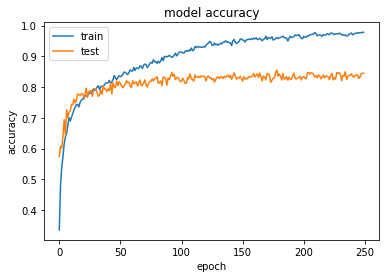

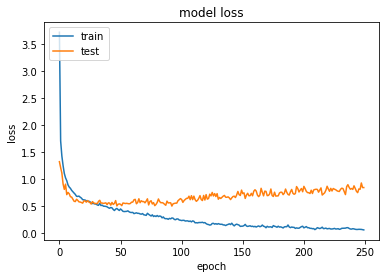

In [ ]:
with open(f'gdrive/MyDrive/Universidad/TFG/trainings/logs/{history_name}', "rb") as file_pi:
    history = pickle.load(file_pi)

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import wandb

run = wandb.init()
artifact = run.use_artifact('ava-research-hyper-kvasir/hyper-kvasir/model-warm-frog-3:v21', type='model')
artifact_dir = artifact.download()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: richardesp (ava-research-hyper-kvasir). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-warm-frog-3:v21, 521.54MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:4.9


In [ ]:
model = keras.models.load_model('artifacts/model-warm-frog-3:v21')

In [ ]:
model.evaluate(X_test, y_test)

68/68 [==============================] - 6s 21ms/step - loss: 0.5700 - accuracy: 0.7905 - top-5-accuracy: 0.9874


[0.5700362920761108, 0.7905027866363525, 0.9874301552772522]